# Astrometric analysis with ePSF

## Importing some modules

In [1]:
import copy, warnings
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.fits as pf
from astropy.modeling import models, fitting
from astropy.nddata import NDData
from astropy.stats import sigma_clipped_stats
from astropy.table import Table
from astropy.visualization import simple_norm
from photutils.background import MMMBackground
from photutils.detection import find_peaks
from photutils.psf import EPSFBuilder, extract_stars

/Users/dkawata/opt/anaconda3/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


### Reading a fits file

In [2]:
hdu = pf.open("img_ver1_2_A.fits")[0]
data = hdu.data.astype(np.float32)
norm = simple_norm(data, 'sqrt', percent=99.)

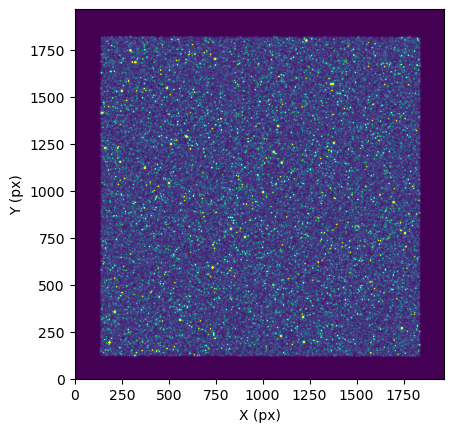

In [3]:
plt.imshow(data, norm=norm, origin='lower', cmap='viridis')
plt.xlabel('X (px)')
plt.ylabel('Y (px)')
plt.show()

In [4]:
np.shape(data)

(1968, 1968)

### Find Peaks

In [5]:
# Finding peaks.
#    mag = 12.0       # Object magnitude.
# mag = 10.5
mag = 11.0
threshold = 3000.*10.**((mag-12.0)/(-2.5))
peaks_tbl = find_peaks(data, threshold=threshold)

In [6]:
peaks_tbl['peak_value'].info.format = '%.8g'  # for consistent table output
print(peaks_tbl)

x_peak y_peak peak_value
------ ------ ----------
   316    125  9666.3301
   322    125  8816.7002
   651    125  7873.3076
   634    128  11776.778
  1720    132  9233.4668
   611    135  11635.645
  1756    137  13934.844
   ...    ...        ...
  1221   1806  7948.9937
  1128   1808  13875.277
  1259   1808  12587.796
  1821   1810  15674.368
  1141   1813  8357.1738
  1221   1813  7625.7861
  1738   1814  15973.133
Length = 1188 rows


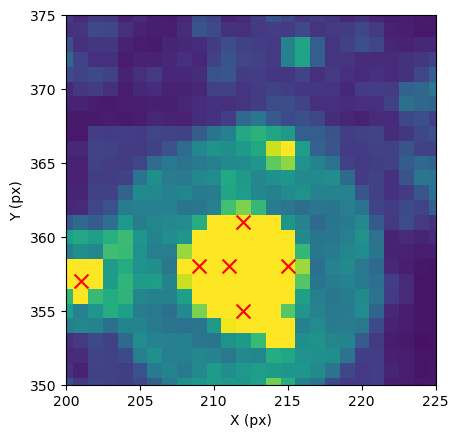

In [7]:
plt.imshow(data, norm=norm,  origin='lower', cmap='viridis')
plt.scatter(peaks_tbl['x_peak'], peaks_tbl['y_peak'], s=100, c='red', marker='x')
plt.xlim(200, 225)
plt.ylim(350, 375)
plt.xlabel('X (px)')
plt.ylabel('Y (px)')
plt.show()

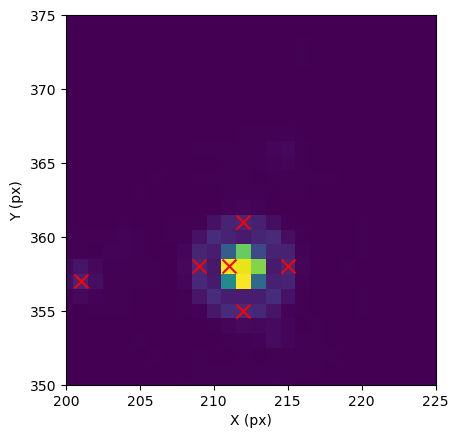

In [8]:
plt.imshow(data, origin='lower', cmap='viridis')
plt.scatter(peaks_tbl['x_peak'], peaks_tbl['y_peak'], s=100, c='red', marker='x')
plt.xlim(200, 225)
plt.ylim(350, 375)
plt.xlabel('X (px)')
plt.ylabel('Y (px)')
plt.show()

### Read input stellar data

In [9]:
# Loading stellar-plate data.
original = np.loadtxt("galcen_star_plate.csv",skiprows=1,delimiter=",")

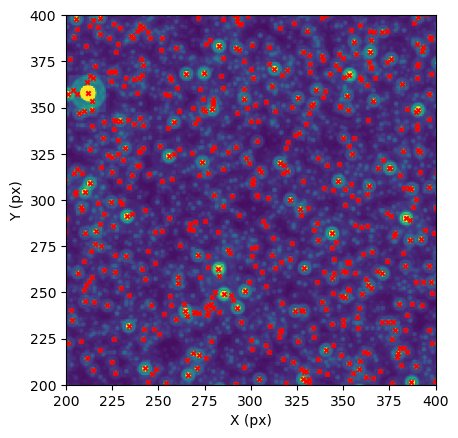

In [10]:
plt.imshow(data, norm=norm, origin='lower', cmap='viridis')
maglimit = 17.0
plt.scatter(original[original[:, 6]<maglimit, 3]-1, original[original[:,6]<maglimit, 2]-1, s=10, c='red', marker='x')
plt.xlim(200, 400)
plt.ylim(200, 400)
plt.xlabel('X (px)')
plt.ylabel('Y (px)')
plt.show()

In [11]:
Nbright = len(original[(original[:,6]>9.5)*(original[:,6]<12.5)*(original[:,3]>30)*(original[:,3]<1938)*(original[:,2]>30)*(original[:,2]<1938)])
print(' N of stars 9.5<Hw<12.5 =', Nbright)

 N of stars 9.5<Hw<12.5 = 554


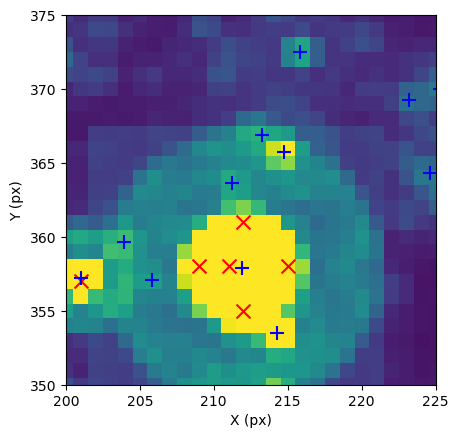

In [12]:
plt.imshow(data, norm=norm,  origin='lower', cmap='viridis')
plt.scatter(peaks_tbl['x_peak'], peaks_tbl['y_peak'], s=100, c='red', marker='x')
plt.scatter(original[original[:, 6]<maglimit, 3]-1, original[original[:,6]<maglimit, 2]-1, s=100, c='blue', marker='+')
plt.xlim(200, 225)
plt.ylim(350, 375)
plt.xlabel('X (px)')
plt.ylabel('Y (px)')
plt.show()

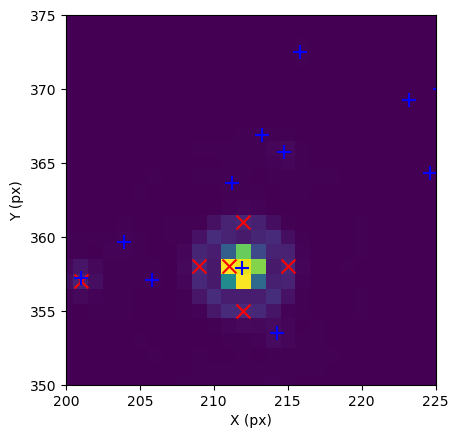

In [13]:
plt.imshow(data, origin='lower', cmap='viridis')
plt.scatter(peaks_tbl['x_peak'], peaks_tbl['y_peak'], s=100, c='red', marker='x')
plt.scatter(original[original[:, 6]<maglimit, 3]-1, original[original[:,6]<maglimit, 2]-1, s=100, c='blue', marker='+')
plt.xlim(200, 400)
plt.xlim(200, 225)
plt.ylim(350, 375)
plt.xlabel('X (px)')
plt.ylabel('Y (px)')
plt.show()

In [14]:
# Removing detections near edge.
mask_size = 25 
hsize = (mask_size - 1) / 2
x = peaks_tbl['x_peak'] 
y = peaks_tbl['y_peak'] 
mask = ((x > hsize) & (x < (data.shape[1] -1 - hsize)) &
            (y > hsize) & (y < (data.shape[0] -1 - hsize)))
stars_tbl = Table()
stars_tbl['x'] = x[mask]
stars_tbl['y'] = y[mask]
print(stars_tbl)

 x    y  
---- ----
 316  125
 322  125
 651  125
 634  128
1720  132
 611  135
1756  137
 ...  ...
1221 1806
1128 1808
1259 1808
1821 1810
1141 1813
1221 1813
1738 1814
Length = 1188 rows


Text(0, 0.5, 'Y (px)')

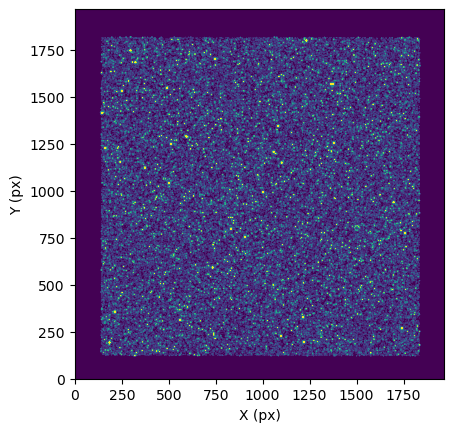

In [15]:
# Subtracting background.
mean_val, median_val, std_val = sigma_clipped_stats(data, sigma=2.)  
image = copy.deepcopy(data)
data -= mean_val
plt.imshow(data, norm=norm, origin='lower', cmap='viridis')
plt.xlabel('X (px)')
plt.ylabel('Y (px)')

(1968, 1968)


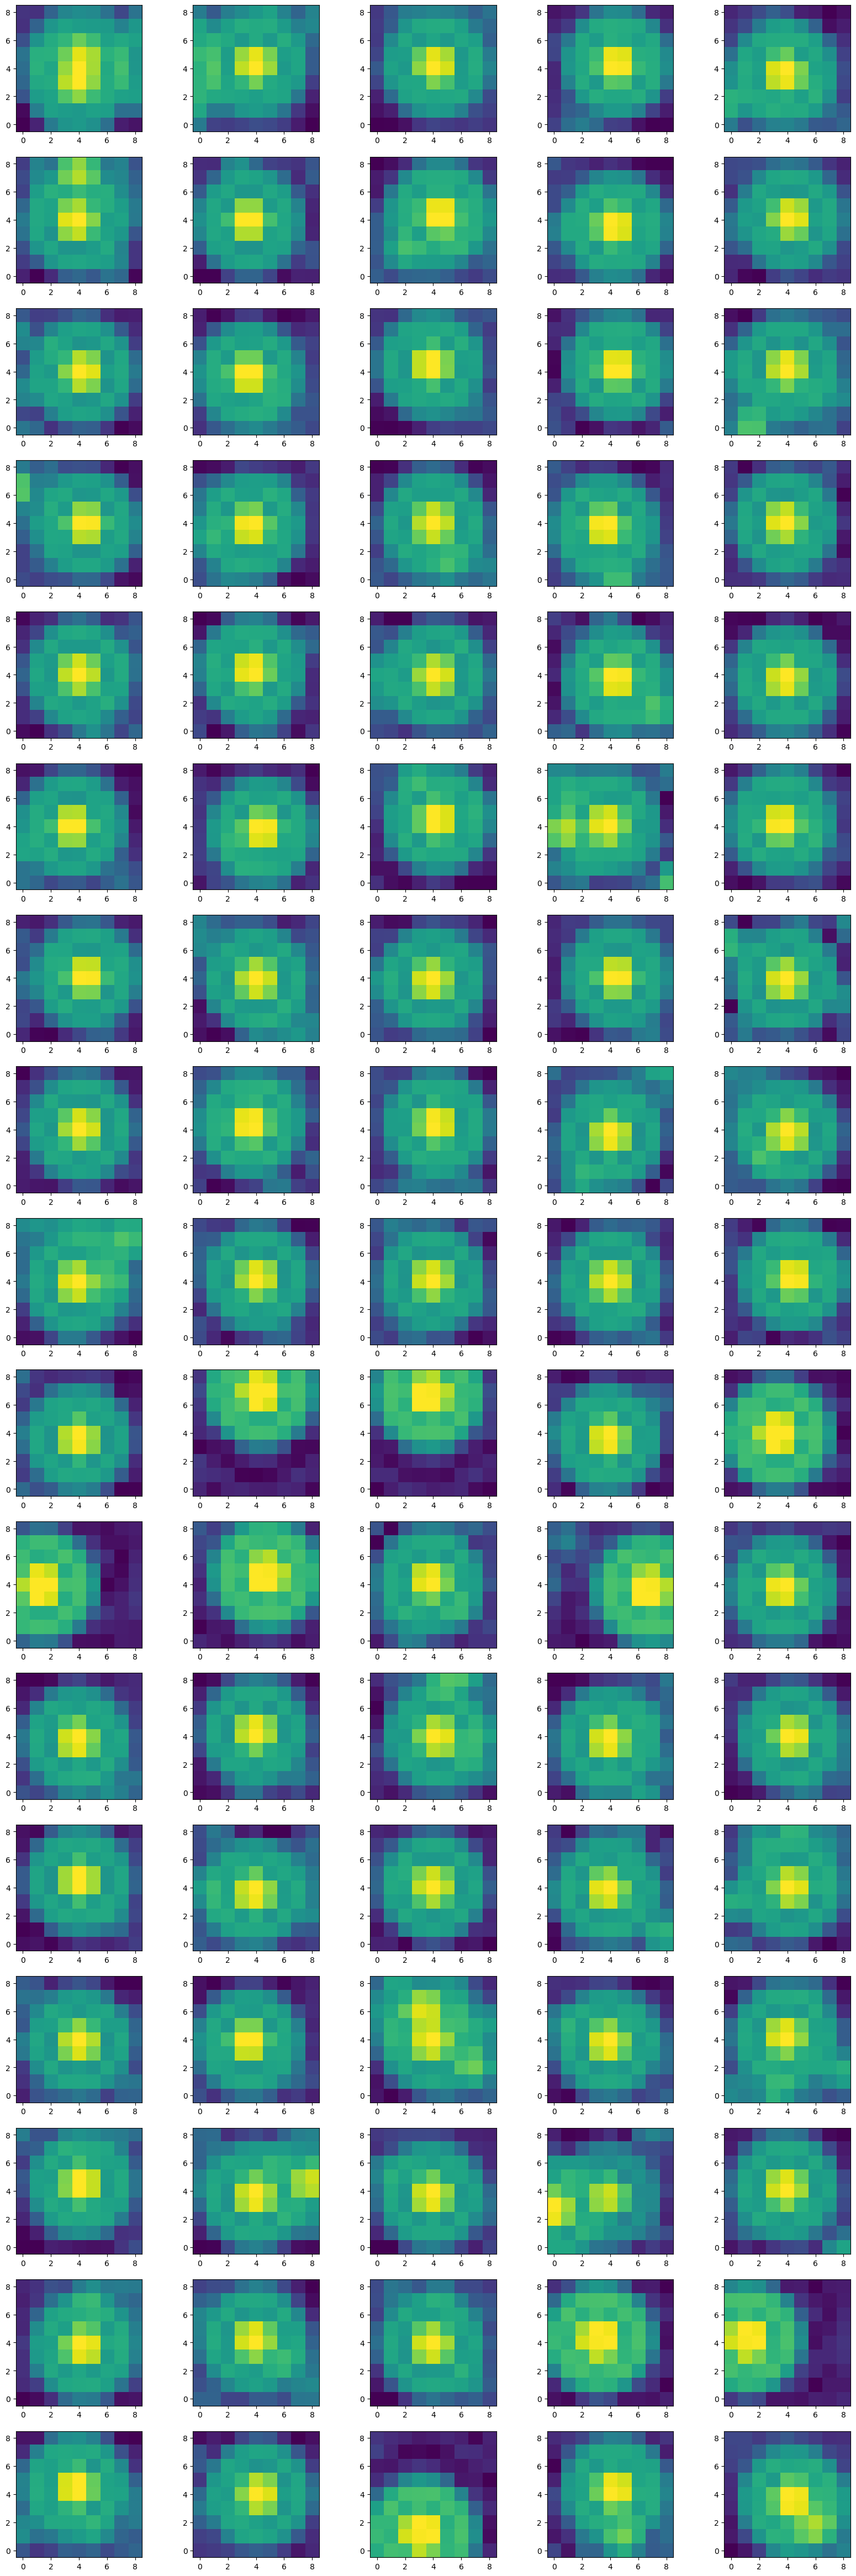

In [16]:
# Extracting stellar images.
ext_size  = 9
nddata = NDData(data=data)
print(nddata.data.shape)
stars = extract_stars(nddata, stars_tbl, size=ext_size)
nrows = 17
ncols = 5
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 60), squeeze=True)
ax = ax.ravel()
for i in range(nrows*ncols):
    norm = simple_norm(stars[i], 'log', percent=99.)
    ax[i].imshow(stars[i], norm=norm, origin='lower', cmap='viridis')
plt.show()

### Make ePSF

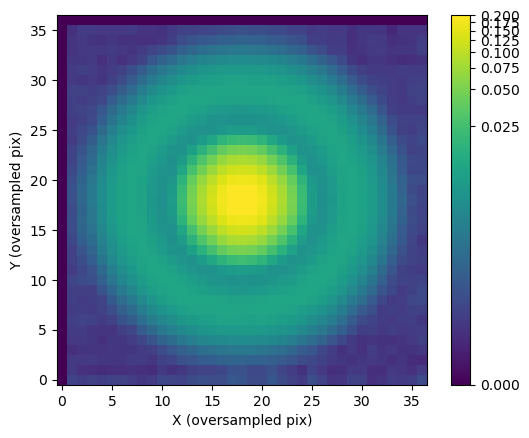

In [17]:
# Making ePSF.
n_oversample = 4 # Number of oversampling for ePSF.
n_maxiter    = 3 # Max. number of iteration for making ePSF.
norm_radius  = 5.5 # Number of undersampled pixels which determines the radius for flux normalization of ePSF.
recentering_boxsize = 5 #  Number of undersampled pixels which determines the box size for ePSF recentering calculation.

epsf_builder = EPSFBuilder(oversampling=n_oversample,
                           maxiters=n_maxiter, progress_bar=False,
                           norm_radius=norm_radius, recentering_boxsize=recentering_boxsize,
                           center_accuracy=0.001)
epsf, fitted_stars = epsf_builder(stars)
norm = simple_norm(epsf.data, 'log', percent=99.)
    
plt.imshow(epsf.data, norm=norm, origin='lower', cmap='viridis')
plt.xlabel('X (oversampled pix)')
plt.ylabel('Y (oversampled pix)')
plt.colorbar()
plt.show()

In [18]:
print(' centre_flat =', fitted_stars.center_flat, np.shape(fitted_stars.center_flat))

 centre_flat = [[ 315.97878165  124.63555269]
 [ 321.91209143  125.31747769]
 [ 651.19396627  125.28241   ]
 ...
 [1140.84226742 1813.34351426]
 [1221.27649009 1812.89638572]
 [1737.69348973 1813.73589551]] (1188, 2)


number of stars brighter than  12.5 = 585


(200.0, 400.0)

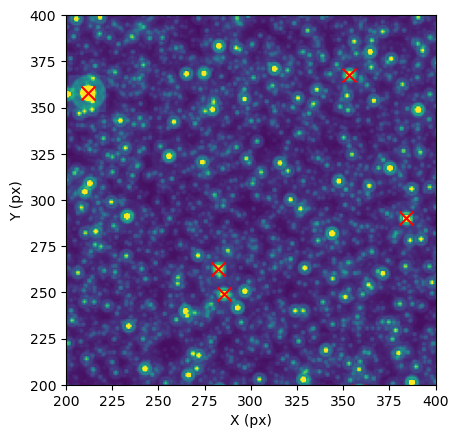

In [19]:
# Subtracting background.
maglimit = 12.5
norm = simple_norm(data, 'sqrt', percent=99.)
print('number of stars brighter than ', maglimit, '=', len(original[original[:,6]<maglimit, 2]))
plt.imshow(data, norm=norm, origin='lower', cmap='viridis')
plt.scatter(original[original[:, 6]<maglimit, 3]-1, original[original[:,6]<maglimit, 2]-1, s=100, c='red', marker='x')
plt.xlabel('X (px)')
plt.ylabel('Y (px)')
plt.xlim(200, 400)
plt.ylim(200, 400)


Text(0, 0.5, 'Y (px)')

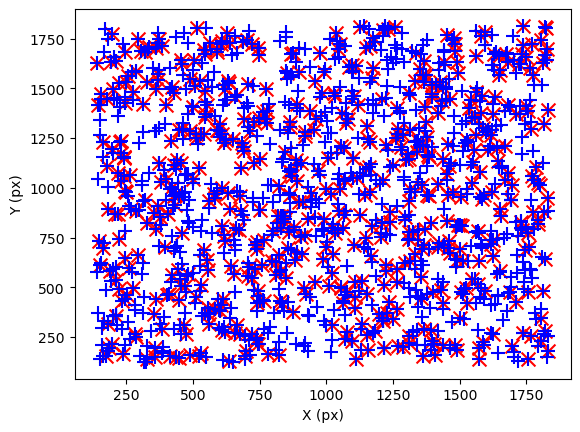

In [20]:
plt.scatter(original[original[:, 6]<maglimit, 3]-1, original[original[:,6]<maglimit, 2]-1, s=100, c='red', marker='x')
plt.scatter(fitted_stars.center_flat[:, 0], fitted_stars.center_flat[:, 1],  s=100, c='blue', marker='+')
plt.xlabel('X (px)')
plt.ylabel('Y (px)')
# plt.xlim(200, 300)
# plt.ylim(200, 300)

In [21]:
# Cross-matching the data.
xc_array = []
maglim_o = maglimit+1
# search stars only for brighter stars
stars_list = original[original[:, 6] < maglim_o]
print(np.shape(stars_list))

# for loop for fitted stars
nfitted_stars = len(fitted_stars.center_flat[:, 0])
print(' N fitted stars=', np.shape(fitted_stars.center_flat), nfitted_stars)
print(' fitted_stars.center_flat', np.shape(fitted_stars.center_flat[0]))
for i in range(nfitted_stars):
    xdiff = fitted_stars.center_flat[i, 0]-stars_list[:, 3]+1.0
    ydiff = fitted_stars.center_flat[i, 1]-stars_list[:, 2]+1.0
    dist2 = xdiff**2+ydiff**2
    # closest
    mindx = np.argmin(dist2)
    # print(' indx, dist, x, y s, f=', mindx, dist2[mindx], o[3]-1.0, o[2]-1.0, fitted_stars.center_flat[mindx])
    # print(dist2[mindx], stars_list[mindx, 3]-1.,stars_list[mindx, 2]-1.,fitted_stars.center_flat[i, 0], fitted_stars.center_flat[i, 1])
    xc_array.append([stars_list[mindx, 3]-1.,stars_list[mindx, 2]-1.,      # 1-origin -> 0-origin
                             fitted_stars.center_flat[i, 0],
                             fitted_stars.center_flat[i, 1]])
    if dist2[mindx]>0.6: 
        print(' star ', i, ' min dist =', np.sqrt(dist2[mindx]), stars_list[mindx, 6])
        plt.imshow(data, norm=norm, origin='lower', cmap='viridis')
        plt.scatter(fitted_stars.center_flat[i, 0], fitted_stars.center_flat[i, 1], s=100, c='blue', marker='+')
        plt.scatter(original[original[:, 6]<maglim_o, 3]-1, original[original[:,6]<maglim_o, 2]-1, s=100, c='red', marker='x')
        plt.xlabel('X (px)')
        plt.ylabel('Y (px)')
        plt.xlim(fitted_stars.center_flat[i, 0]-5.0, fitted_stars.center_flat[i, 0]+5.0)
        plt.ylim(fitted_stars.center_flat[i, 1]-5.0, fitted_stars.center_flat[i, 1]+5.0)
        plt.show()
xc_array = np.array(xc_array)
print(' number of stars brighter than ', maglim_o, ' in the list =', len(xc_array))

(1990, 7)
 N fitted stars= (1188, 2) 1188
 fitted_stars.center_flat (2,)
 number of stars brighter than  13.5  in the list = 1188


In [22]:
# excluding bright stars
xc_array = []
maglim_o = maglimit+1.0
maglim_bright = 9.5
# search stars only for brighter stars
stars_list = original[original[:, 6] < maglim_o]
print(np.shape(stars_list))

# for loop for fitted stars
nfitted_stars = len(fitted_stars.center_flat[:, 0])
print(' N fitted stars=', np.shape(fitted_stars.center_flat), nfitted_stars)
print(' fitted_stars.center_flat', np.shape(fitted_stars.center_flat[0]))
for i in range(nfitted_stars):
    xdiff = fitted_stars.center_flat[i, 0]-stars_list[:, 3]+1.0
    ydiff = fitted_stars.center_flat[i, 1]-stars_list[:, 2]+1.0
    dist2 = xdiff**2+ydiff**2
    # closest
    mindx = np.argmin(dist2)
    if stars_list[mindx, 6]> maglim_bright:
        # print(' indx, dist, x, y s, f=', mindx, dist2[mindx], o[3]-1.0, o[2]-1.0, fitted_stars.center_flat[mindx])
        # print(dist2[mindx], stars_list[mindx, 3]-1.,stars_list[mindx, 2]-1.,fitted_stars.center_flat[i, 0], fitted_stars.center_flat[i, 1])
        xc_array.append([stars_list[mindx, 3]-1.,stars_list[mindx, 2]-1.,      # 1-origin -> 0-origin
                                 fitted_stars.center_flat[i, 0],
                                 fitted_stars.center_flat[i, 1], stars_list[mindx, 6]])

xc_array = np.array(xc_array)
print(' number of stars brighter than ', maglim_o, ' in the list =', len(xc_array))

(1990, 7)
 N fitted stars= (1188, 2) 1188
 fitted_stars.center_flat (2,)
 number of stars brighter than  13.5  in the list = 1103


In [23]:
dx = xc_array[:,2] - xc_array[:,0]
dy = xc_array[:,3] - xc_array[:,1]
dx0 = dx - np.mean(dx)
dy0 = dy - np.mean(dy)
dist = np.sqrt(dx0**2+dy0**2)
dx_mean =  np.mean(dx)
dy_mean =  np.mean(dy)

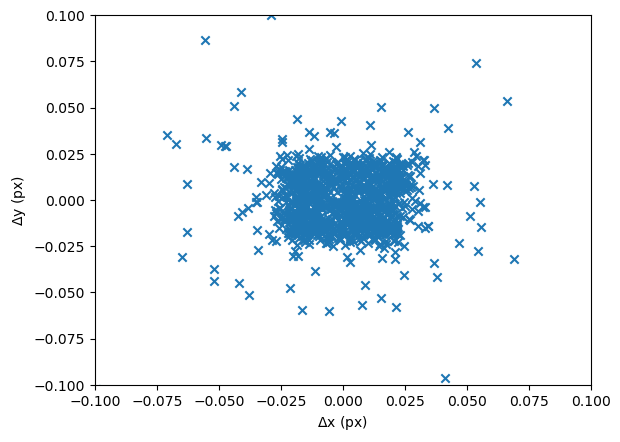

In [24]:
plt.scatter(dx0, dy0, marker='x')
plt.xlabel('$\Delta$x (px)')
plt.ylabel('$\Delta$y (px)')
plt.xlim([-0.1,0.1])
plt.ylim([-0.1,0.1])
plt.show()

In [25]:
# mean and std
print(' for all stars')
print(' number of stars fitted =', len(dist))
print(' mean deviation for 2D dist =', np.mean(dist))
print(' std deviation for 2D dist =', np.std(dist))
print(' mean devision in x = ', np.mean(dx0))
print(' std  = ', np.std(dx0))
print(' mean devision in y = ', np.mean(dy0))
print(' std  = ', np.std(dy0))
devlim = 0.1
print(' for stars their delta d <', devlim)
print(' number of stars fitted =', len(dist[dist<devlim]))
print(' mean deviation for dist =', np.mean(dist[dist<devlim]))
print(' std deviation for dist =', np.std(dist[dist<devlim]))
print(' std  for dx = ', np.std(dx0[dx0<devlim]))
print(' std dy = ', np.std(dy0[dy0<devlim]))

 for all stars
 number of stars fitted = 1103
 mean deviation for 2D dist = 0.027993304277330336
 std deviation for 2D dist = 0.05116188927555263
 mean devision in x =  -1.0065485264054003e-18
 std  =  0.0369321878037907
 mean devision in y =  1.8117873475297205e-18
 std  =  0.04513510277636069
 for stars their delta d < 0.1
 number of stars fitted = 1073
 mean deviation for dist = 0.020998921256612662
 std deviation for dist = 0.01094289866469614
 std  for dx =  0.028314098807193072
 std dy =  0.035019362254585434


### Examples of bad cases

The contamination seems to be sever. 

 star  464  dist= 0.5297831215729494


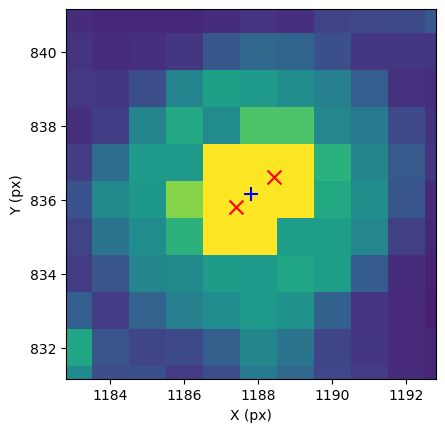

 star  592  dist= 0.673967429101399


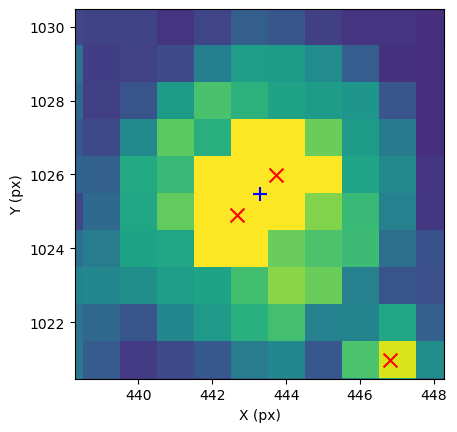

 star  676  dist= 0.6011191402344015


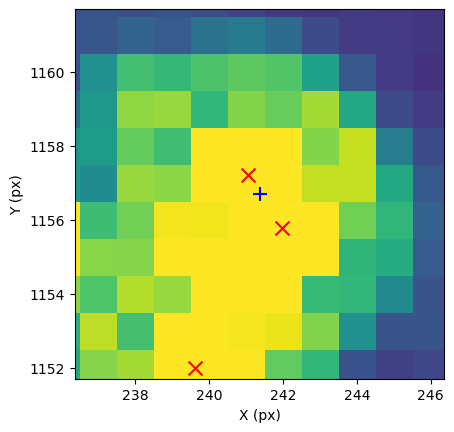

 star  1044  dist= 0.5549521110964931


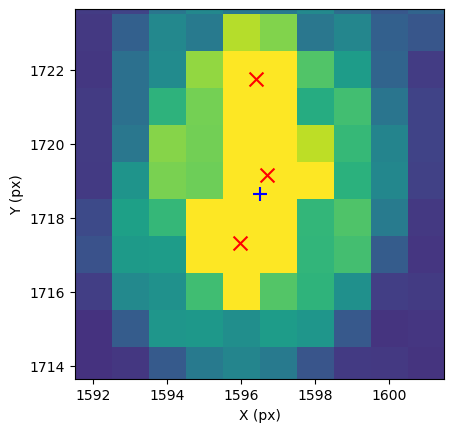

In [26]:

for i in range(len(dist)):
    if dist[i]>0.5: 
        print(' star ', i, ' dist=', dist[i])
        plt.imshow(data, norm=norm, origin='lower', cmap='viridis')
        plt.scatter(xc_array[i,2], xc_array[i,3], s=100, c='blue', marker='+')
        plt.scatter(original[original[:, 6]<15.0, 3]-1+dx_mean, original[original[:,6]<15.0, 2]-1+dy_mean, s=100, c='red', marker='x')
        # plt.scatter(xc_array[i,0]+dx_mean, xc_array[i,1]+dx_mean, s=100, c='red', marker='x')
        plt.xlabel('X (px)')
        plt.ylabel('Y (px)')
        plt.xlim(xc_array[i,2]-5.0, xc_array[i,2]+5.0)
        plt.ylim(xc_array[i,3]-5.0,xc_array[i,3]+5.0)
        plt.show()

### Example of the best cases

Cases with 2D error <0.0085 pix. 

 dx and dy mean =  0.012513683231397326 0.02103764964981971
 N (dist<0.0085)= 74
 star  6  dist= 0.0022692482205361264


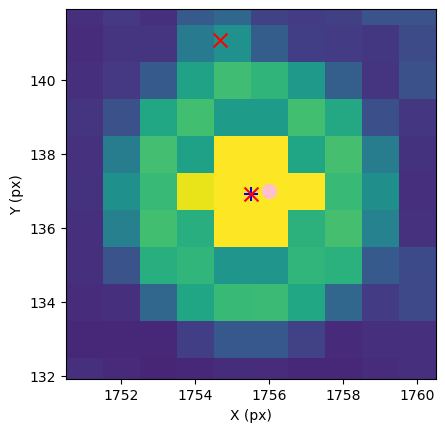

 star  7  dist= 0.00350507904824617


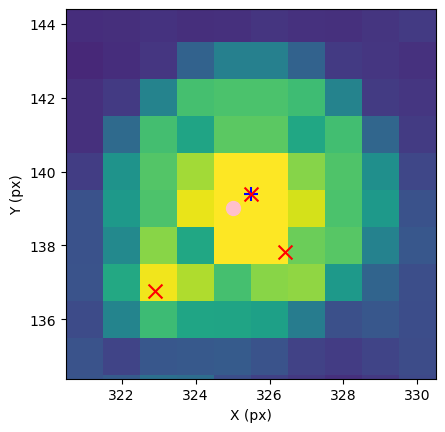

 star  8  dist= 0.003909759130222415


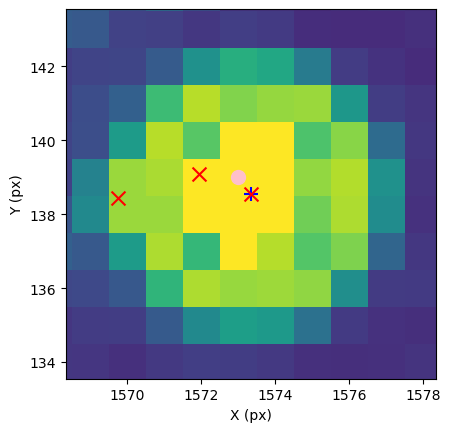

 star  13  dist= 0.008208305126471343


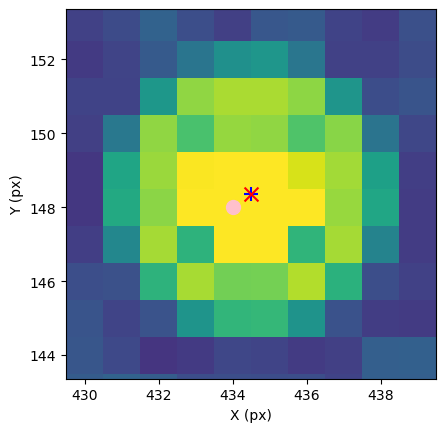

 star  15  dist= 0.005524356893048715


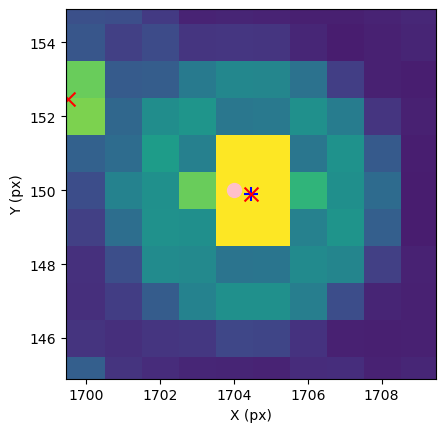

 star  23  dist= 0.007665004241331843


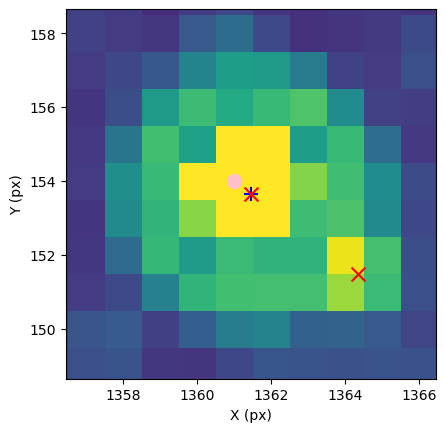

 star  27  dist= 0.004654811427298508


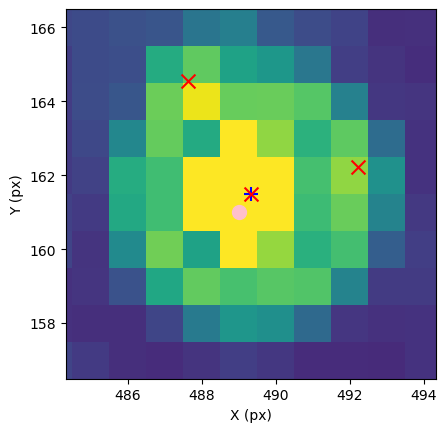

 star  54  dist= 0.007148563013014188


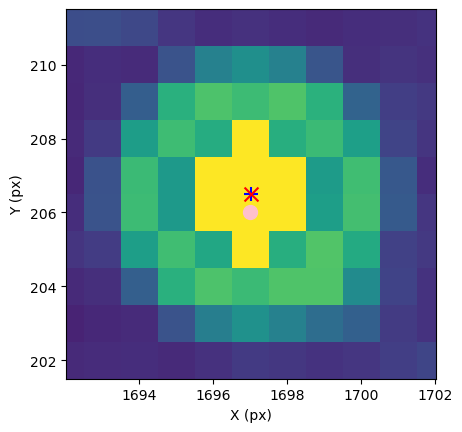

 star  64  dist= 0.004076687674028937


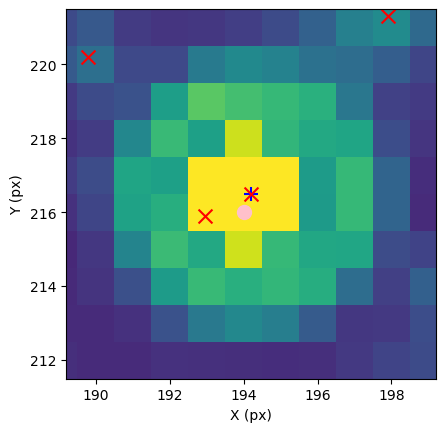

 star  76  dist= 0.004138301689521857


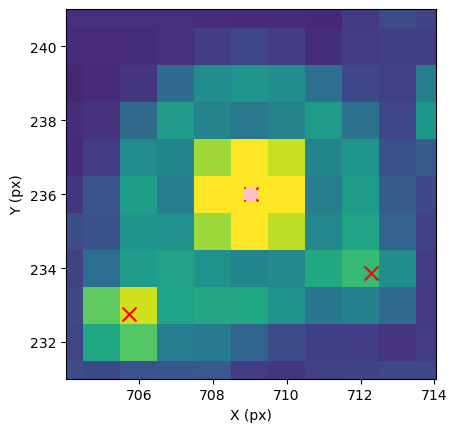

 star  78  dist= 0.007947491006770767


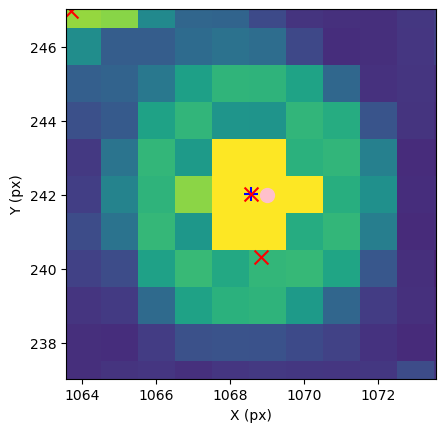

 star  81  dist= 0.006518464763699445


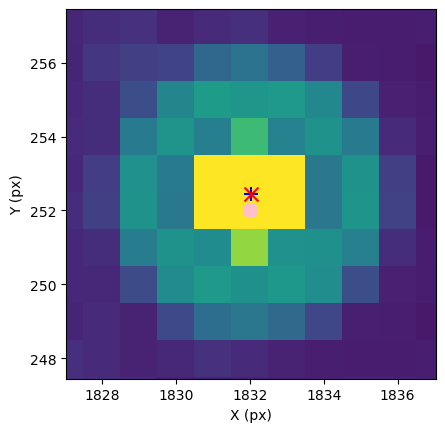

 star  92  dist= 0.005585478966296352


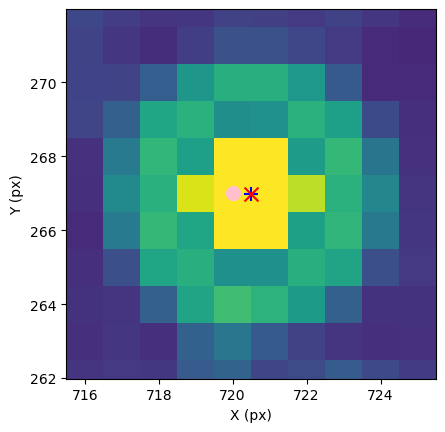

 star  115  dist= 0.0032624612760431245


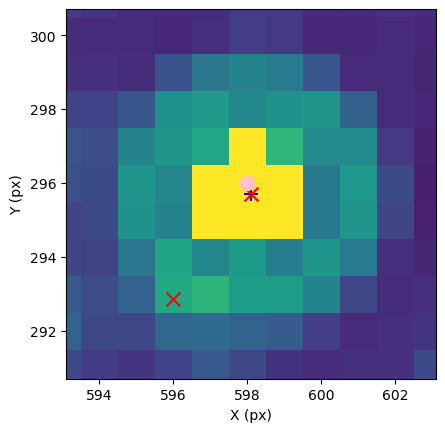

 star  149  dist= 0.005861542258824364


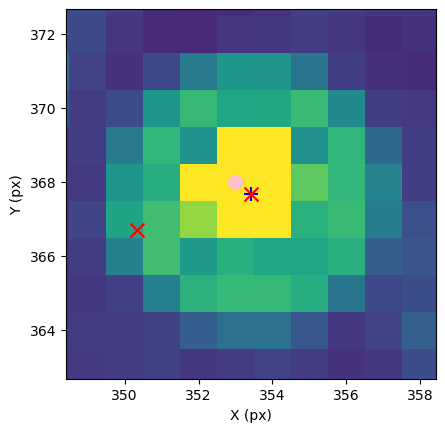

 star  159  dist= 0.004767622540500509


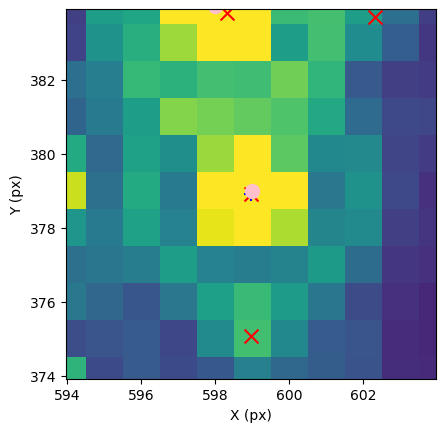

 star  173  dist= 0.004223194495514252


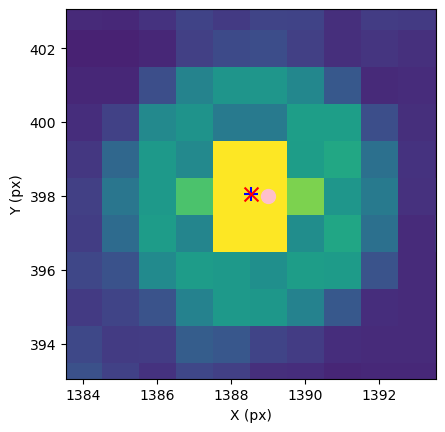

 star  200  dist= 0.007137492388125502


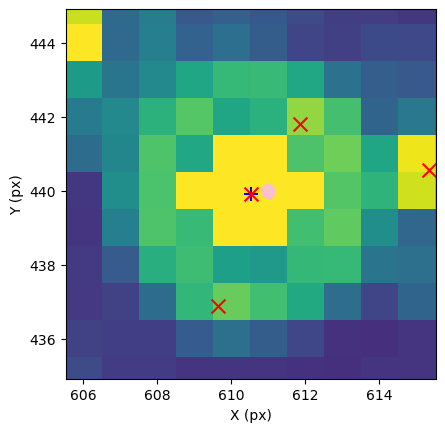

 star  229  dist= 0.003750630106469519


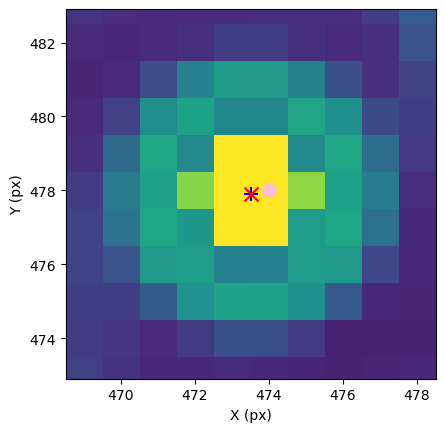

 star  258  dist= 0.006172407619543766


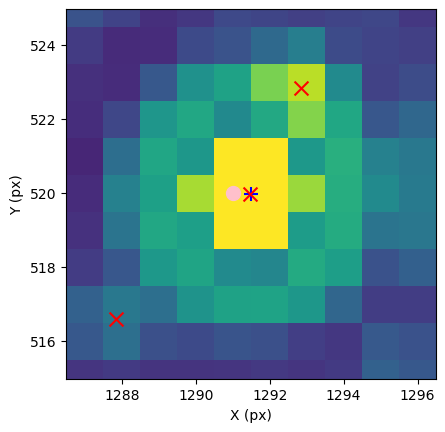

 star  272  dist= 0.005201810862736224


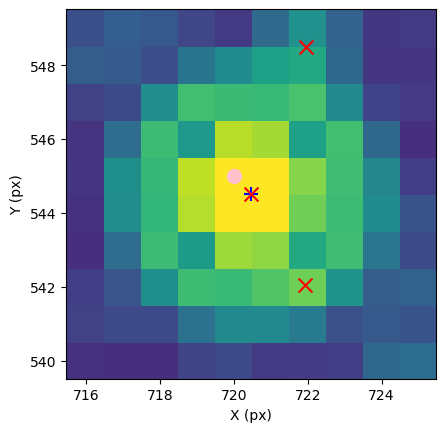

 star  285  dist= 0.0034410559817926543


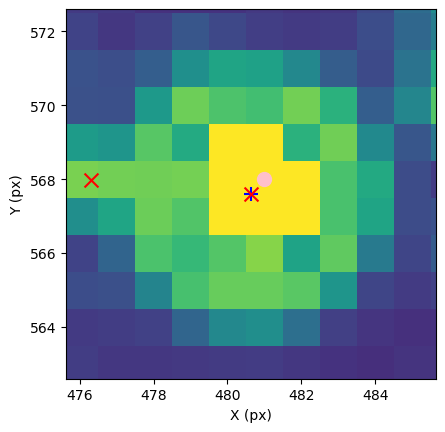

 star  314  dist= 0.008295275537353718


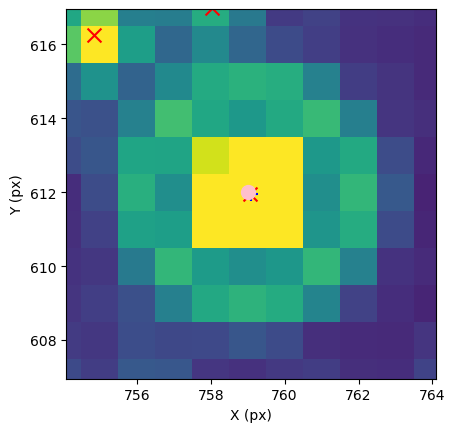

 star  323  dist= 0.00520616729152652


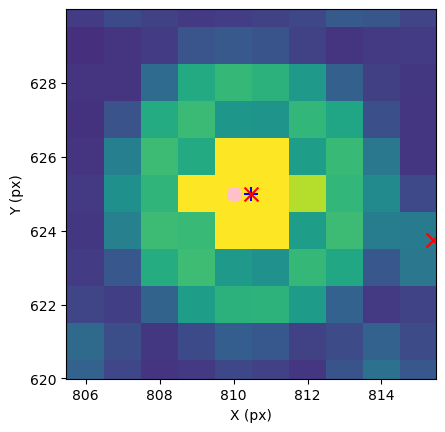

 star  341  dist= 0.007742484005691855


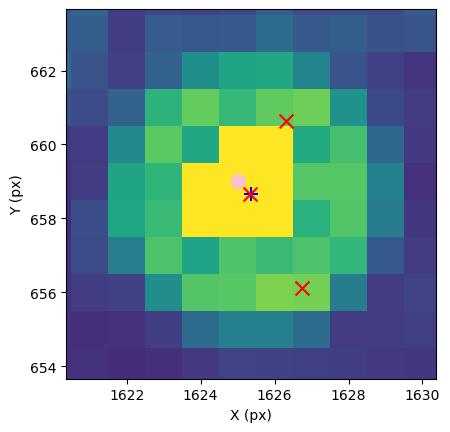

 star  410  dist= 0.00782216921787613


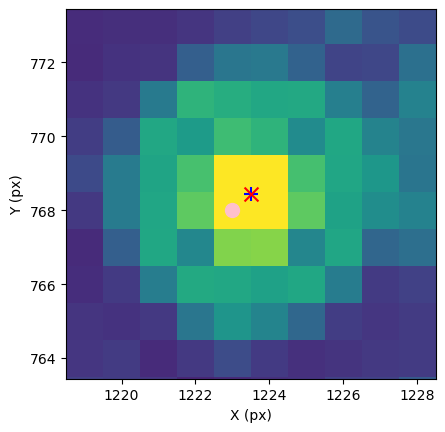

 star  418  dist= 0.005425649969831148


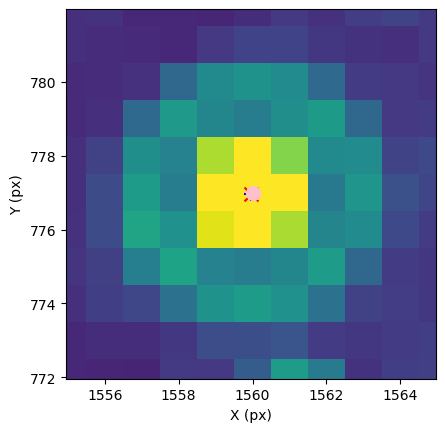

 star  441  dist= 0.007451074623948923


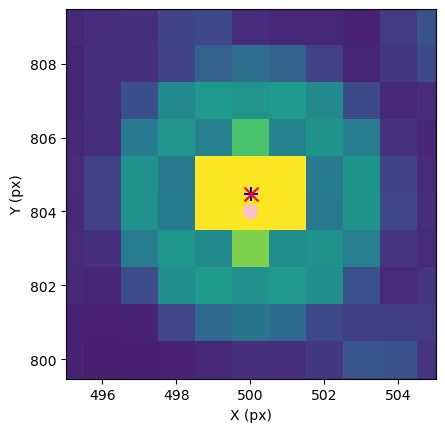

 star  445  dist= 0.004877960030131347


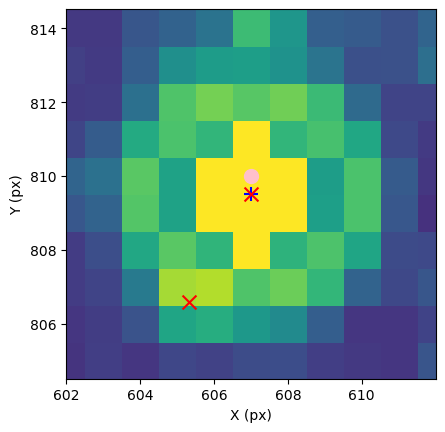

 star  455  dist= 0.002264840340928976


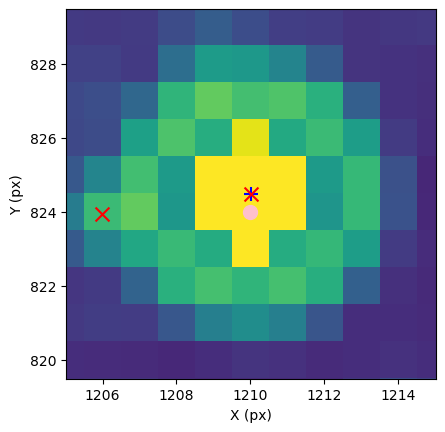

 star  472  dist= 0.0068531797616856755


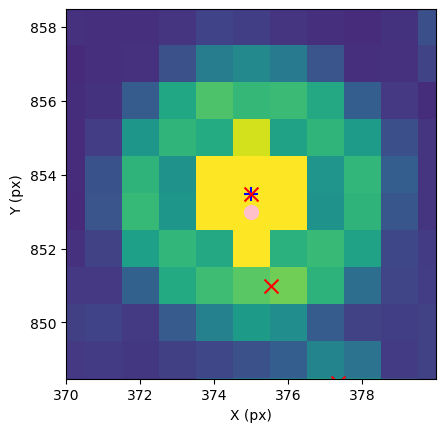

 star  511  dist= 0.007981566923107307


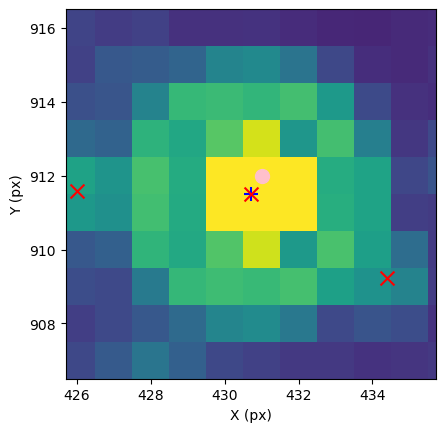

 star  515  dist= 0.005240264665512459


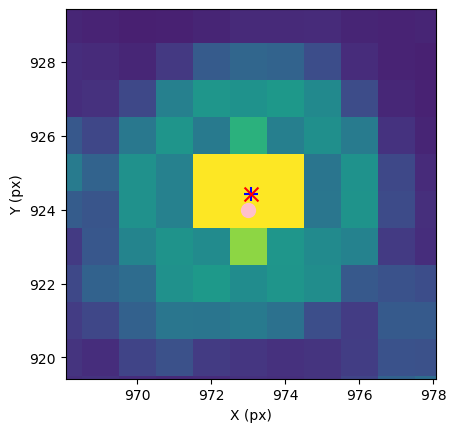

 star  534  dist= 0.006618998728704156


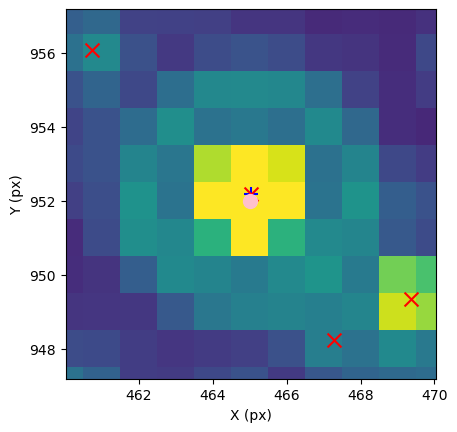

 star  547  dist= 0.0051373027096273125


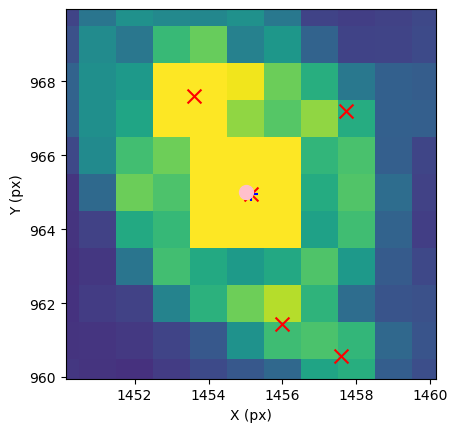

 star  573  dist= 0.002081301659658092


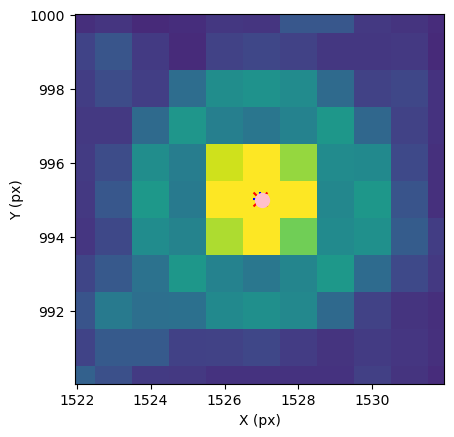

 star  575  dist= 0.0033336878401667137


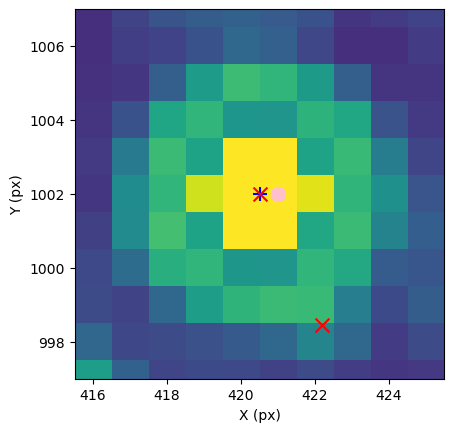

 star  588  dist= 0.004521277113836285


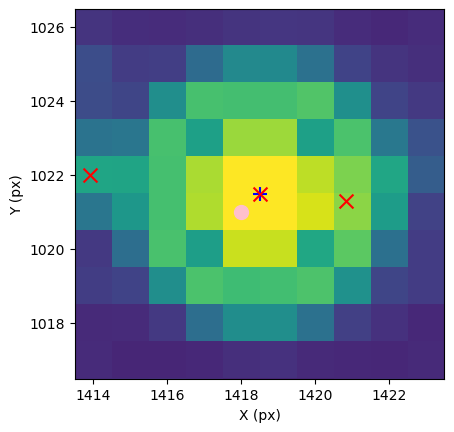

 star  591  dist= 0.007766906290283818


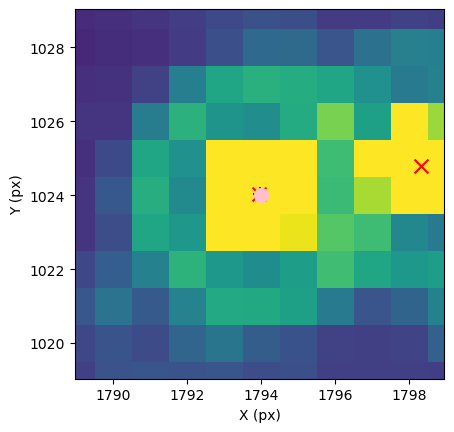

 star  602  dist= 0.006863608890320471


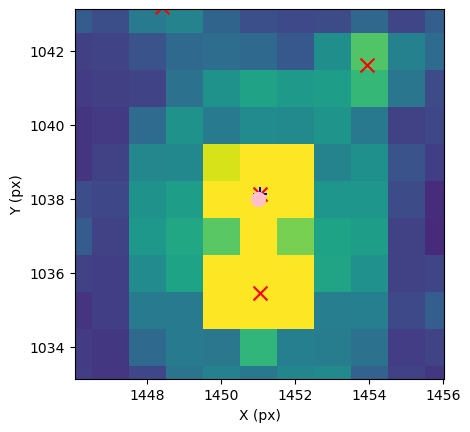

 star  612  dist= 0.004277168778830982


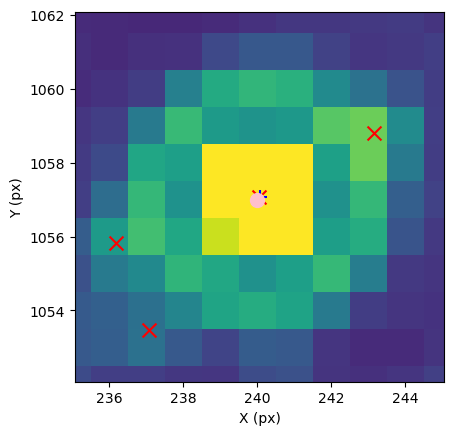

 star  615  dist= 0.007478360270669772


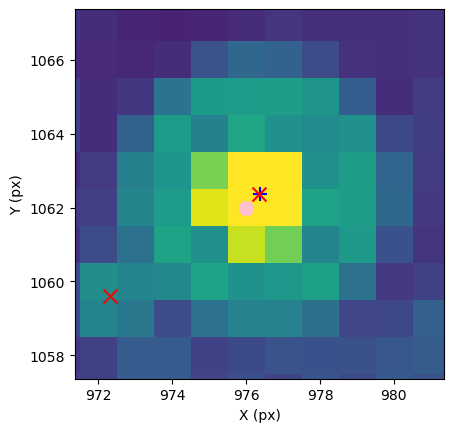

 star  624  dist= 0.008104227764120741


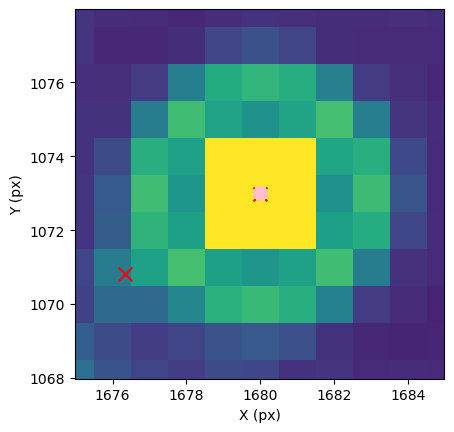

 star  639  dist= 0.007781917286341927


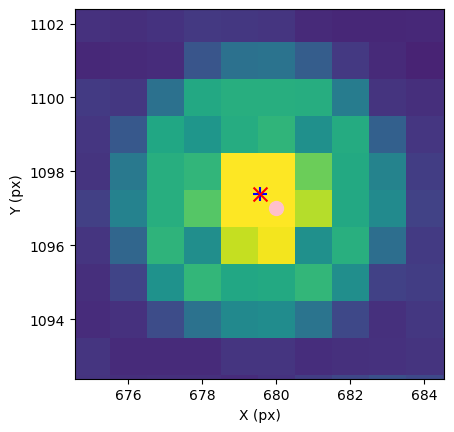

 star  682  dist= 0.0014888197783230668


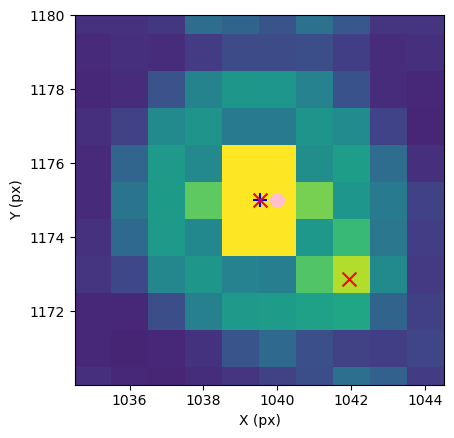

 star  684  dist= 0.0012286848117418318


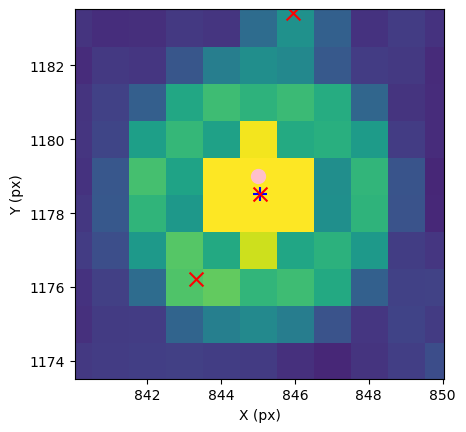

 star  695  dist= 0.0021128800473107223


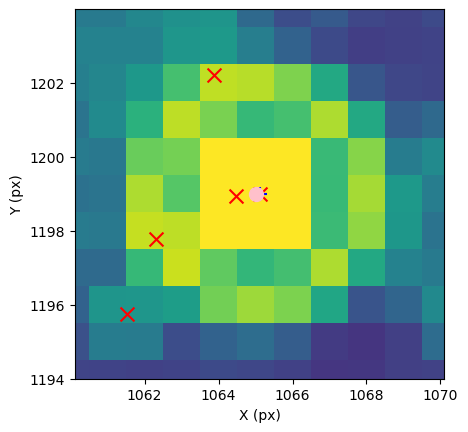

 star  726  dist= 0.004754024378910639


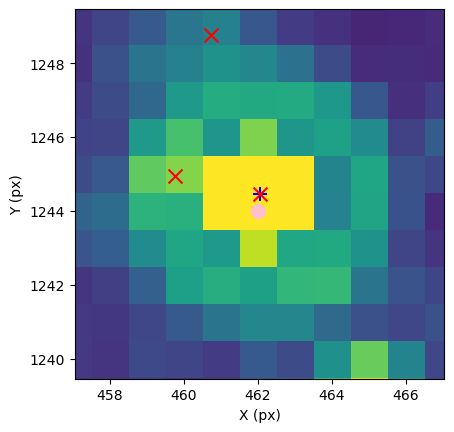

 star  757  dist= 0.008403471237613626


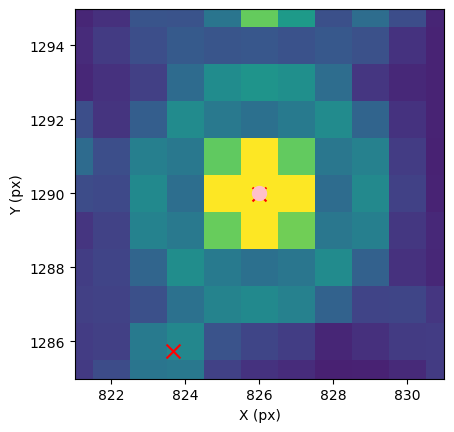

 star  759  dist= 0.004136361264604114


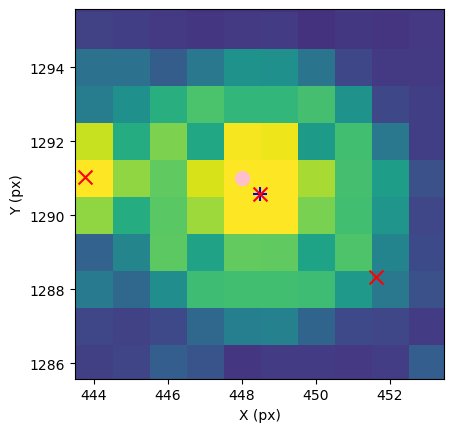

 star  764  dist= 0.007727358547702921


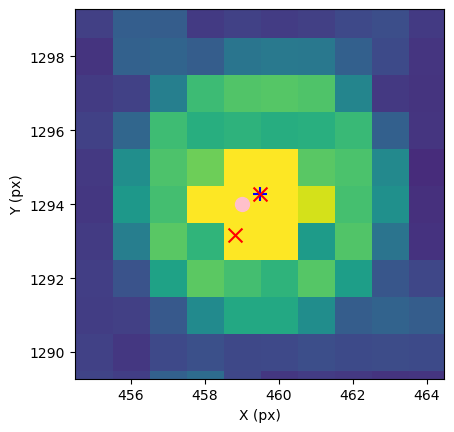

 star  769  dist= 0.0029512576816957156


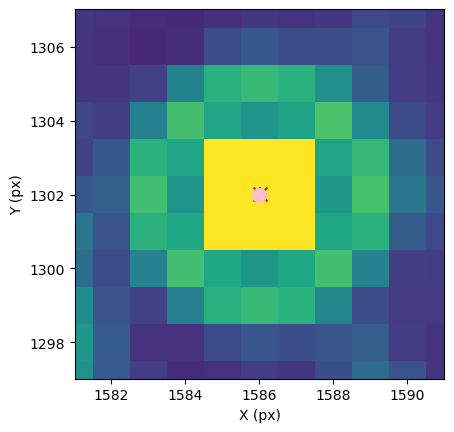

 star  774  dist= 0.00248314519369479


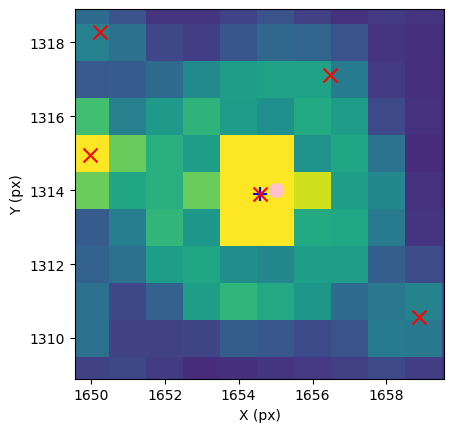

 star  781  dist= 0.007849976363175096


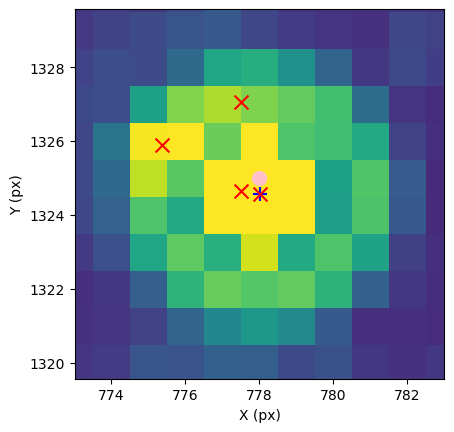

 star  791  dist= 0.007013821994884568


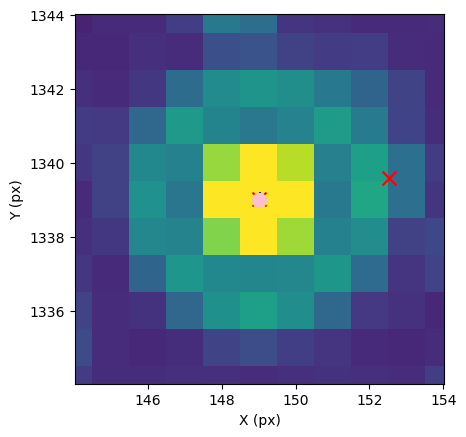

 star  793  dist= 0.008052318386445562


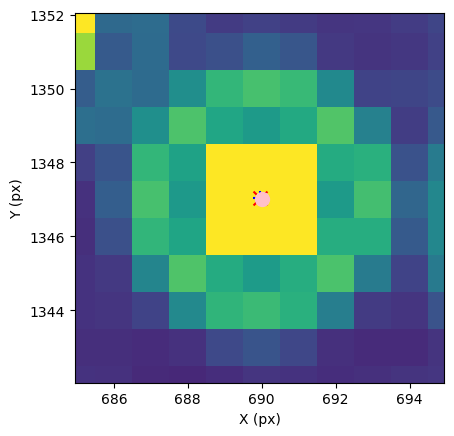

 star  806  dist= 0.006652182275034817


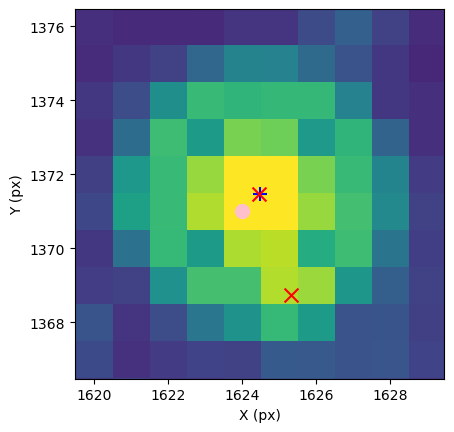

 star  824  dist= 0.0070278007654348525


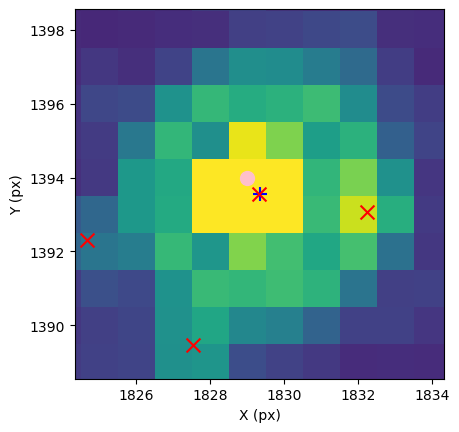

 star  846  dist= 0.006297815278489325


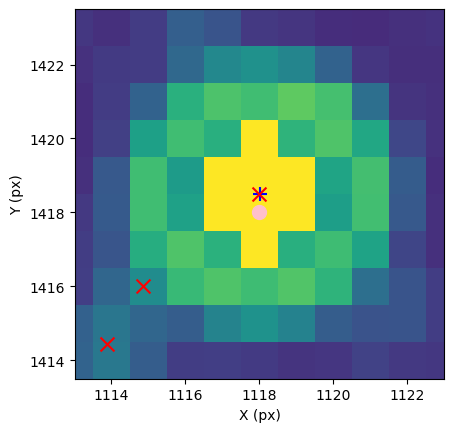

 star  856  dist= 0.006376490373708052


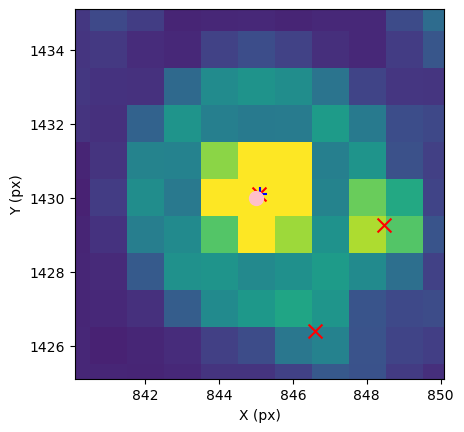

 star  858  dist= 0.004611062768855198


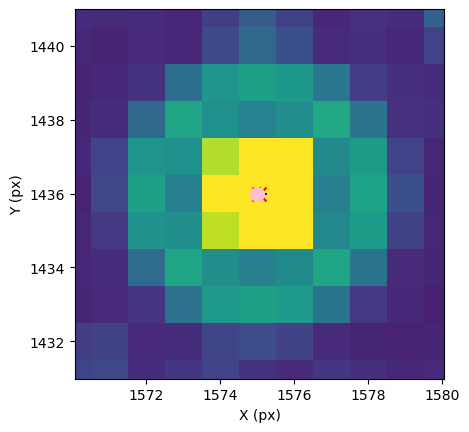

 star  870  dist= 0.008216480882371086


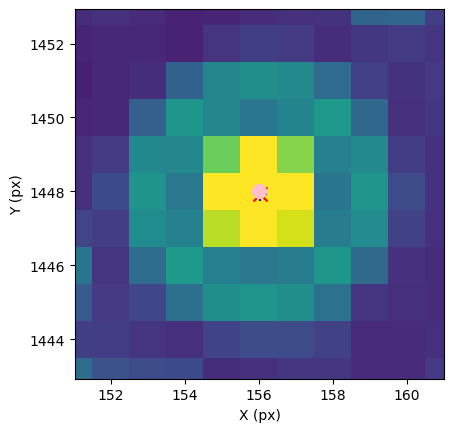

 star  897  dist= 0.0051829981448674204


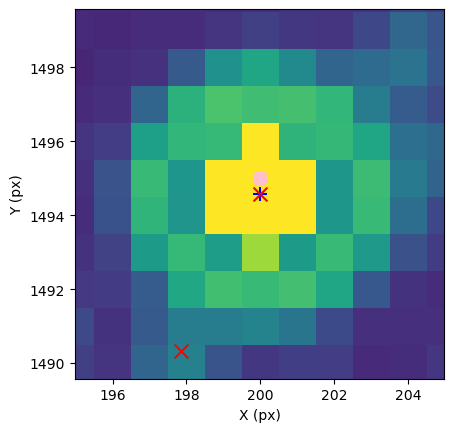

 star  977  dist= 0.0051360209307061404


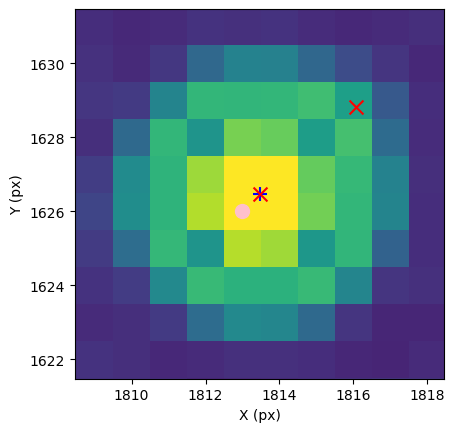

 star  1012  dist= 0.0033688115878304442


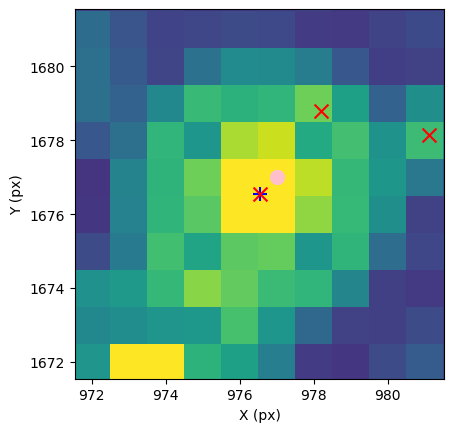

 star  1013  dist= 0.005643931492769208


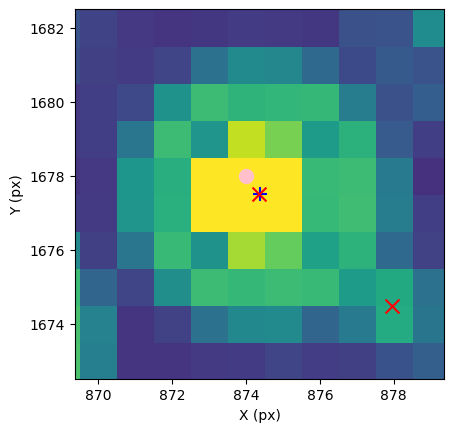

 star  1018  dist= 0.0035398324440433083


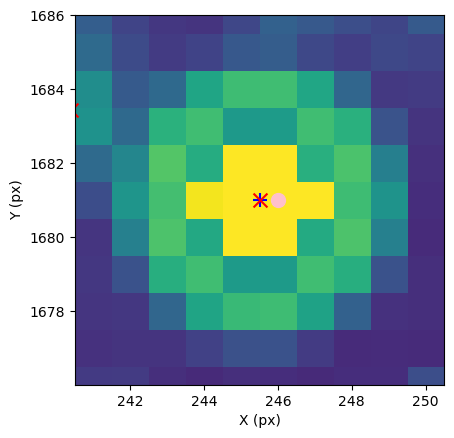

 star  1030  dist= 0.008223945756905651


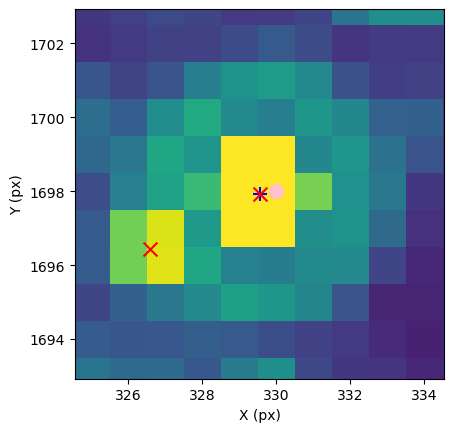

 star  1049  dist= 0.008310707198860115


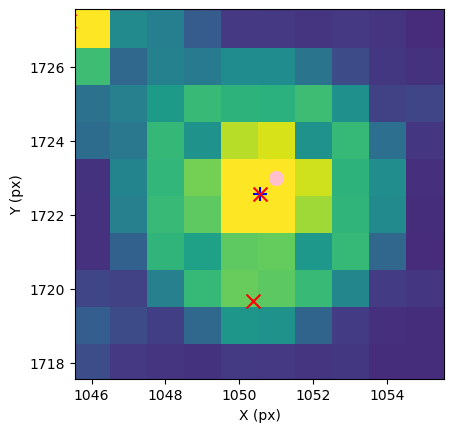

 star  1063  dist= 0.008387776203694079


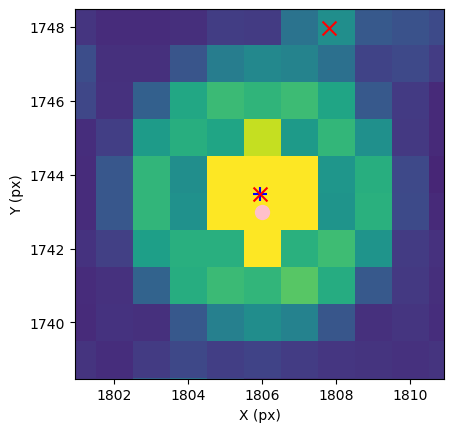

 star  1067  dist= 0.006292463900644162


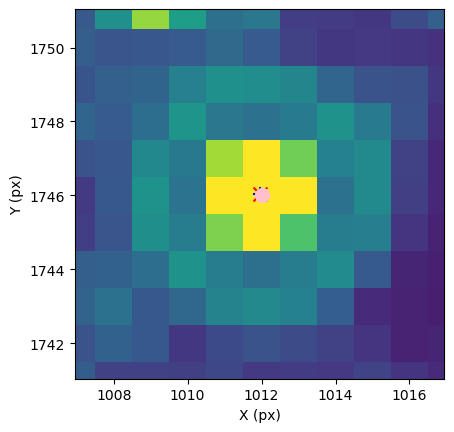

 star  1070  dist= 0.0011572692047000092


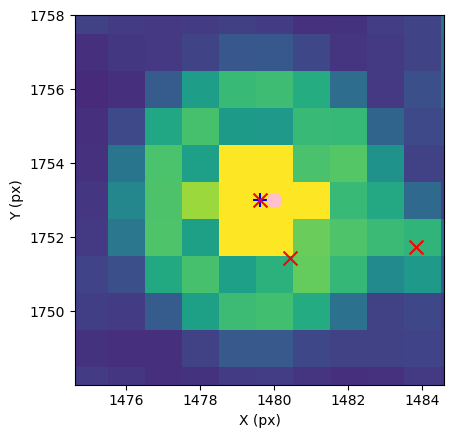

 star  1074  dist= 0.008027582662363116


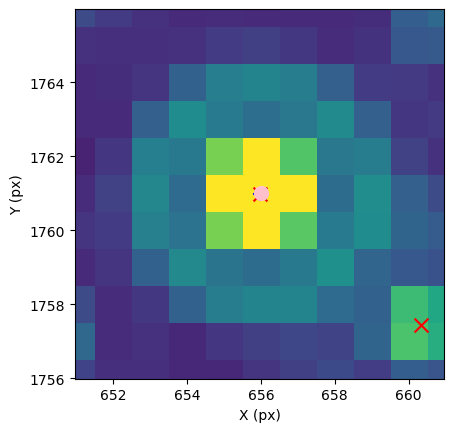

 star  1087  dist= 0.003231916990301475


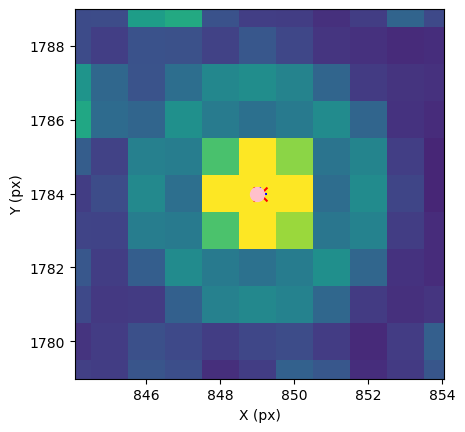

In [27]:
# good ones
print(' dx and dy mean = ', dx_mean, dy_mean)
print(' N (dist<0.0085)=', len(dist[dist<0.0085]))
for i in range(len(dist)):
    if dist[i]<0.0085: 
        print(' star ', i, ' dist=', dist[i])
        plt.imshow(data, norm=norm, origin='lower', cmap='viridis')
        plt.scatter(xc_array[i,2], xc_array[i,3], s=100, c='blue', marker='+')
        plt.scatter(original[original[:, 6]<17.0, 3]-1+dx_mean, original[original[:,6]<17.0, 2]-1+dy_mean, s=100, c='red', marker='x')
        plt.scatter(peaks_tbl['x_peak'], peaks_tbl['y_peak'], s=100, c='pink', marker='o')
        plt.xlabel('X (px)')
        plt.ylabel('Y (px)')
        plt.xlim(xc_array[i,2]-5.0, xc_array[i,2]+5.0)
        plt.ylim(xc_array[i,3]-5.0,xc_array[i,3]+5.0)
        plt.show()

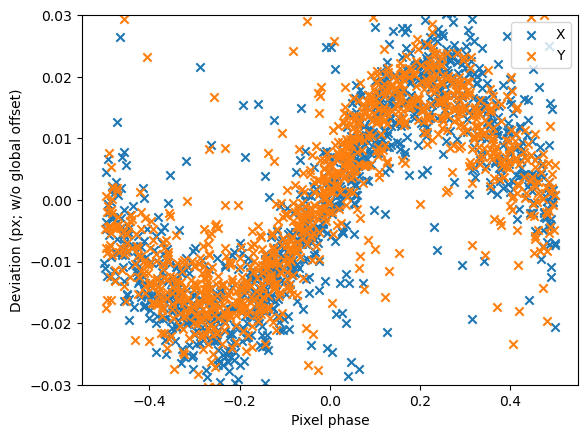

In [28]:
# Making pix-phase error data.
plt.scatter(xc_array[:,0]-(xc_array[:,0]+0.5).astype('int'), dx0, marker='x', label='X')
plt.scatter(xc_array[:,1]-(xc_array[:,1]+0.5).astype('int'), dy0, marker='x', label='Y')
#    plt.xlabel('$\Delta$x (px; w/o global offset)')
#    plt.ylabel('$\Delta$y (px; w/o global offset)')
#    plt.xlim([-0.03-0.98,0.03-0.98])
#    plt.ylim([-0.03-0.98,0.03-0.98])
# plt.xlim([-0.1,0.1])
plt.ylim([-0.03,0.03])
plt.xlabel('Pixel phase')
plt.ylabel('Deviation (px; w/o global offset)')
plt.legend()
plt.show()
    

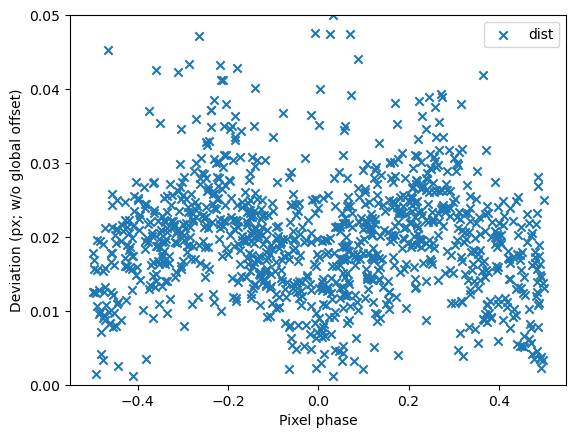

In [29]:
# Making pix-phase error data.
plt.scatter(xc_array[:,0]-(xc_array[:,0]+0.5).astype('int'), dist, marker='x', label='dist')
#    plt.xlabel('$\Delta$x (px; w/o global offset)')
#    plt.ylabel('$\Delta$y (px; w/o global offset)')
#    plt.xlim([-0.03-0.98,0.03-0.98])
#    plt.ylim([-0.03-0.98,0.03-0.98])
# plt.xlim([-0.1,0.1])
plt.ylim([0.0,0.05])
plt.xlabel('Pixel phase')
plt.ylabel('Deviation (px; w/o global offset)')
plt.legend()
plt.show()

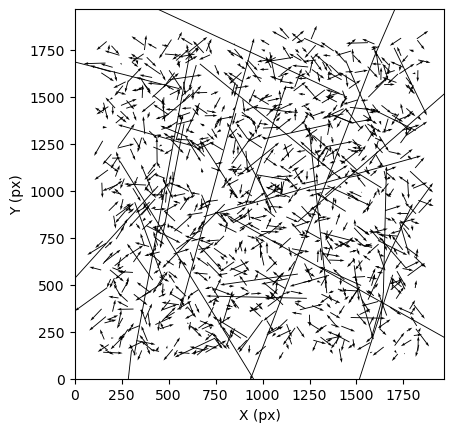

In [30]:
plt.axes().set_aspect('equal')
plt.quiver(xc_array[:,2], xc_array[:,3], dx0, dy0,
               angles='xy', scale_units='xy', scale=0.0003)
plt.xlabel('X (px)')
plt.ylabel('Y (px)')
plt.xlim([0, 1968])
plt.ylim([0, 1968])
plt.show()

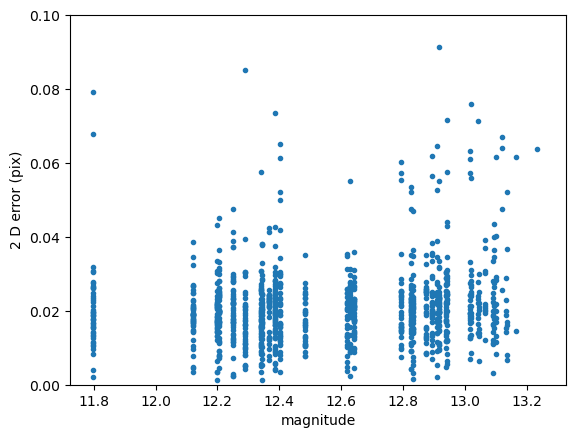

In [31]:
plt.scatter(xc_array[:, 4],  dist, marker='.')
plt.ylim([0.0,0.1])
plt.xlabel('magnitude')
plt.ylabel('2 D error (pix)')
plt.show()

### Apply pixel size of 472 mas/pix

In [32]:
pixmas = 472.0

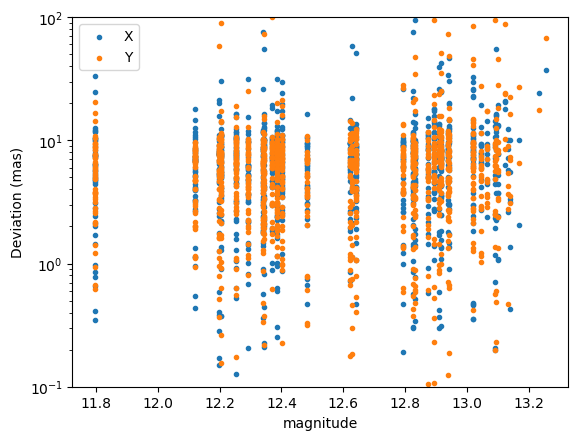

 N star (<4 mas) = 74


In [33]:
plt.scatter(xc_array[:, 4], np.fabs(dx0)*pixmas, marker='.', label='X')
plt.scatter(xc_array[:, 4], np.fabs(dy0)*pixmas, marker='.', label='Y')
plt.ylim([0.1,100.0])
plt.xlabel('magnitude')
plt.ylabel('Deviation (mas)')
plt.yscale('log')
plt.legend()
plt.show()
distmas = dist*pixmas
print(' N star (<4 mas) =', len(distmas[distmas<4.0]))

### make a new star table for ePSF fit from the well fitted stars

In [34]:
distlim = 0.03
goodstars_tbl = Table()
goodstars_tbl['x'] = np.round(xc_array[dist<distlim,2]).astype('int')
goodstars_tbl['y'] = np.round(xc_array[dist<distlim,3]).astype('int')

In [35]:
print(goodstars_tbl)

 x    y  
---- ----
 322  125
 651  125
 634  128
1720  132
 611  135
1756  137
 325  139
 ...  ...
 549 1804
1221 1806
1128 1808
1259 1808
1821 1810
1141 1813
1738 1814
Length = 951 rows


In [36]:
# Extracting stellar images.
ext_size  = 9
nddata_sel = NDData(data=data)
print(nddata_sel.data.shape)
stars_sel = extract_stars(nddata_sel, goodstars_tbl, size=ext_size)

(1968, 1968)


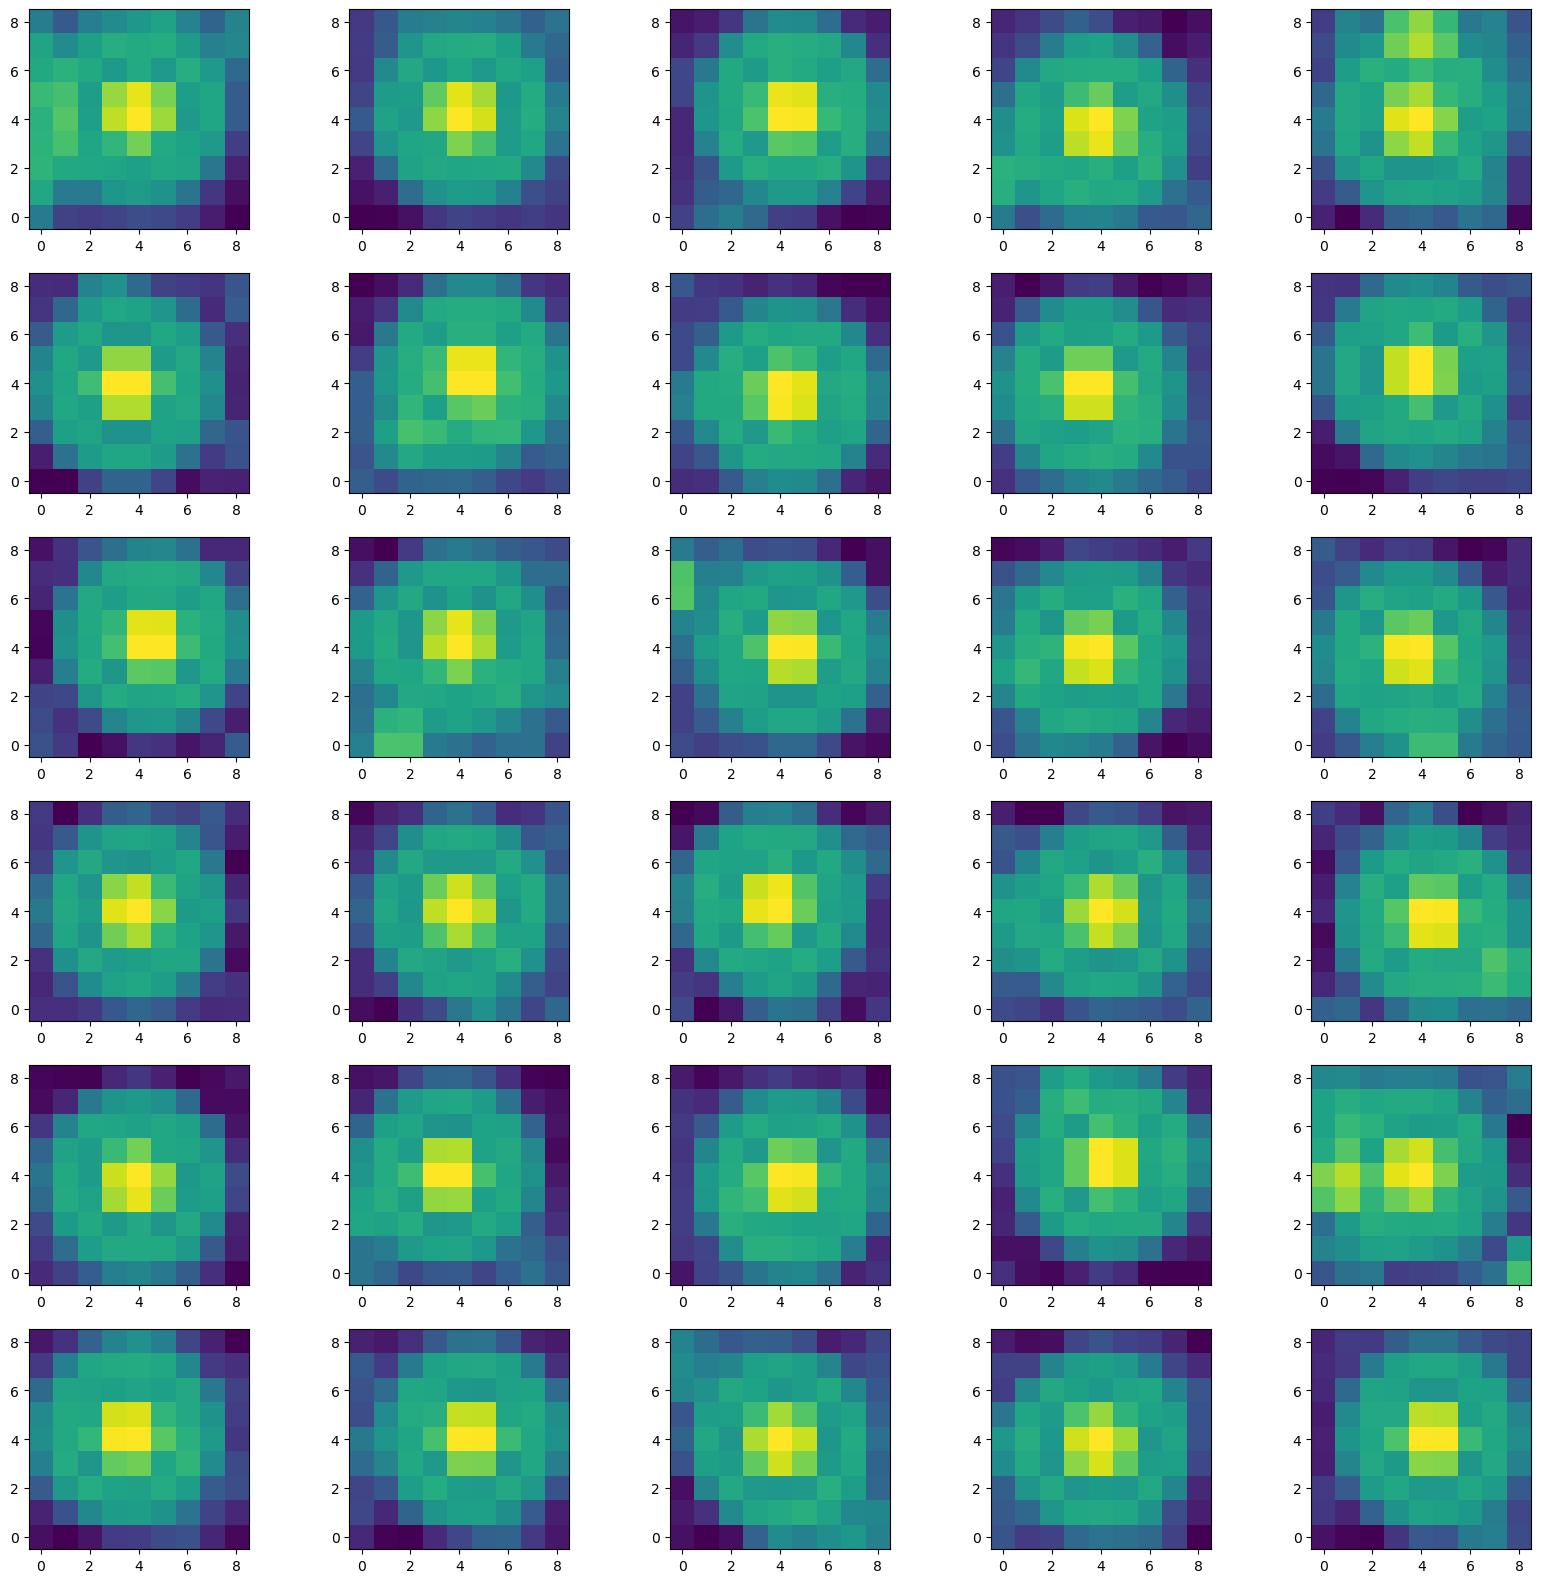

In [37]:
nrows = 6
ncols = 5
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 20), squeeze=True)
ax = ax.ravel()
for i in range(nrows*ncols):
    norm_sel = simple_norm(stars_sel[i], 'log', percent=99.)
    ax[i].imshow(stars_sel[i], norm=norm_sel, origin='lower', cmap='viridis')
plt.show()

### Make ePSF

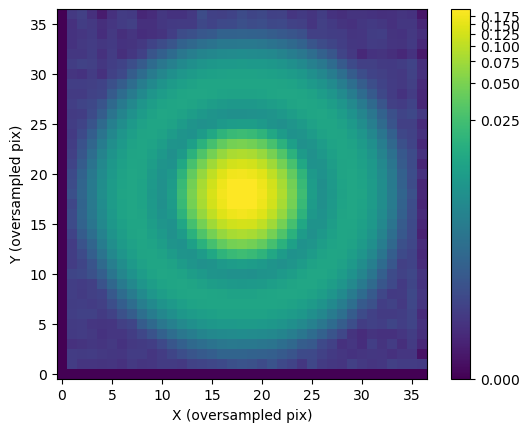

In [38]:
# Making ePSF.
n_oversample = 4 # Number of oversampling for ePSF.
n_maxiter    = 3 # Max. number of iteration for making ePSF.
norm_radius  = 5.5 # Number of undersampled pixels which determines the radius for flux normalization of ePSF.
recentering_boxsize = 5 #  Number of undersampled pixels which determines the box size for ePSF recentering calculation.

epsf_builder_sel = EPSFBuilder(oversampling=n_oversample,
                           maxiters=n_maxiter, progress_bar=False,
                           norm_radius=norm_radius, recentering_boxsize=recentering_boxsize,
                           center_accuracy=0.001)
epsf_sel, fitted_stars_sel = epsf_builder_sel(stars_sel)
norm_sel = simple_norm(epsf_sel.data, 'log', percent=99.)
    
plt.imshow(epsf_sel.data, norm=norm_sel, origin='lower', cmap='viridis')
plt.xlabel('X (oversampled pix)')
plt.ylabel('Y (oversampled pix)')
plt.colorbar()
plt.show()

number of stars brighter than  12.5 = 585


(200.0, 400.0)

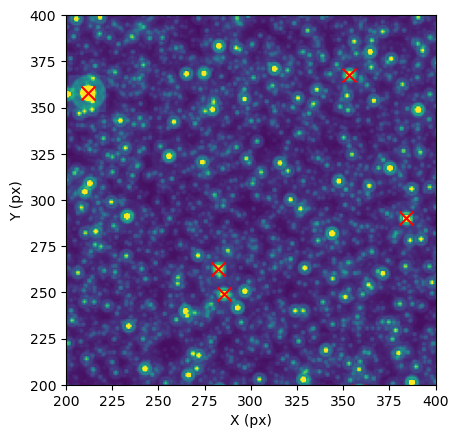

In [39]:
# Subtracting background.
maglimit = 12.5
norm_sel = simple_norm(data, 'sqrt', percent=99.)
print('number of stars brighter than ', maglimit, '=', len(original[original[:,6]<maglimit, 2]))
plt.imshow(data, norm=norm_sel, origin='lower', cmap='viridis')
plt.scatter(original[original[:, 6]<maglimit, 3]-1, original[original[:,6]<maglimit, 2]-1, s=100, c='red', marker='x')
plt.xlabel('X (px)')
plt.ylabel('Y (px)')
plt.xlim(200, 400)
plt.ylim(200, 400)


In [40]:
# Cross-matching the data.
xc_sel_array = []
maglim_o = maglimit+1.0
# search stars only for brighter stars
stars_sel_list = original[original[:, 6] < maglim_o]
print(np.shape(stars_sel_list))

# for loop for fitted stars
nfitted_stars_sel = len(fitted_stars_sel.center_flat[:, 0])
print(' N fitted stars=', np.shape(fitted_stars_sel.center_flat), nfitted_stars_sel)
print(' fitted_stars.center_flat', np.shape(fitted_stars_sel.center_flat[0]))
for i in range(nfitted_stars_sel):
    xdiff = fitted_stars_sel.center_flat[i, 0]-stars_sel_list[:, 3]+1.0
    ydiff = fitted_stars_sel.center_flat[i, 1]-stars_sel_list[:, 2]+1.0
    dist2 = xdiff**2+ydiff**2
    # closest
    mindx = np.argmin(dist2)
    # print(' indx, dist, x, y s, f=', mindx, dist2[mindx], o[3]-1.0, o[2]-1.0, fitted_stars.center_flat[mindx])
    # print(dist2[mindx], stars_list[mindx, 3]-1.,stars_list[mindx, 2]-1.,fitted_stars.center_flat[i, 0], fitted_stars.center_flat[i, 1])
    xc_sel_array.append([stars_sel_list[mindx, 3]-1.,stars_sel_list[mindx, 2]-1.,      # 1-origin -> 0-origin
                             fitted_stars_sel.center_flat[i, 0],
                             fitted_stars_sel.center_flat[i, 1],  stars_sel_list[mindx, 6]])
    if dist2[mindx]>0.6: 
        print(' star ', i, ' min dist =', np.sqrt(dist2[mindx]), stars_sel_list[mindx, 6])
        plt.imshow(data, norm=norm_sel, origin='lower', cmap='viridis')
        plt.scatter(fitted_stars_sel.center_flat[i, 0], fitted_stars_sel.center_flat[i, 1], s=100, c='blue', marker='+')
        plt.scatter(original[original[:, 6]<maglim_o, 3]-1, original[original[:,6]<maglim_o, 2]-1, s=100, c='red', marker='x')
        plt.xlabel('X (px)')
        plt.ylabel('Y (px)')
        plt.xlim(fitted_stars_sel.center_flat[i, 0]-5.0, fitted_stars_sel.center_flat[i, 0]+5.0)
        plt.ylim(fitted_stars_sel.center_flat[i, 1]-5.0, fitted_stars_sel.center_flat[i, 1]+5.0)
        plt.show()
xc_sel_array = np.array(xc_sel_array)
print(' number of stars brighter than ', maglim_o, ' in the list =', len(xc_sel_array))

(1990, 7)
 N fitted stars= (951, 2) 951
 fitted_stars.center_flat (2,)
 number of stars brighter than  13.5  in the list = 951


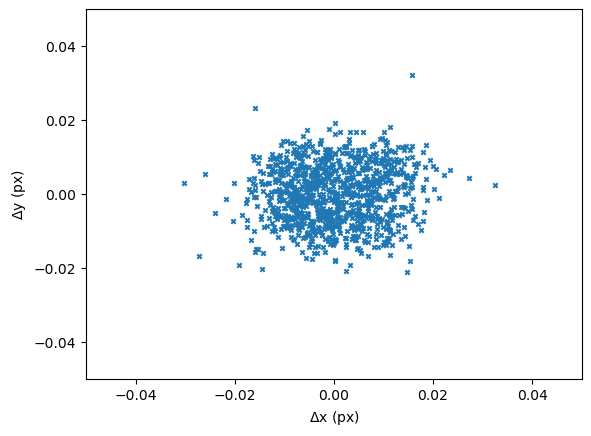

 number of stars fitted = 951
 mean error for dist (pix) = 0.010846110554134024
 std error for dist (pix) = 0.00497015239263293
 mean error for dist (mas) = 5.119364181551259
 std error for dist (mas) = 2.345911929322743


In [41]:
# Making dx/dy data.
dx_sel = xc_sel_array[:,2] - xc_sel_array[:,0]
dy_sel = xc_sel_array[:,3] - xc_sel_array[:,1]
dx0_sel = dx_sel - np.mean(dx_sel)
dy0_sel = dy_sel - np.mean(dy_sel)
dx_mean_sel = np.mean(dx_sel)
dy_mean_sel = np.mean(dy_sel)
dist_sel = np.sqrt(dx0_sel**2+dy0_sel**2)
plt.scatter(dx0_sel, dy0_sel, s=10, marker='x')
plt.xlabel('$\Delta$x (px)')
plt.ylabel('$\Delta$y (px)')
plt.xlim([-0.05, 0.05])
plt.ylim([-0.05, 0.05])
plt.show()
print(' number of stars fitted =', len(dist_sel))
print(' mean error for dist (pix) =', np.mean(dist_sel))
print(' std error for dist (pix) =', np.std(dist_sel))
print(' mean error for dist (mas) =', np.mean(dist_sel)*pixmas)
print(' std error for dist (mas) =', np.std(dist_sel)*pixmas)

In [42]:
# 1D error
print(' dx std (pix)=', np.std(dx0_sel))
print(' dy std (pix)=', np.std(dy0_sel))
print(' dx std (mas)=', np.std(dx0_sel)*pixmas)
print(' dy std (mas) =', np.std(dy0_sel)*pixmas)

 dx std (pix)= 0.008873283527058356
 dy std (pix)= 0.007975297386739074
 dx std (mas)= 4.188189824771544
 dy std (mas) = 3.764340366540843


### 2D error

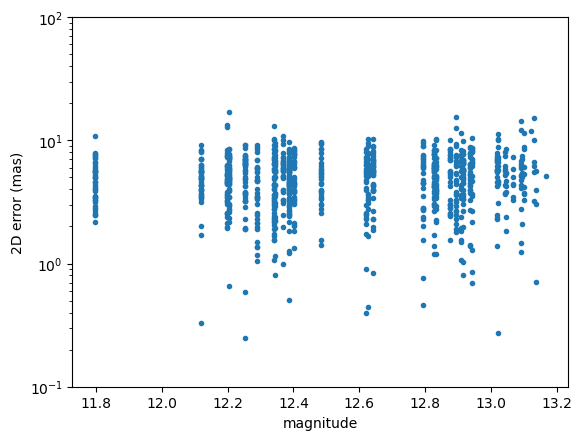

In [43]:
pixmas = 472.0
plt.scatter(xc_sel_array[:, 4], dist_sel*pixmas, marker='.')
plt.ylim([0.1,100.0])
plt.xlabel('magnitude')
plt.ylabel('2D error (mas)')
plt.yscale('log')
plt.show()

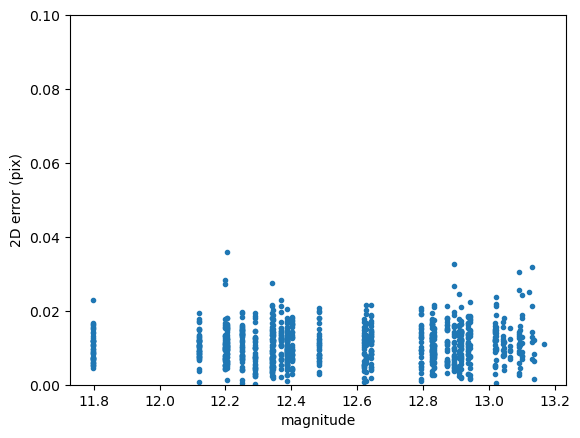

In [44]:
plt.scatter(xc_sel_array[:, 4], dist_sel, marker='.')
plt.ylim([0.0,0.1])
plt.xlabel('magnitude')
plt.ylabel('2D error (pix)')
plt.show()

### 1D error

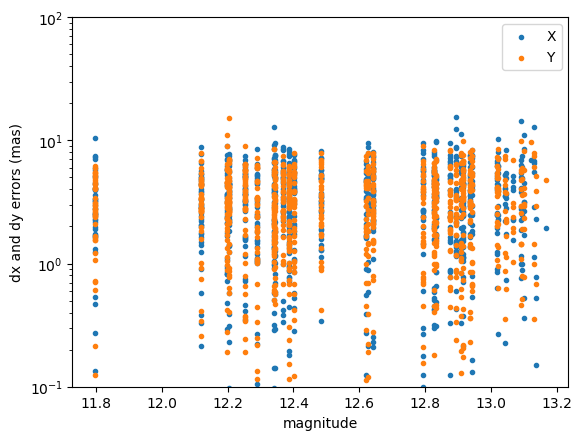

In [45]:
plt.scatter(xc_sel_array[:, 4], np.fabs(dx0_sel)*pixmas, marker='.', label='X')
plt.scatter(xc_sel_array[:, 4], np.fabs(dy0_sel)*pixmas, marker='.', label='Y')
plt.ylim([0.1,100.0])
plt.xlabel('magnitude')
plt.ylabel('dx and dy errors (mas)')
plt.yscale('log')
plt.legend()
plt.show()

### Examples of bad cases

 star  0  dist= 0.49330167684725534


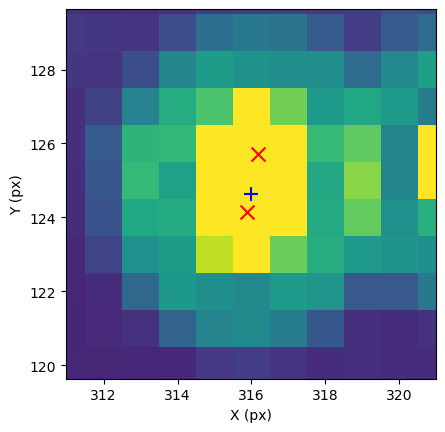

 star  9  dist= 0.038420745416778486


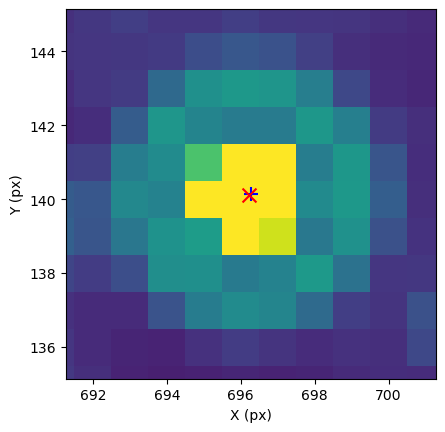

 star  10  dist= 0.031048619060625088


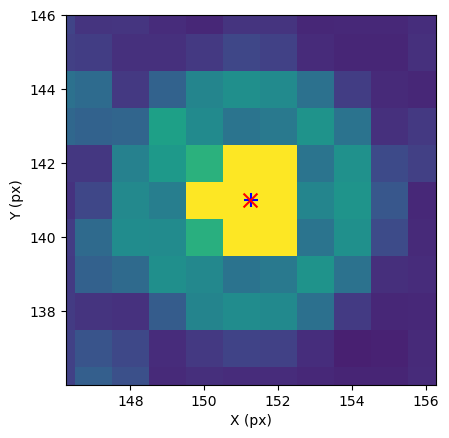

 star  17  dist= 0.1820331356716344


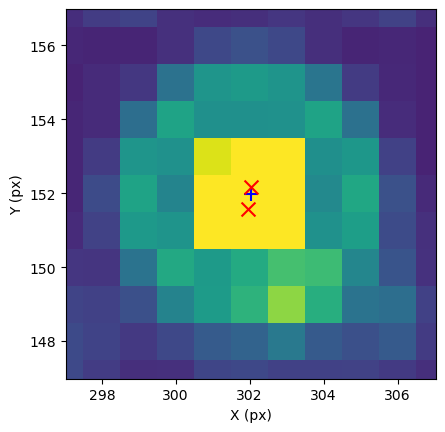

 star  51  dist= 0.0308412210265961


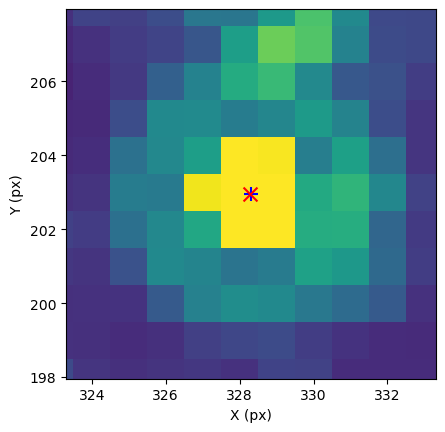

 star  61  dist= 0.1040957095314624


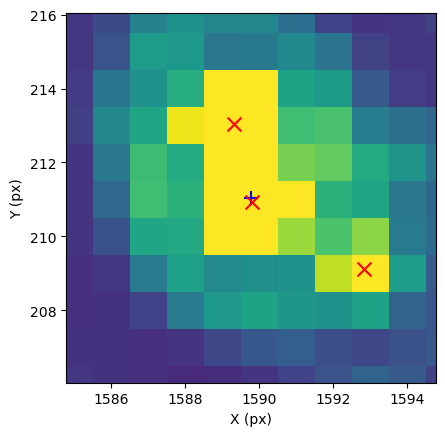

 star  67  dist= 0.07156987132768321


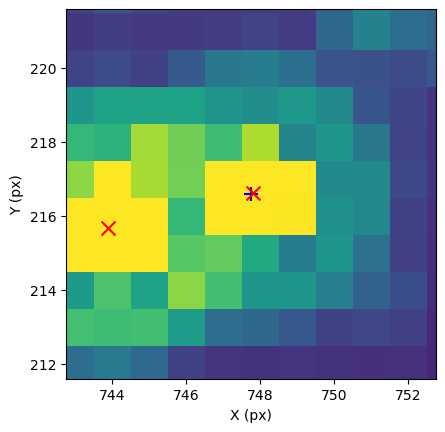

 star  68  dist= 0.06452271345196516


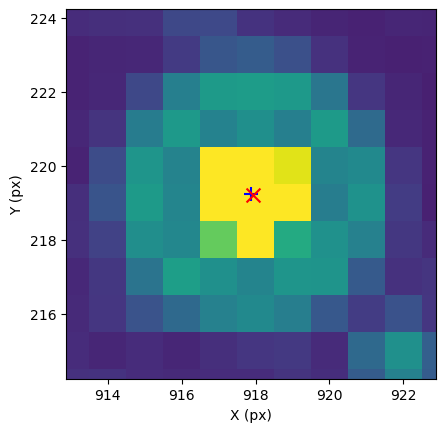

 star  75  dist= 0.03177897132406736


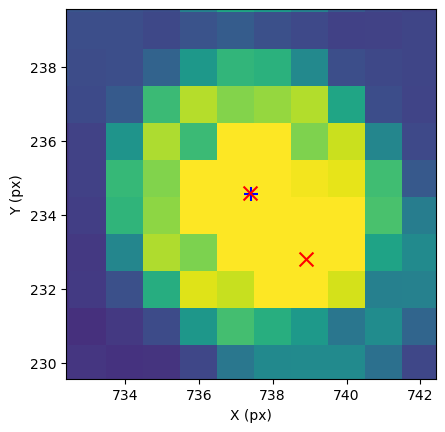

 star  91  dist= 0.03524714061415529


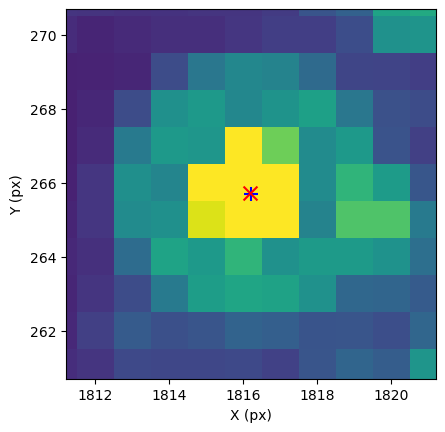

 star  95  dist= 0.033506976800934875


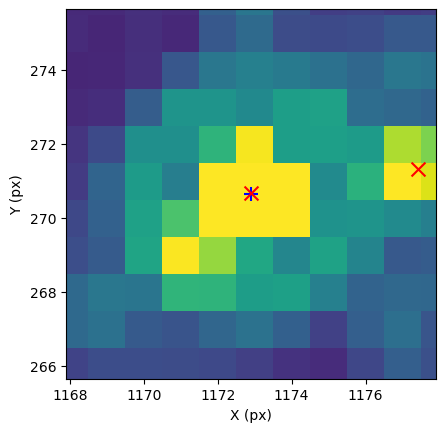

 star  109  dist= 0.030075104273866955


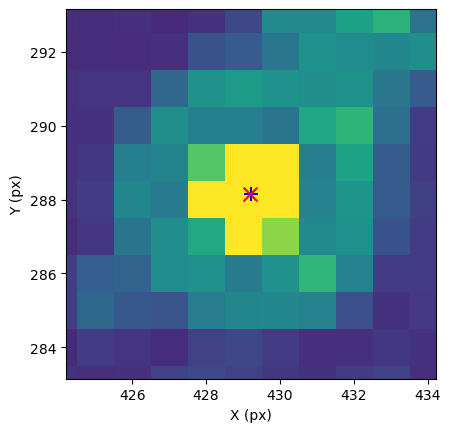

 star  117  dist= 0.05271635801782175


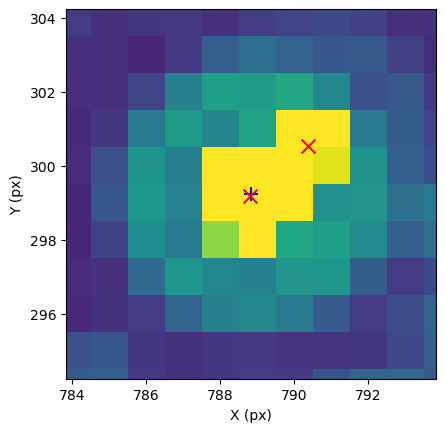

 star  120  dist= 0.030874899986704944


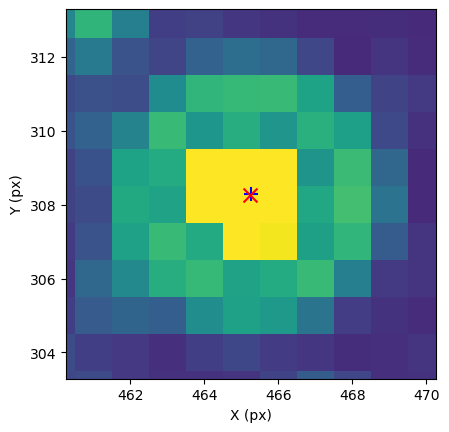

 star  124  dist= 0.064042643231368


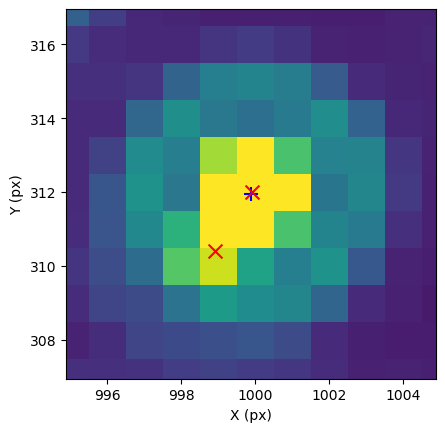

 star  129  dist= 0.055266411111348425


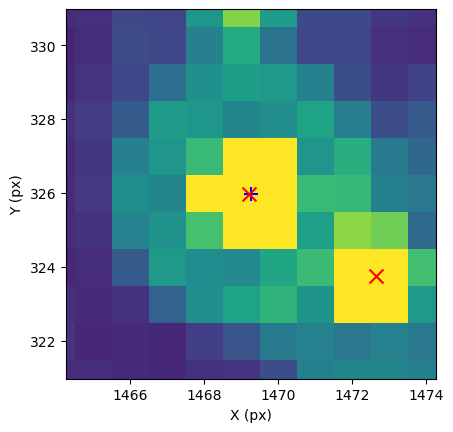

 star  130  dist= 0.034853053935212444


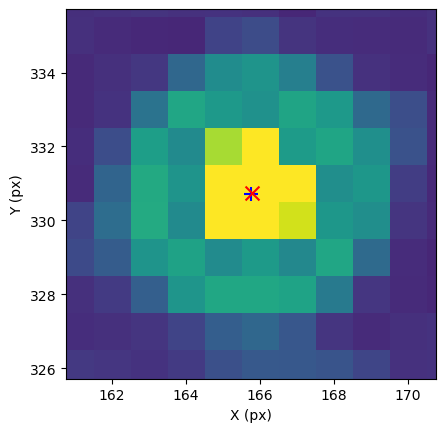

 star  132  dist= 0.039234810087636136


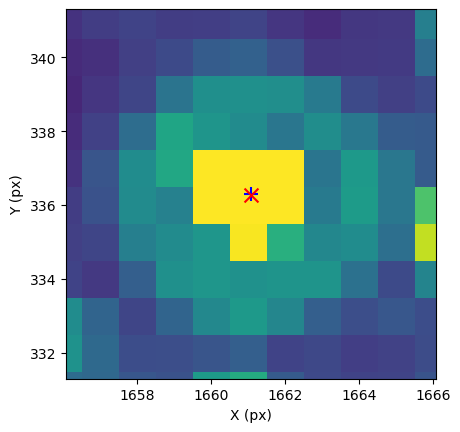

 star  148  dist= 0.03752573327717611


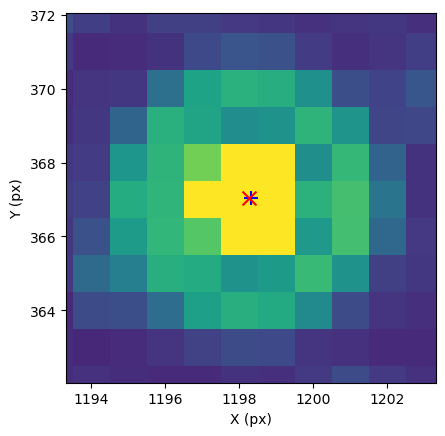

 star  151  dist= 0.4489393201636318


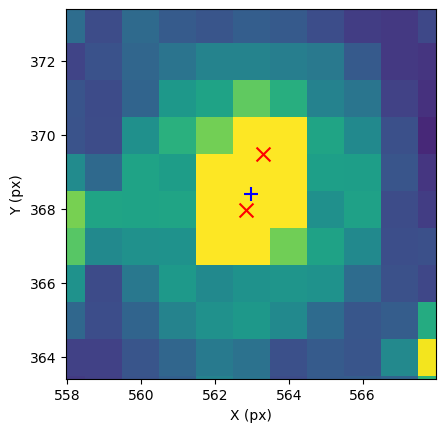

 star  165  dist= 0.03016264011717422


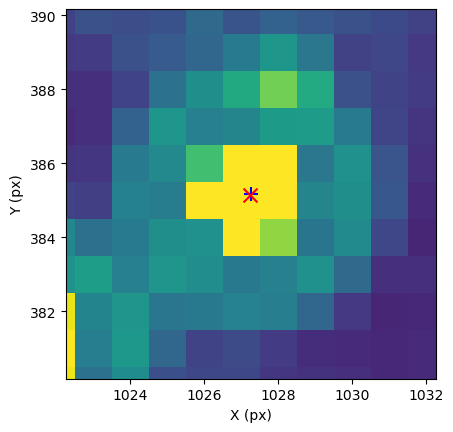

 star  169  dist= 0.030777921465816017


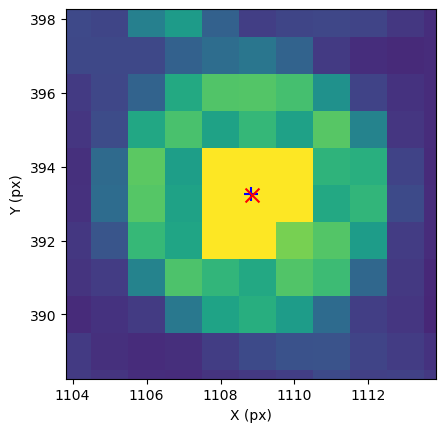

 star  180  dist= 0.0616737870427594


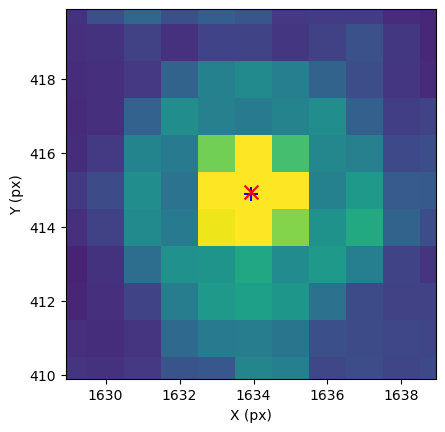

 star  183  dist= 0.16900262091482715


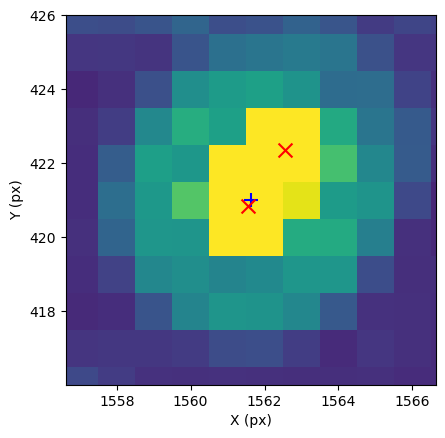

 star  190  dist= 0.16071610440670933


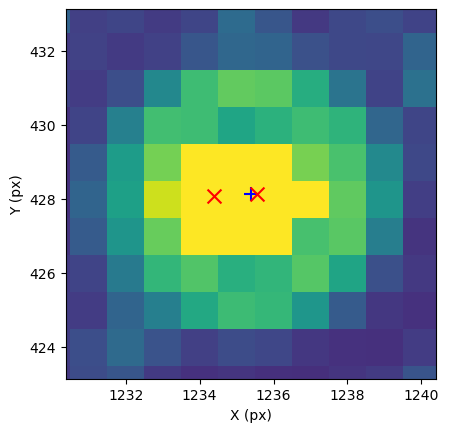

 star  198  dist= 0.03932728253920395


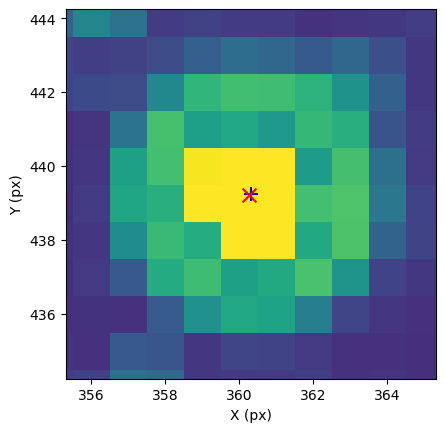

 star  207  dist= 0.033517652314739375


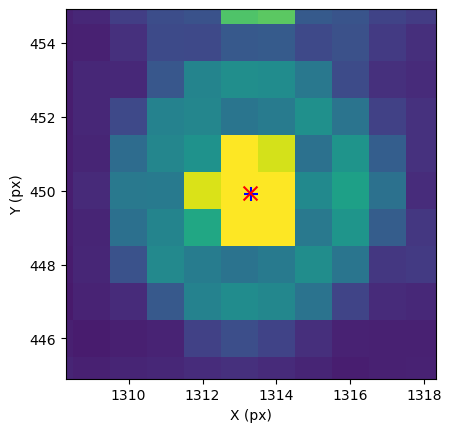

 star  211  dist= 0.26733826941844435


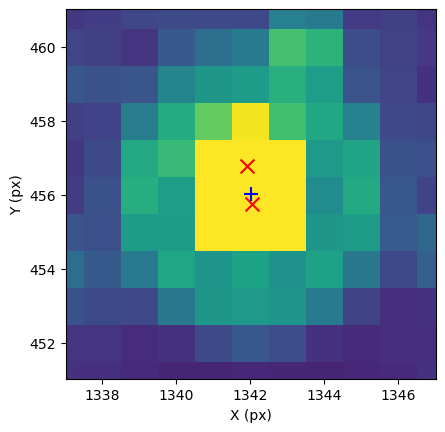

 star  212  dist= 0.202627280562144


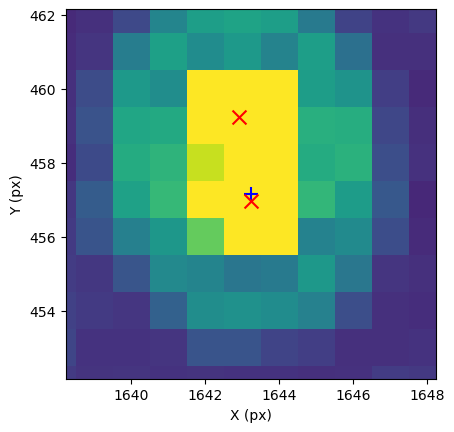

 star  216  dist= 0.06017145094074614


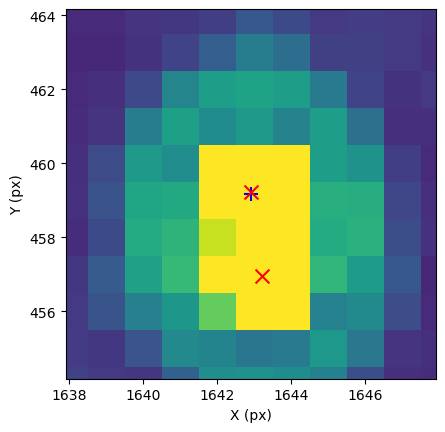

 star  232  dist= 0.057223290888844446


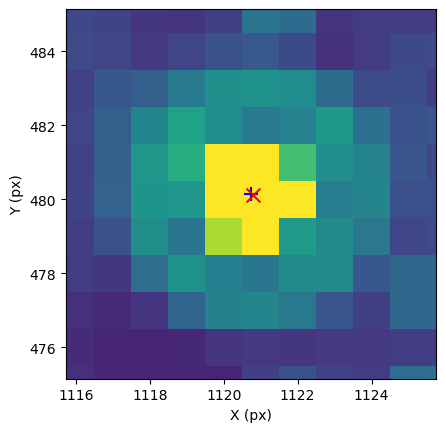

 star  237  dist= 0.06377283796676494


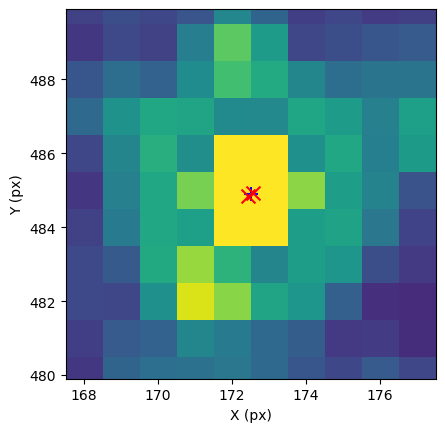

 star  249  dist= 0.07354015021730916


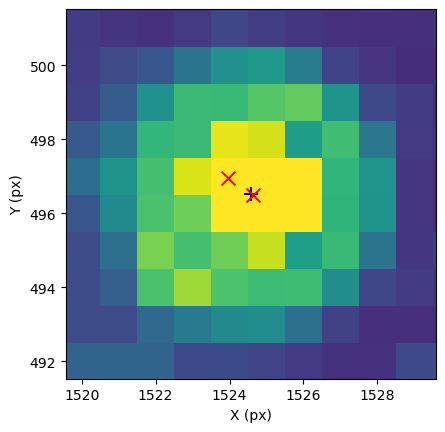

 star  259  dist= 0.07136443780607853


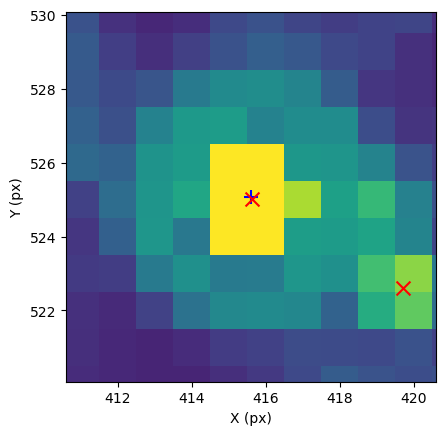

 star  266  dist= 0.04330204188841308


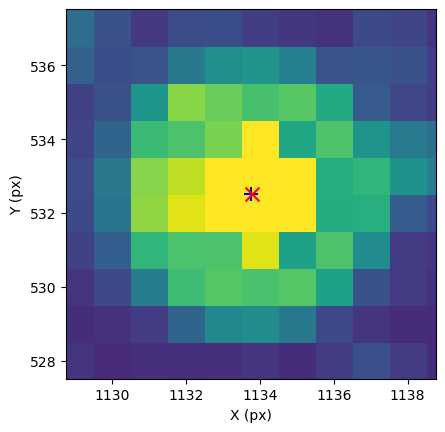

 star  274  dist= 0.034545222542209514


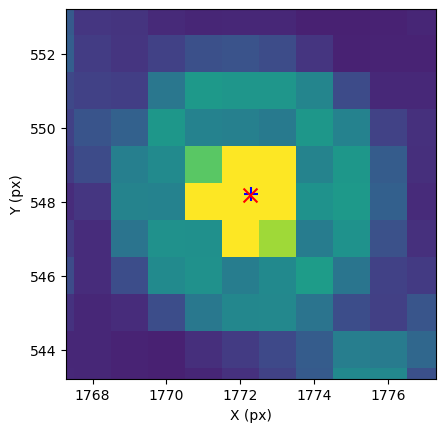

 star  275  dist= 0.06512248682837178


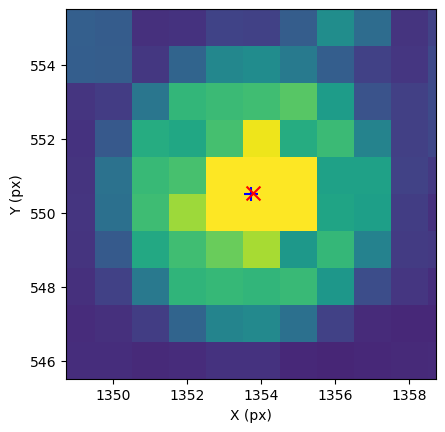

 star  276  dist= 0.27506571404514757


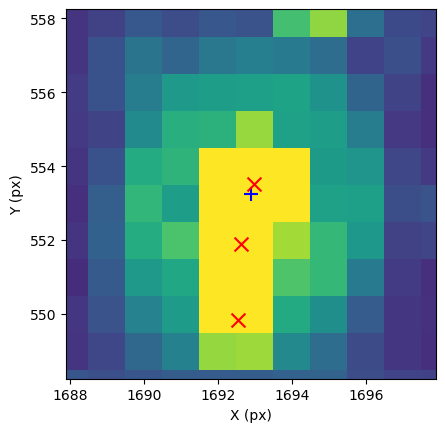

 star  277  dist= 0.035343248830146445


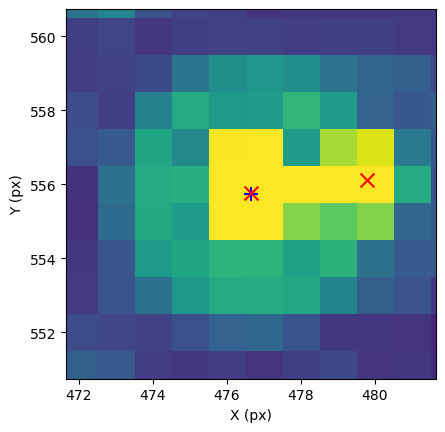

 star  278  dist= 0.12542095497700612


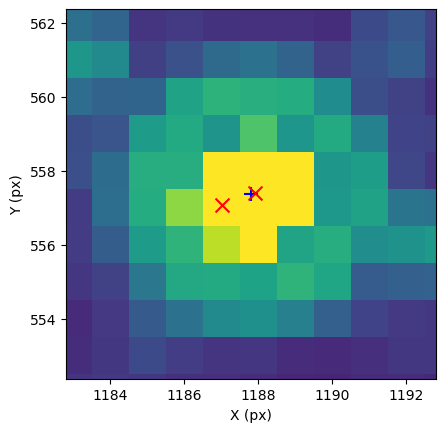

 star  289  dist= 0.03449284422911309


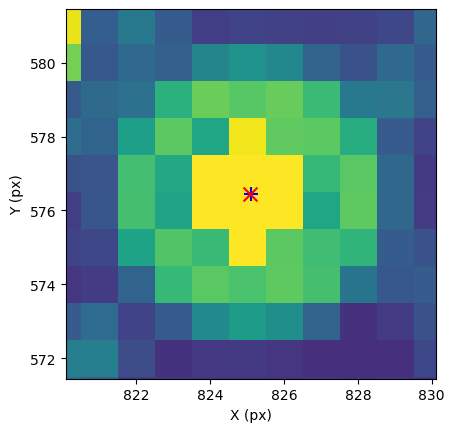

 star  291  dist= 0.03672597195092819


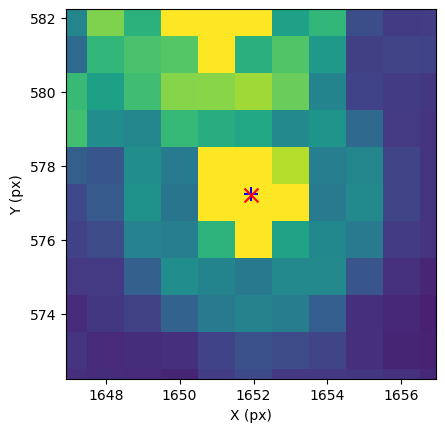

 star  297  dist= 0.06689927794833861


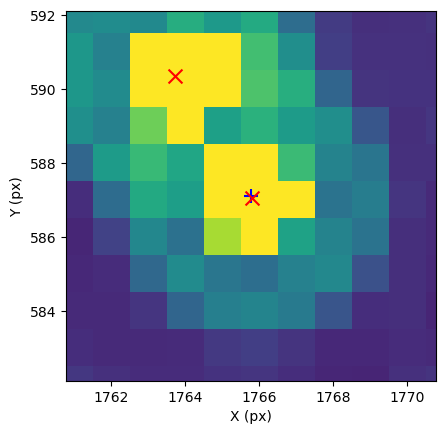

 star  306  dist= 0.030607315522571524


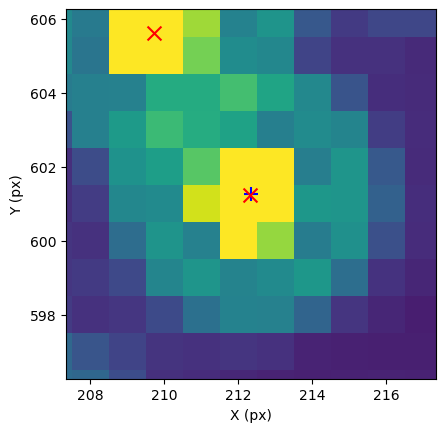

 star  309  dist= 0.05722780936747557


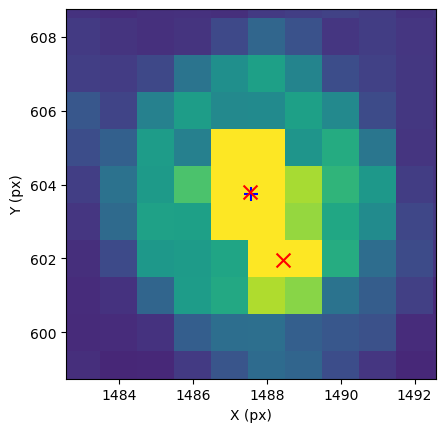

 star  318  dist= 0.033215704034053536


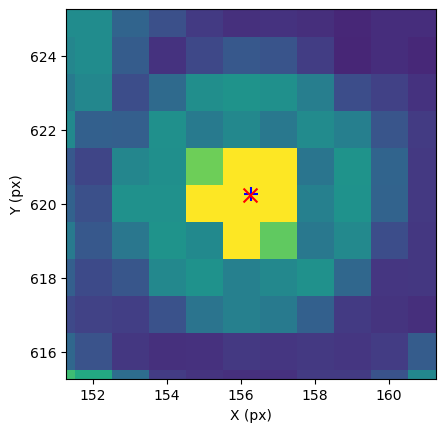

 star  319  dist= 0.03516348431101923


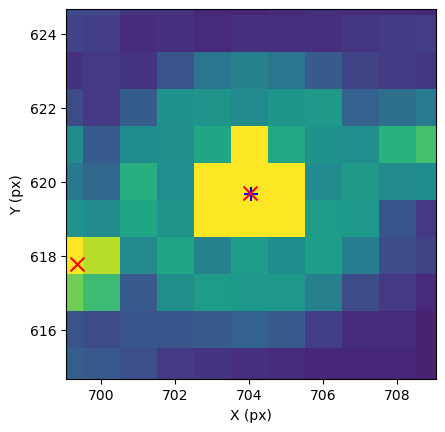

 star  381  dist= 0.05653573904343924


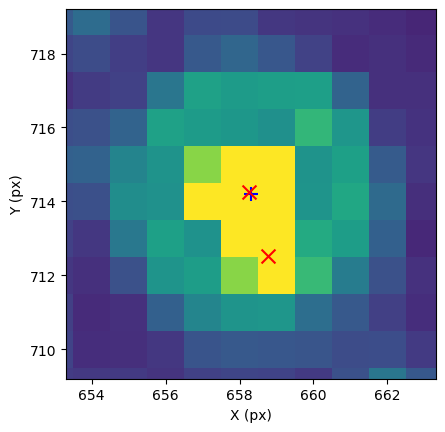

 star  384  dist= 0.03496429543765508


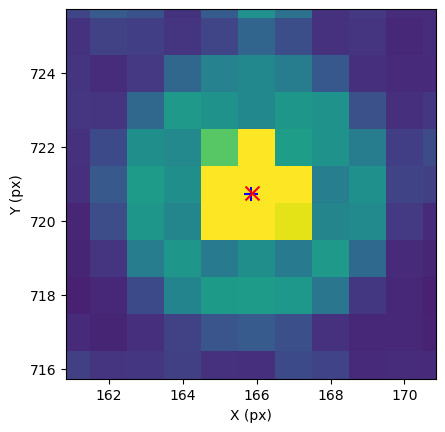

 star  392  dist= 0.052250405047456726


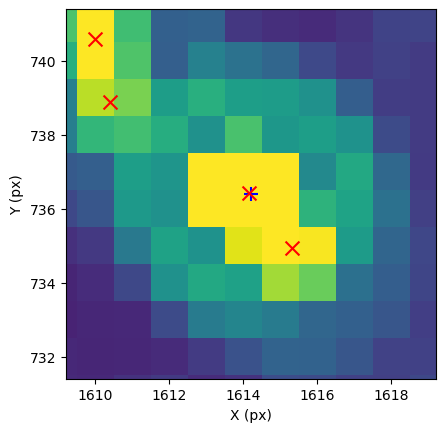

 star  398  dist= 0.030051810664440494


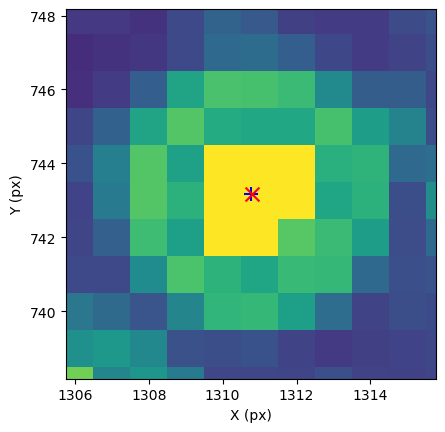

 star  405  dist= 0.031068295030762205


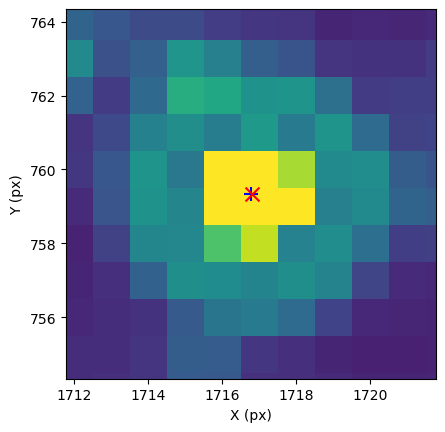

 star  419  dist= 0.05762463271986457


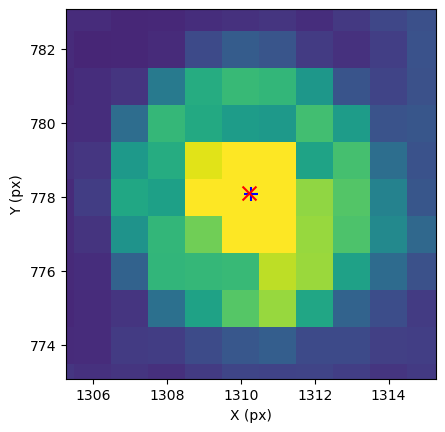

 star  420  dist= 0.03292331310718255


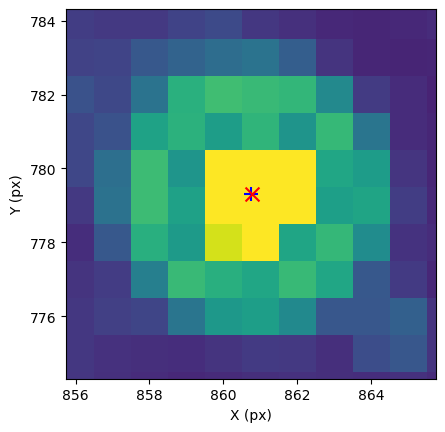

 star  425  dist= 0.03886076120693692


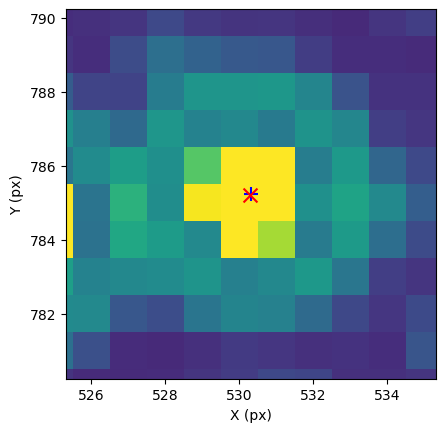

 star  437  dist= 0.0912672832235957


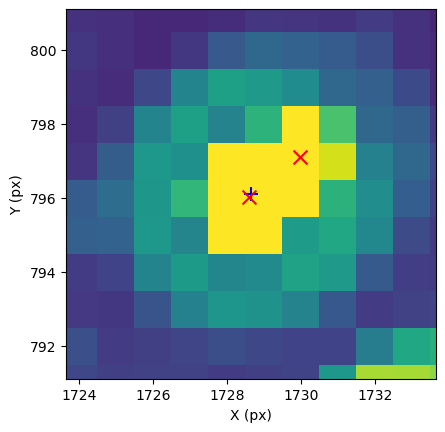

 star  442  dist= 0.030137162098474723


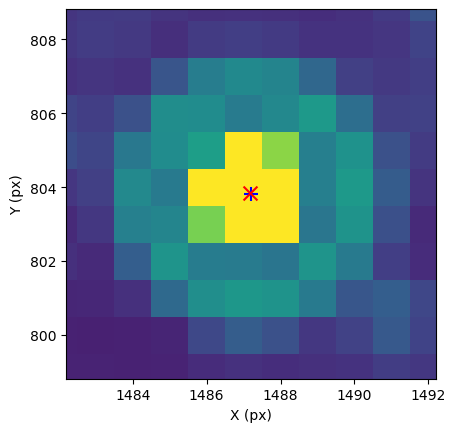

 star  448  dist= 0.06106023063886148


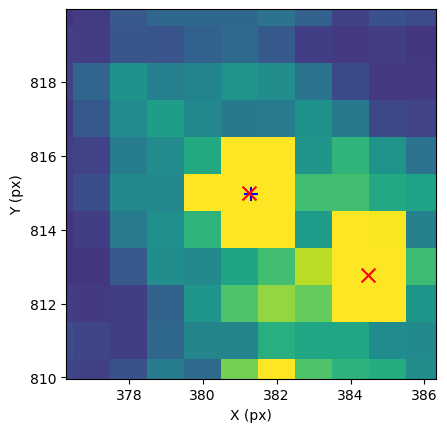

 star  450  dist= 0.03268154567448066


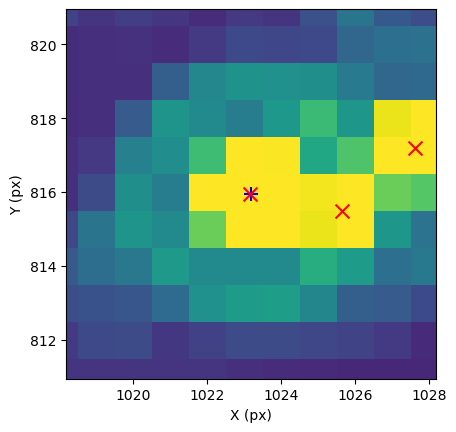

 star  459  dist= 0.030478515599612534


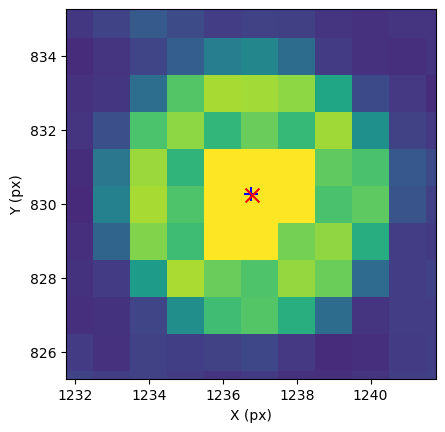

 star  463  dist= 0.055098104420760866


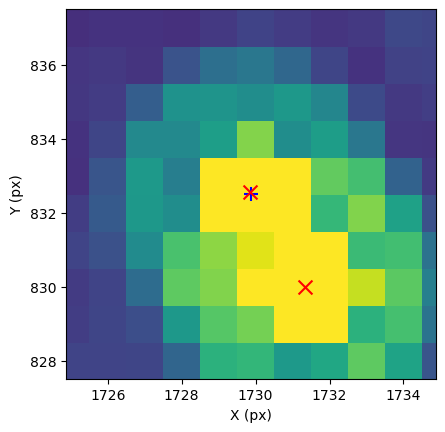

 star  464  dist= 0.5297831215729494


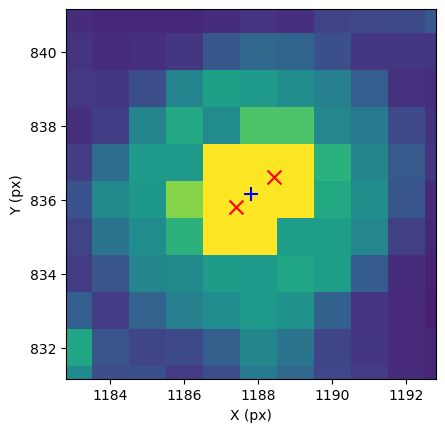

 star  476  dist= 0.4303400950638614


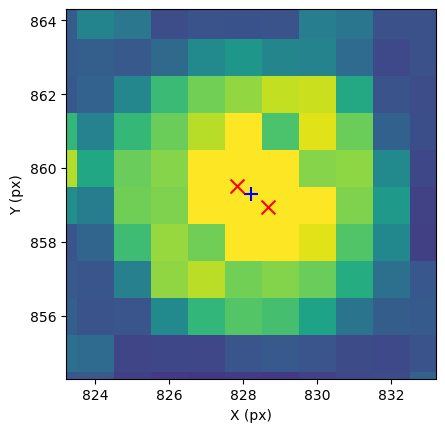

 star  482  dist= 0.3604999762508746


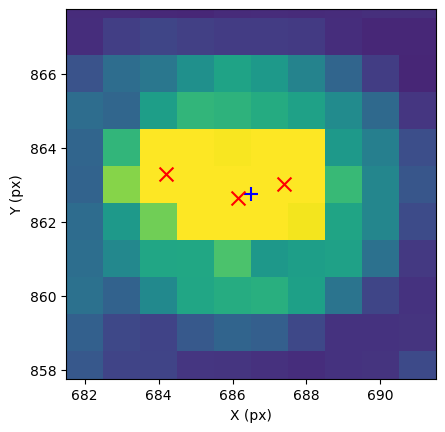

 star  483  dist= 0.03188934473011473


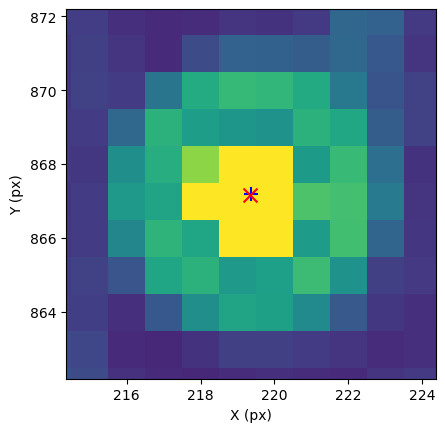

 star  493  dist= 0.16435026827206162


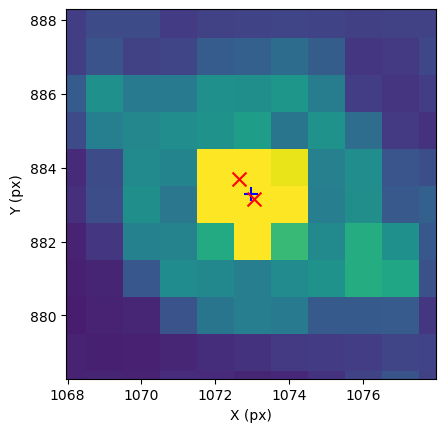

 star  494  dist= 0.031550453439544233


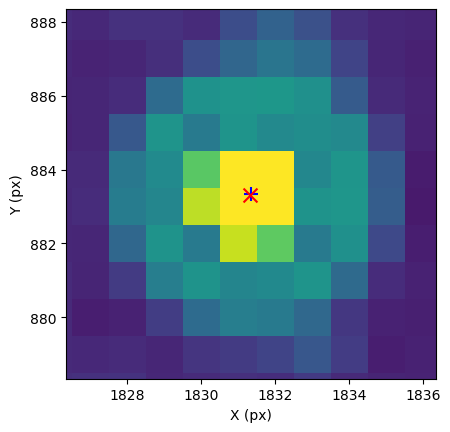

 star  501  dist= 0.05522421166974062


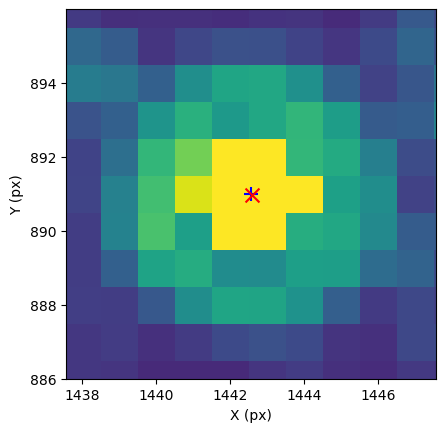

 star  516  dist= 0.20040684386426044


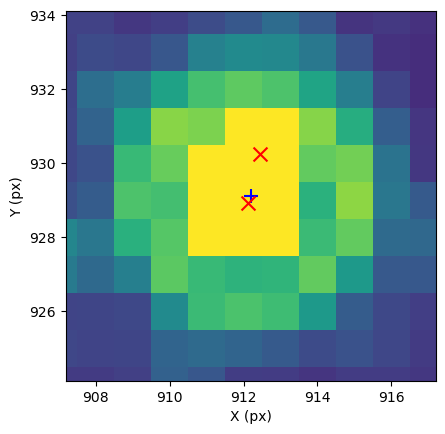

 star  518  dist= 0.14266318541262332


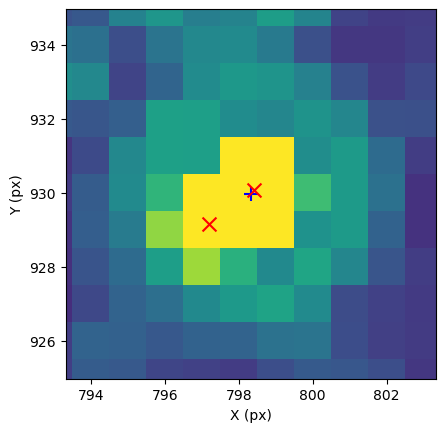

 star  526  dist= 0.13087937958848467


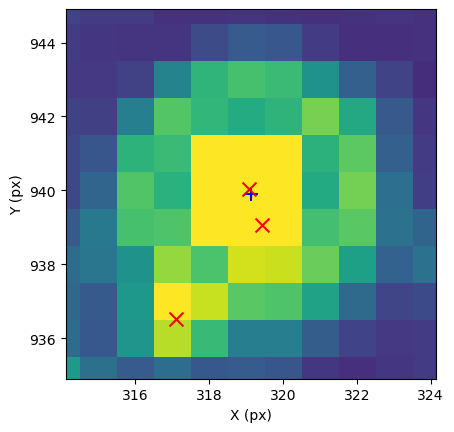

 star  538  dist= 0.06140533993471583


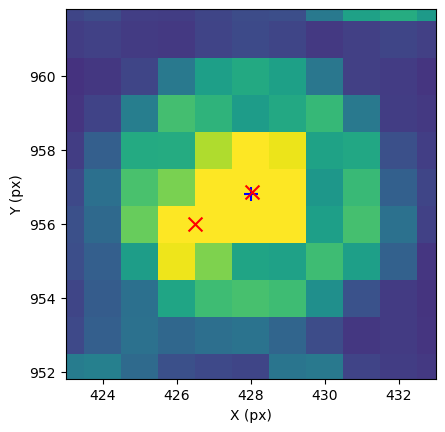

 star  548  dist= 0.04232445122013287


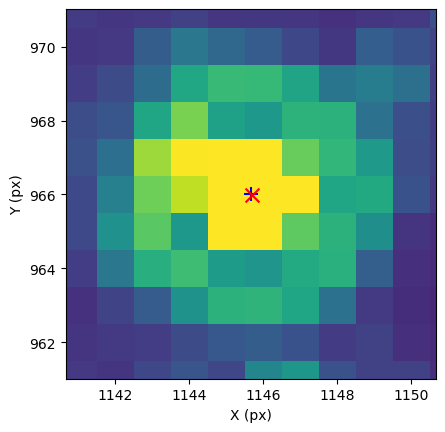

 star  558  dist= 0.1026800791212223


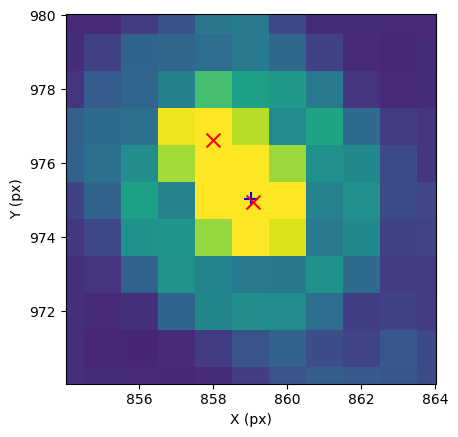

 star  572  dist= 0.04743567686690822


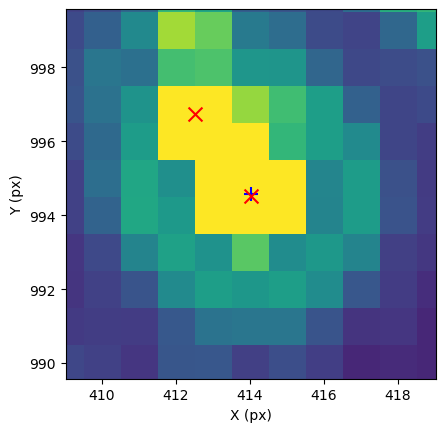

 star  582  dist= 0.038513594352375786


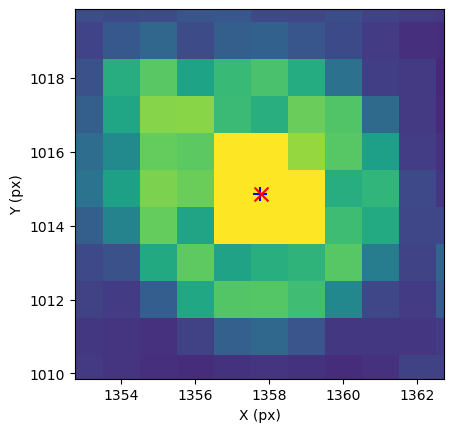

 star  586  dist= 0.05586712500704257


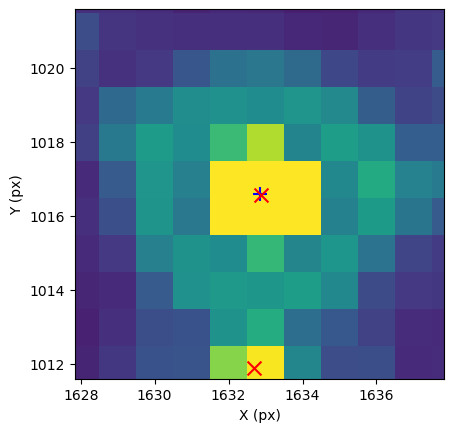

 star  592  dist= 0.673967429101399


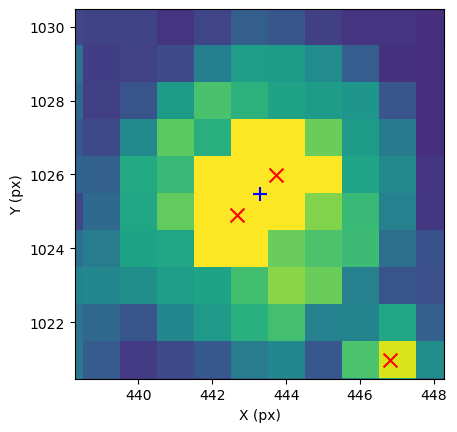

 star  593  dist= 0.07590718899788844


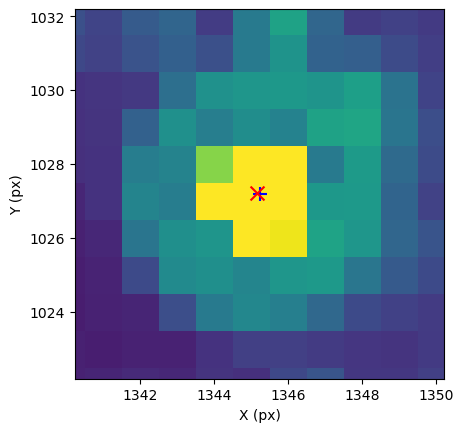

 star  594  dist= 0.034979280907541946


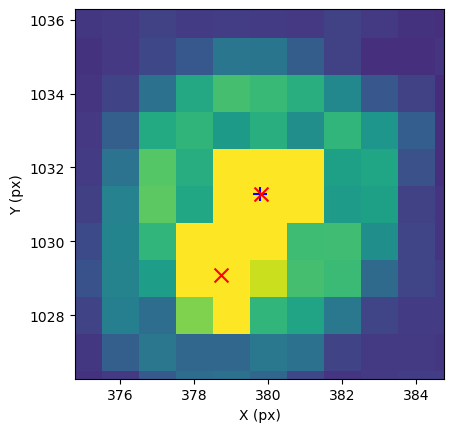

 star  614  dist= 0.030678417901838298


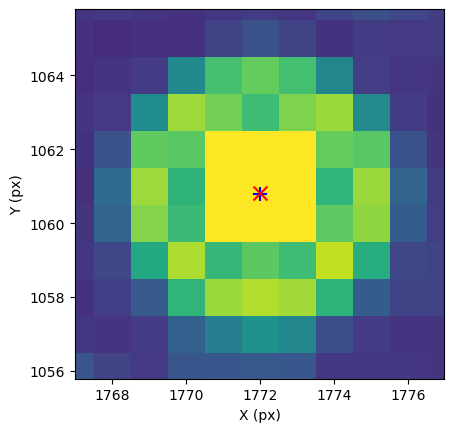

 star  617  dist= 0.03506698206965623


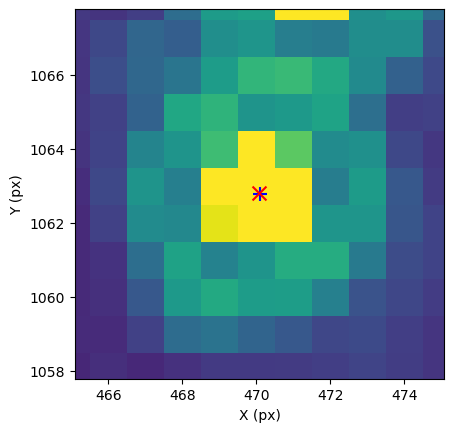

 star  627  dist= 0.03558609783743507


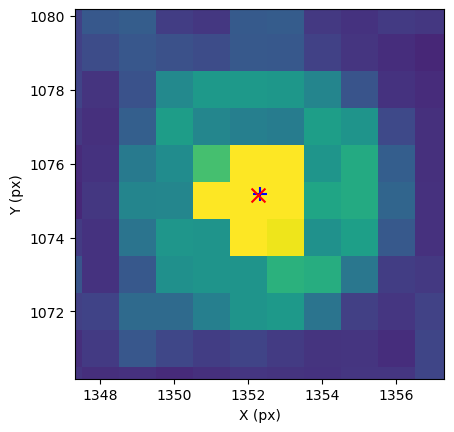

 star  630  dist= 0.08518908003074585


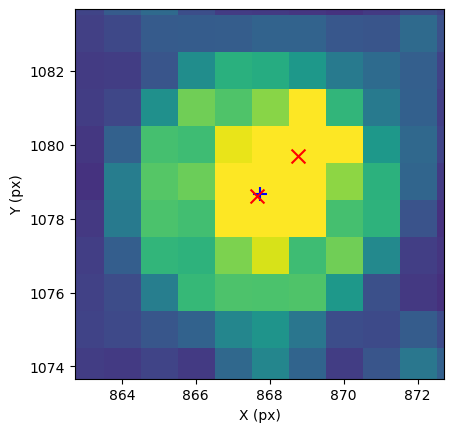

 star  633  dist= 0.052116247610094396


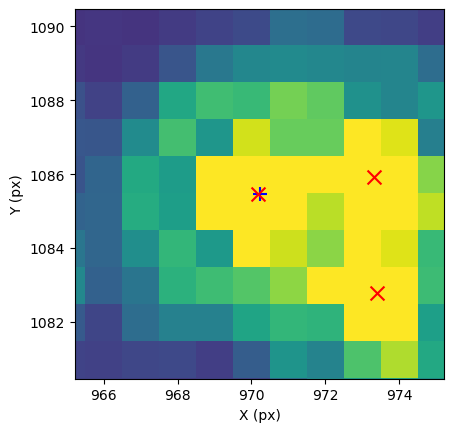

 star  634  dist= 0.061646839855492894


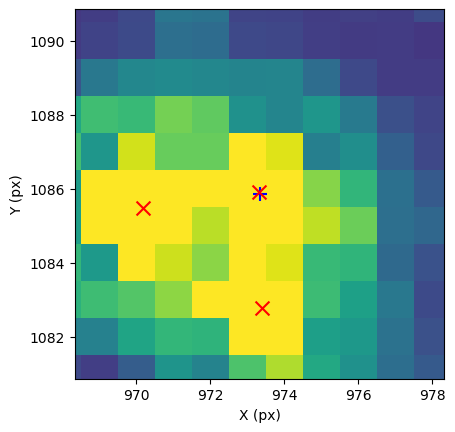

 star  643  dist= 0.05005133846686847


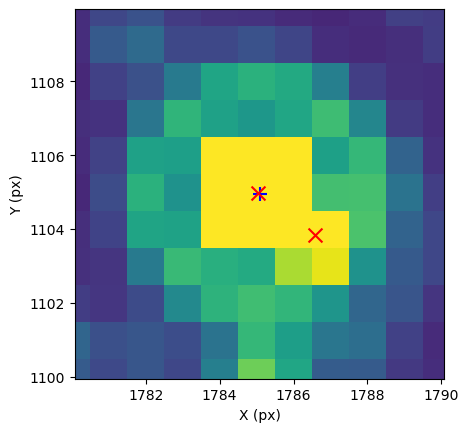

 star  650  dist= 0.03460223757785052


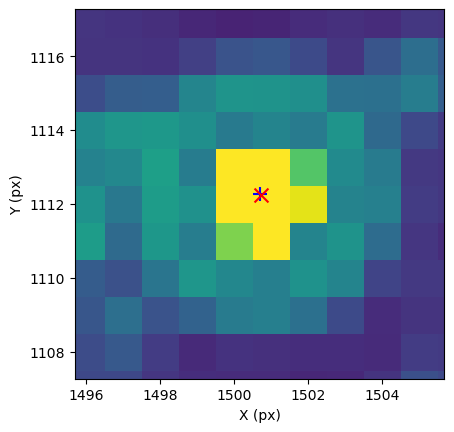

 star  666  dist= 0.04254219521030126


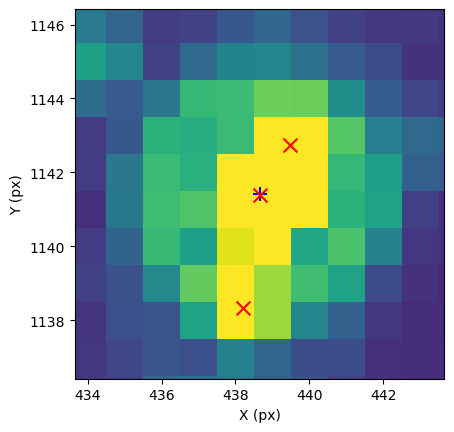

 star  669  dist= 0.061858684210877174


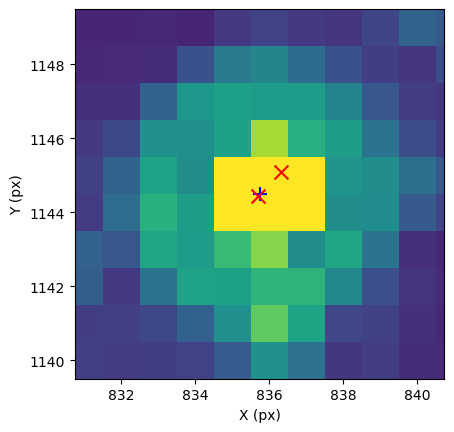

 star  676  dist= 0.6011191402344015


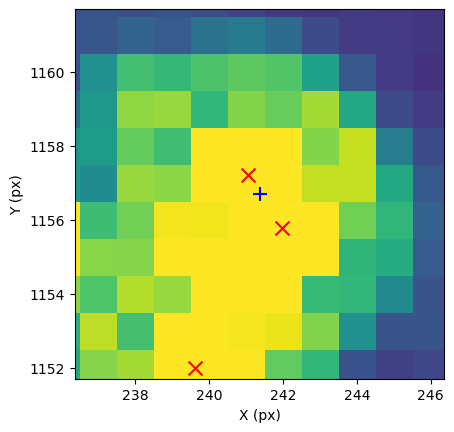

 star  686  dist= 0.03317195681165633


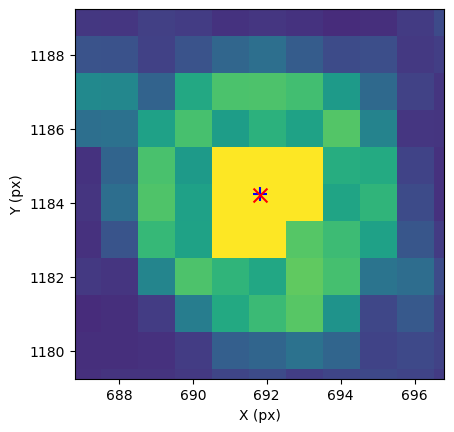

 star  689  dist= 0.035913815443150365


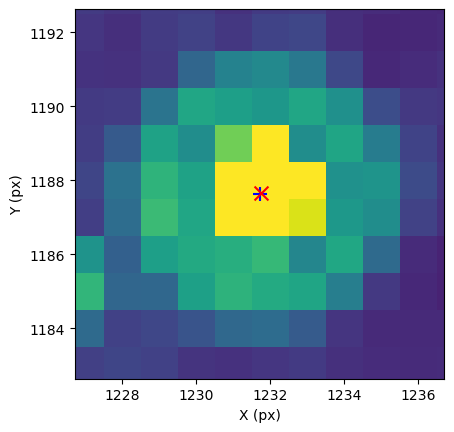

 star  691  dist= 0.032866702634040484


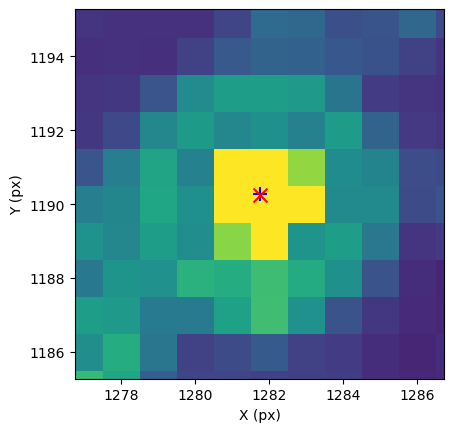

 star  704  dist= 0.03350787699249078


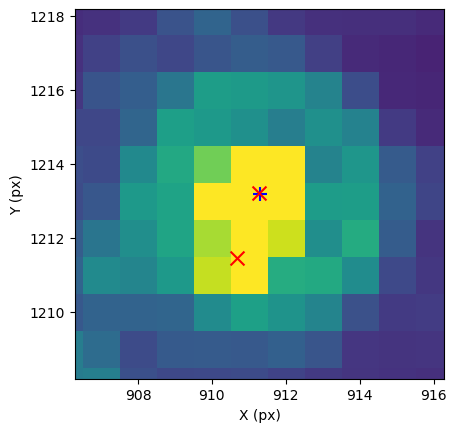

 star  719  dist= 0.04339932271314533


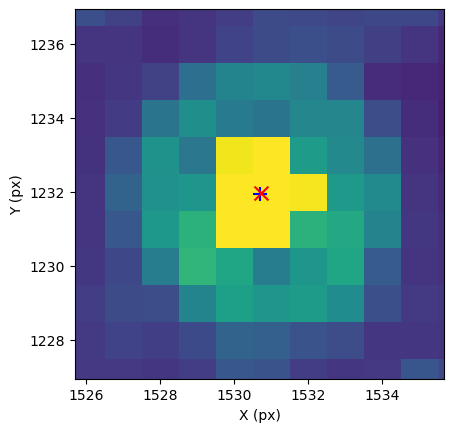

 star  721  dist= 0.04522614017907581


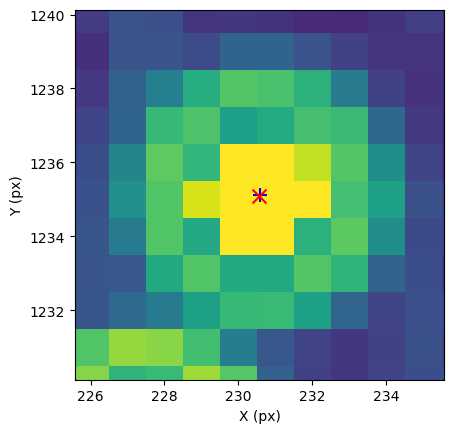

 star  722  dist= 0.042844177277436786


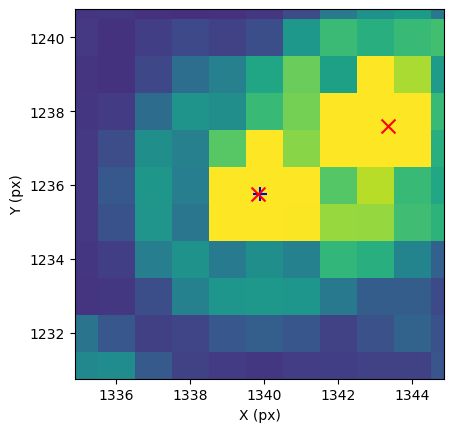

 star  724  dist= 0.12247621836960591


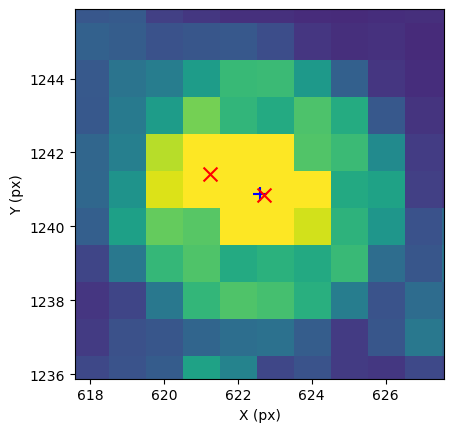

 star  732  dist= 0.03179726204871983


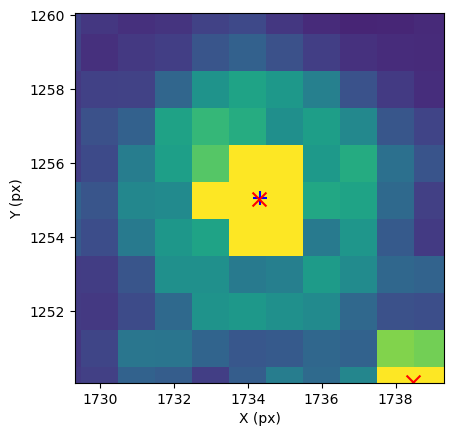

 star  735  dist= 0.03039492997697034


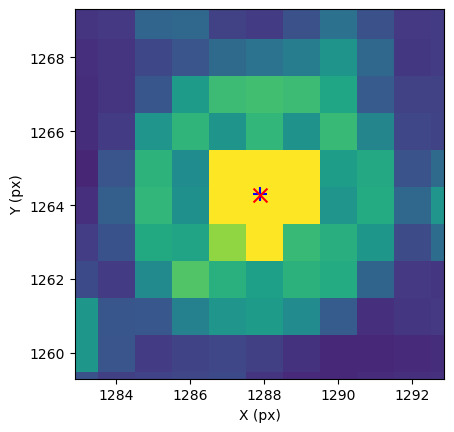

 star  740  dist= 0.041846701177292035


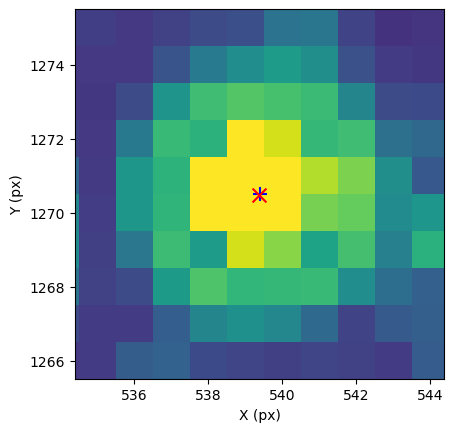

 star  742  dist= 0.03046175068536027


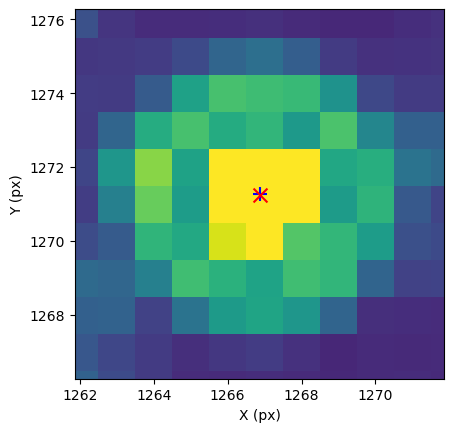

 star  747  dist= 0.111357363795547


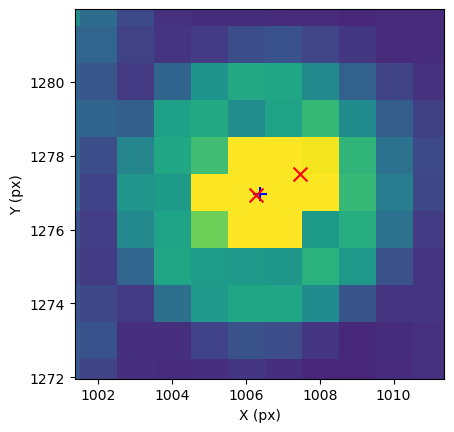

 star  748  dist= 0.03083837538876385


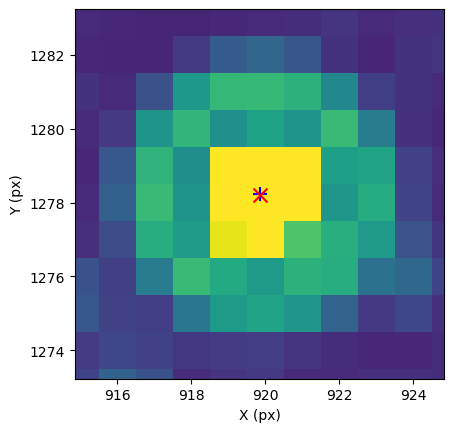

 star  755  dist= 0.04745456566985689


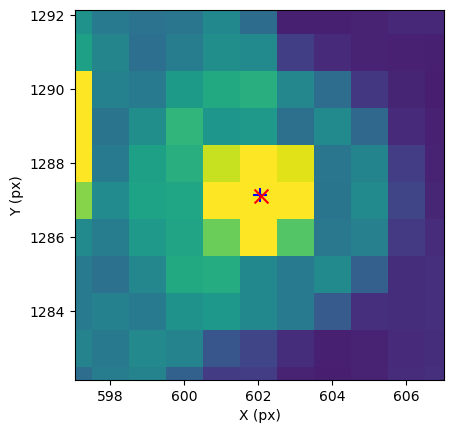

 star  762  dist= 0.047571805899446595


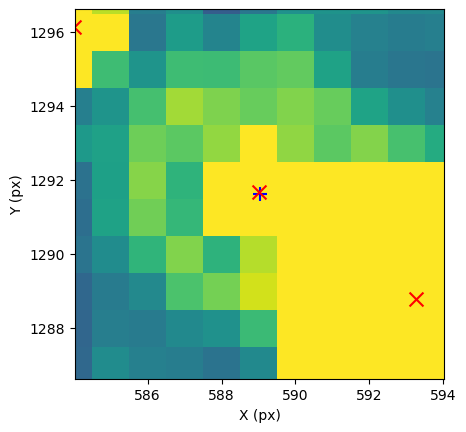

 star  766  dist= 0.03892323305010238


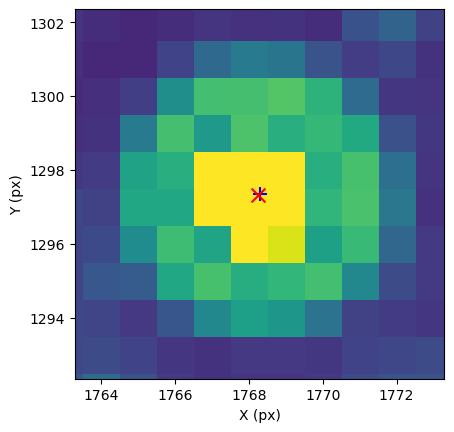

 star  772  dist= 0.030253549951479556


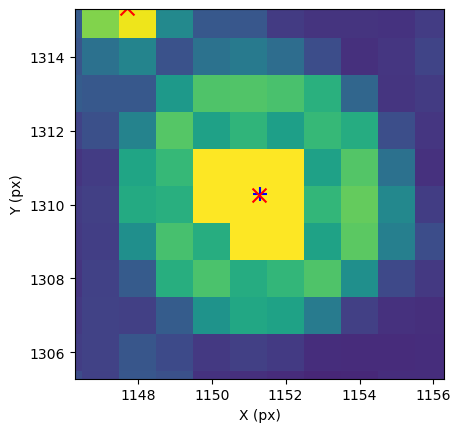

 star  778  dist= 0.07924366714541847


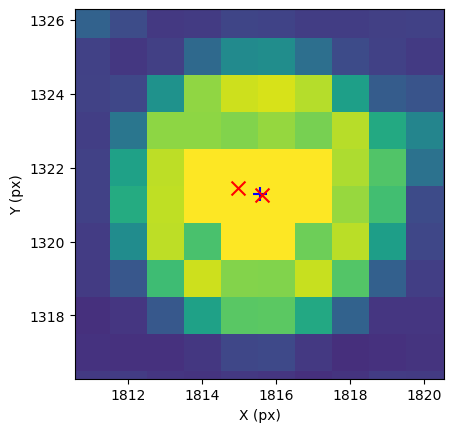

 star  782  dist= 0.030475113860294445


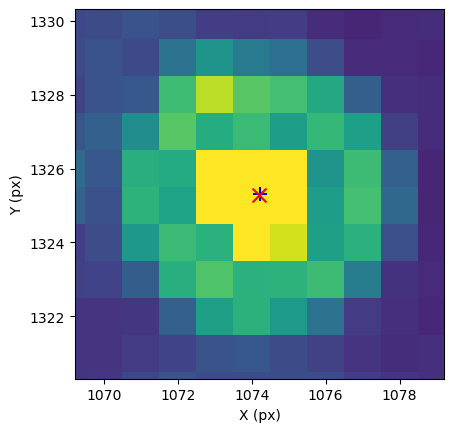

 star  790  dist= 0.039992965639054835


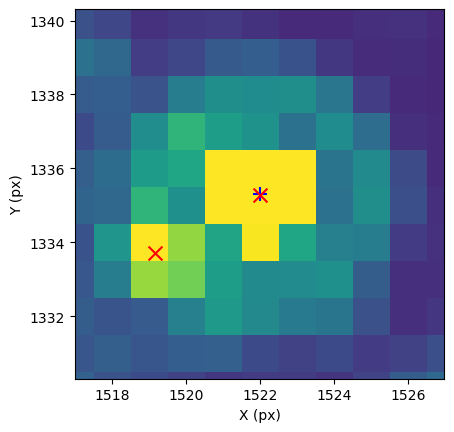

 star  799  dist= 0.20311666874876816


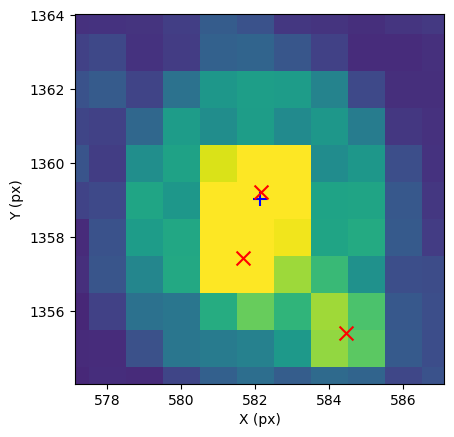

 star  803  dist= 0.03127678628645103


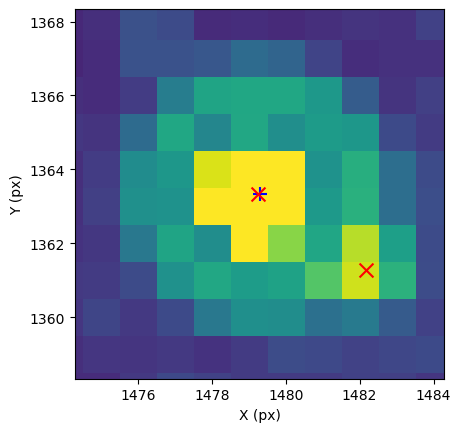

 star  805  dist= 0.036516619518115155


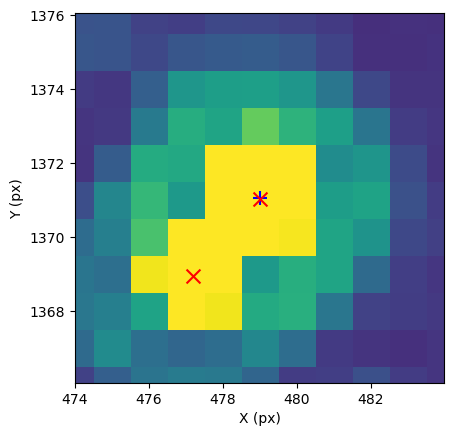

 star  832  dist= 0.037217028777833255


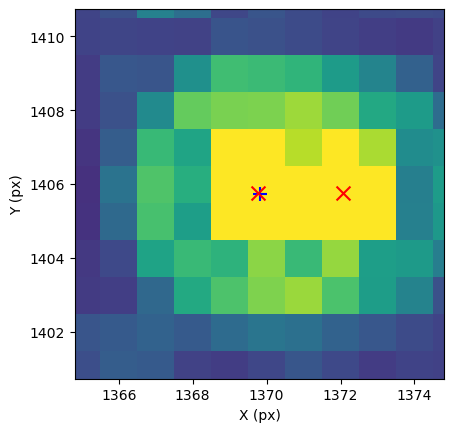

 star  833  dist= 0.03722449532650785


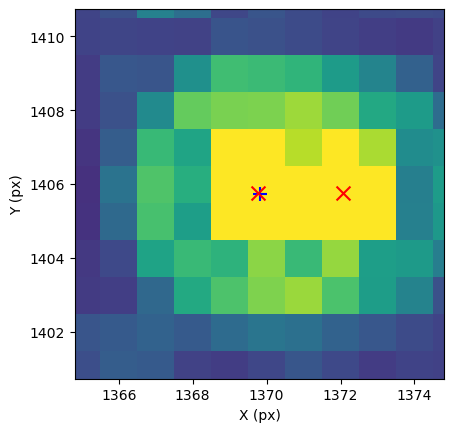

 star  848  dist= 0.06318145247274826


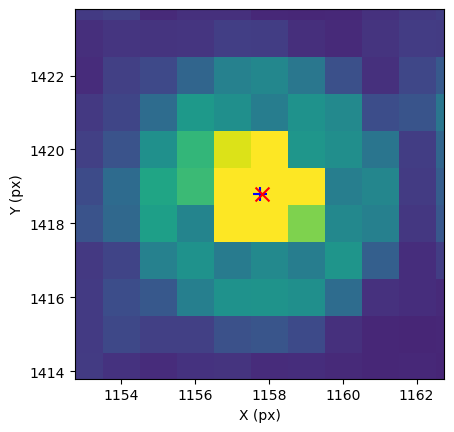

 star  859  dist= 0.037984705635460775


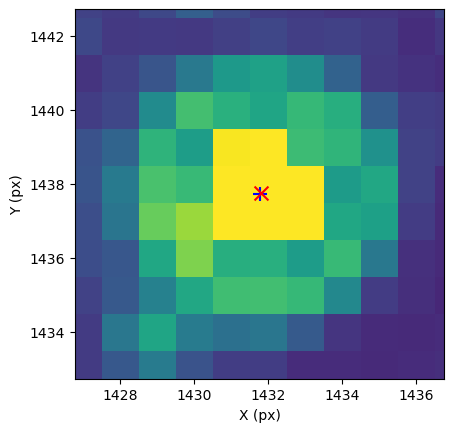

 star  868  dist= 0.0335487945756199


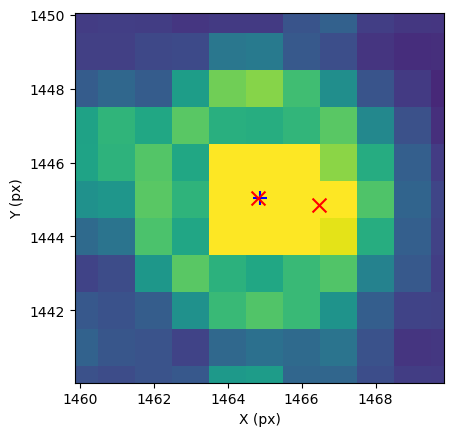

 star  880  dist= 0.030428387664501608


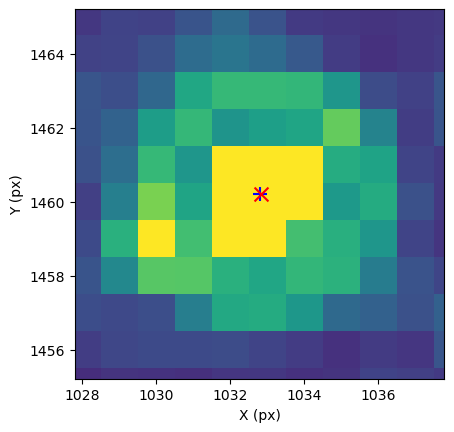

 star  883  dist= 0.05213169262688138


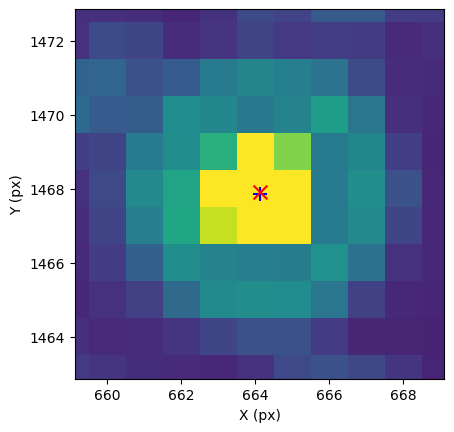

 star  900  dist= 0.05753153445784846


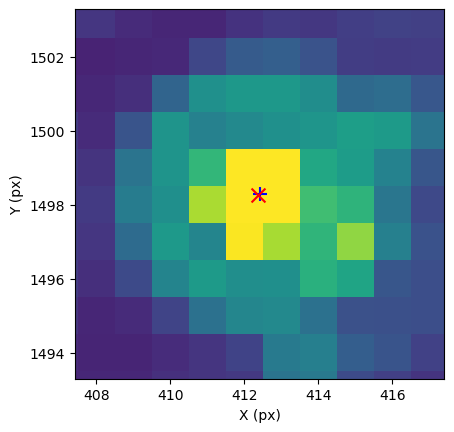

 star  904  dist= 0.044088709427432794


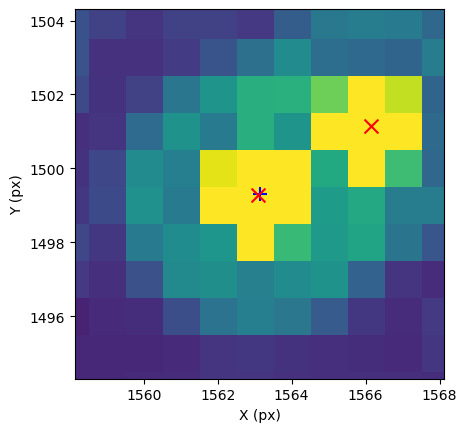

 star  910  dist= 0.031104450818437126


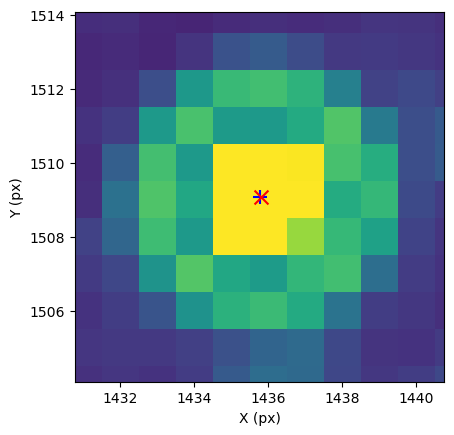

 star  917  dist= 0.3697804015055994


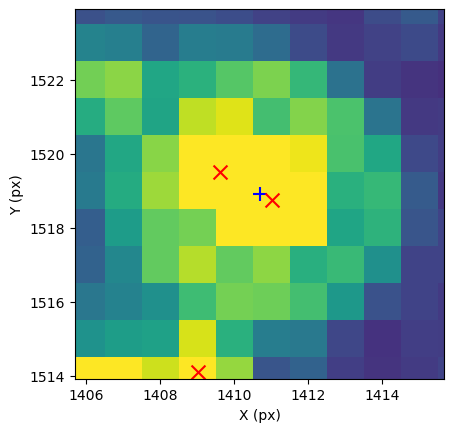

 star  920  dist= 0.06794061665503567


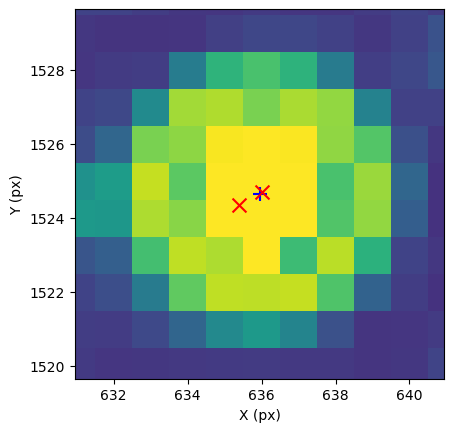

 star  931  dist= 0.2942509364035103


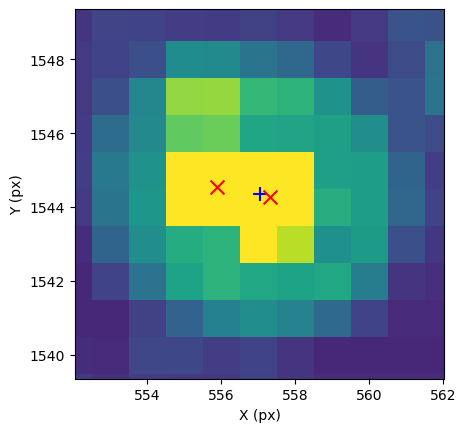

 star  934  dist= 0.03169789430983023


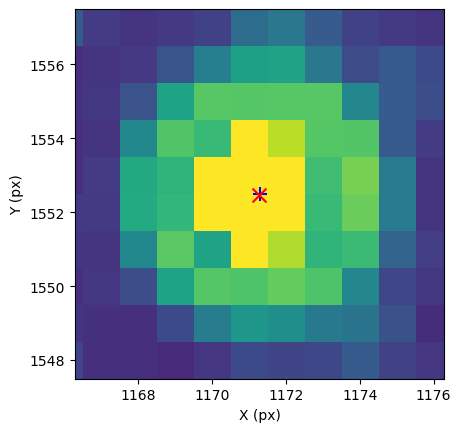

 star  945  dist= 0.030156104015110766


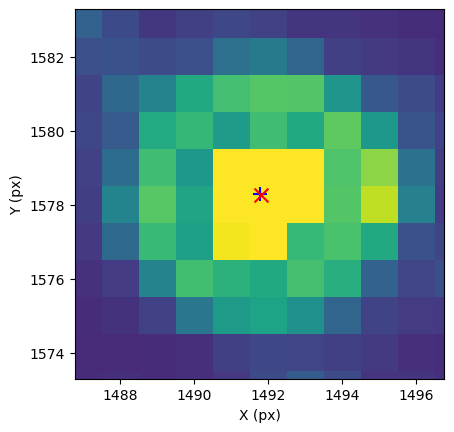

 star  946  dist= 0.04119464850661982


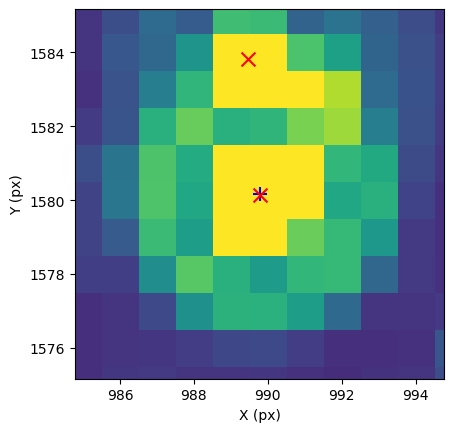

 star  950  dist= 0.03137543781856918


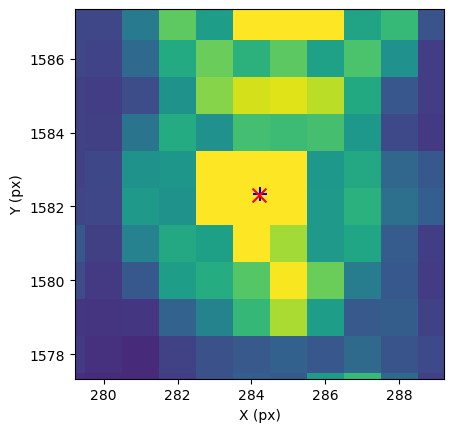

 star  957  dist= 0.053509256417517394


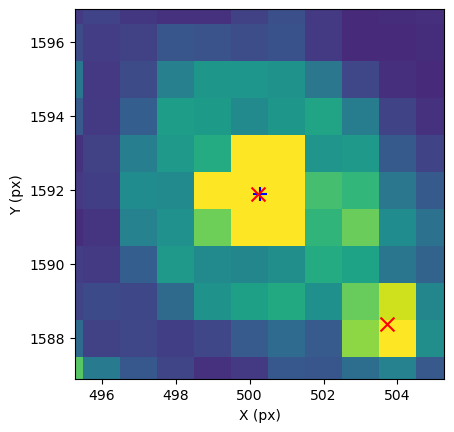

 star  964  dist= 0.031015968114143578


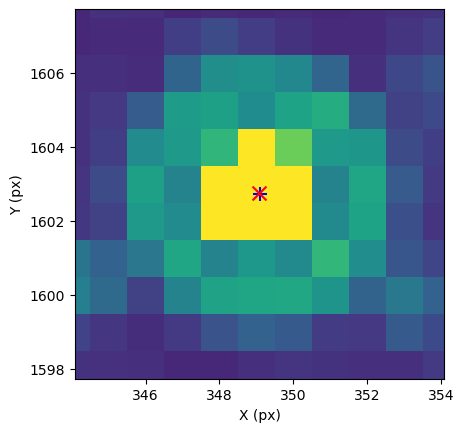

 star  971  dist= 0.03697894419760215


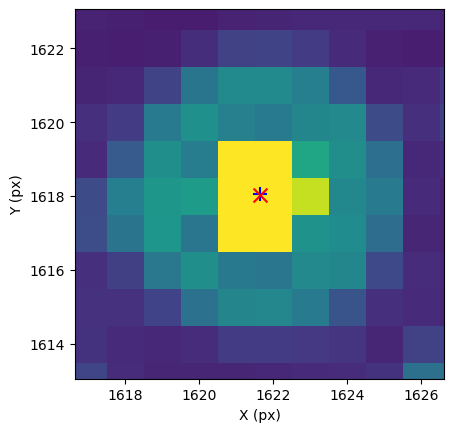

 star  973  dist= 0.03248415468032958


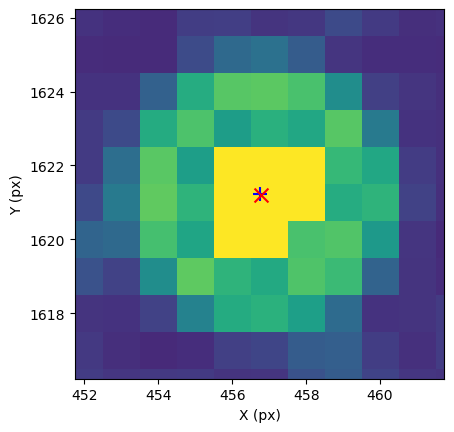

 star  980  dist= 0.030603786817846004


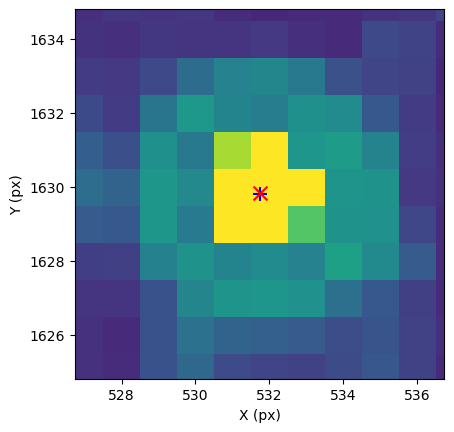

 star  985  dist= 0.03436371219209859


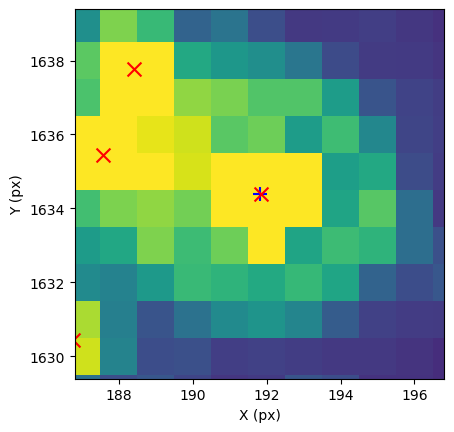

 star  991  dist= 0.038166510294007444


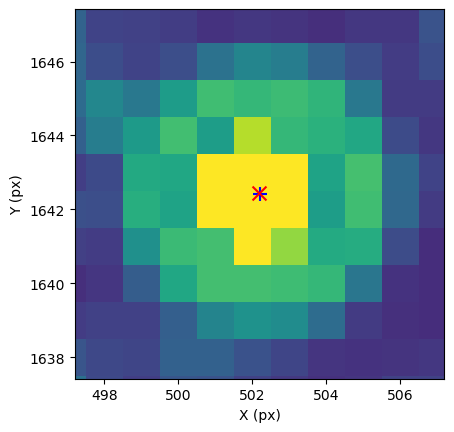

 star  1002  dist= 0.04016311911725951


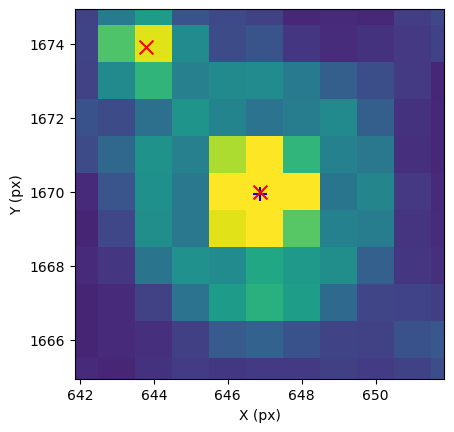

 star  1011  dist= 0.2924772724539954


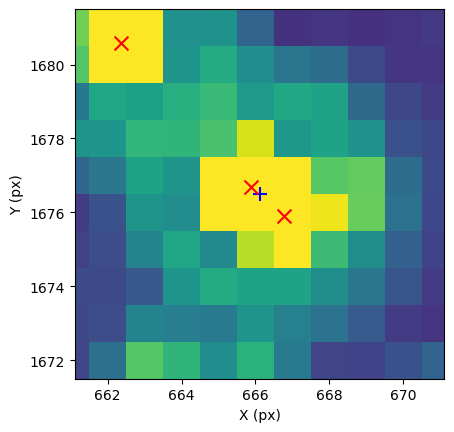

 star  1017  dist= 0.034626655652342235


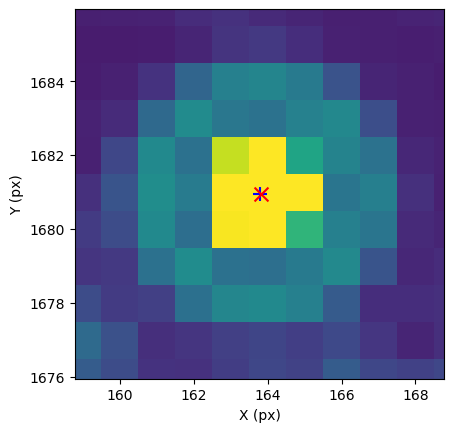

 star  1027  dist= 0.10468023886424416


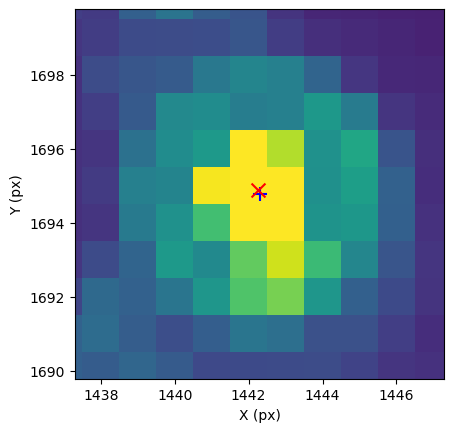

 star  1040  dist= 0.04125431627004908


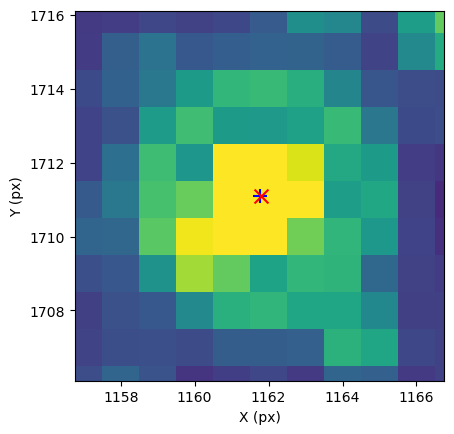

 star  1042  dist= 0.4064913393813608


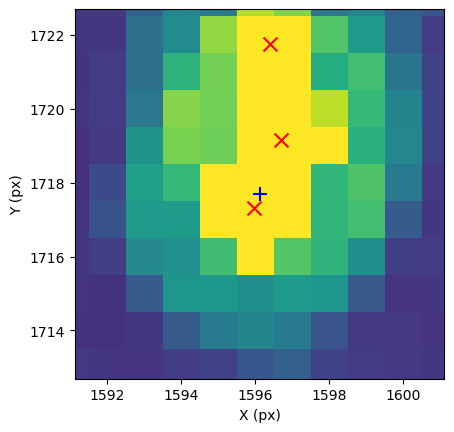

 star  1044  dist= 0.5549521110964931


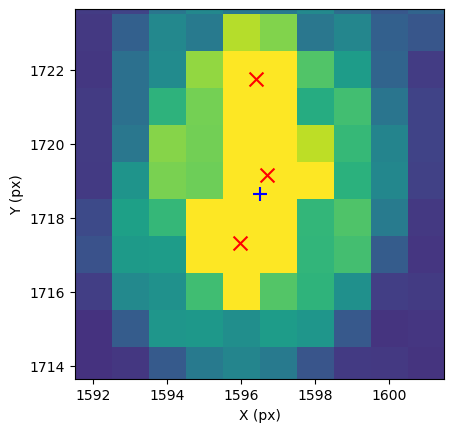

 star  1060  dist= 0.04713375812536786


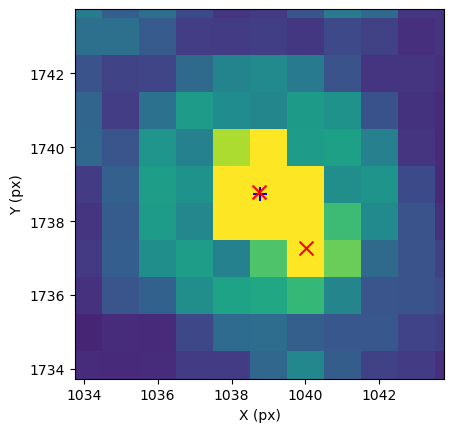

 star  1061  dist= 0.03791732299935561


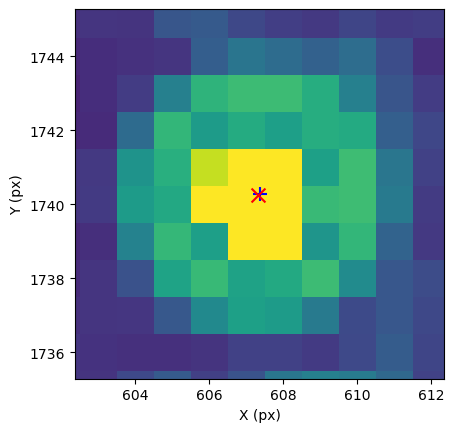

 star  1076  dist= 0.11995925391045371


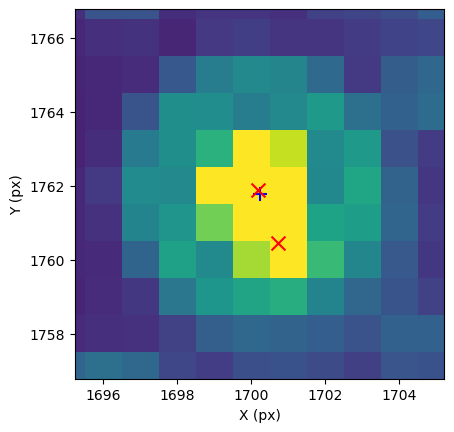

 star  1089  dist= 0.03496047615975388


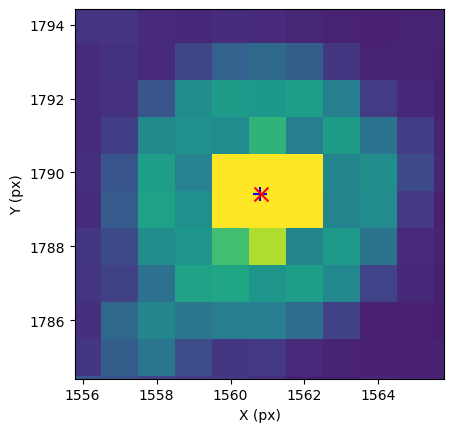

 star  1095  dist= 0.036347703181343095


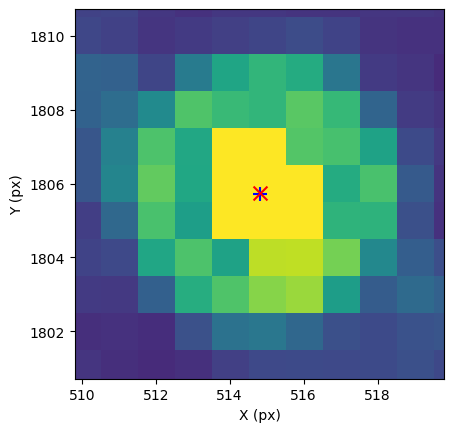

 star  1101  dist= 0.036354956114538206


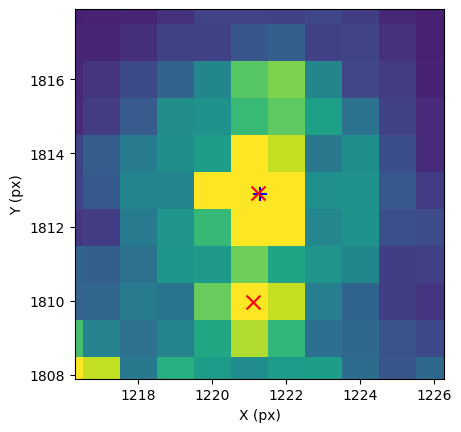

In [46]:
for i in range(len(dist)):
    if dist[i]>0.03: 
        print(' star ', i, ' dist=', dist[i])
        plt.imshow(data, norm=norm, origin='lower', cmap='viridis')
        plt.scatter(xc_array[i,2], xc_array[i,3], s=100, c='blue', marker='+')
        plt.scatter(original[original[:, 6]<15.0, 3]-1+dx_mean, original[original[:,6]<15.0, 2]-1+dy_mean, s=100, c='red', marker='x')
        # plt.scatter(xc_array[i,0]+dx_mean, xc_array[i,1]+dx_mean, s=100, c='red', marker='x')
        plt.xlabel('X (px)')
        plt.ylabel('Y (px)')
        plt.xlim(xc_array[i,2]-5.0, xc_array[i,2]+5.0)
        plt.ylim(xc_array[i,3]-5.0,xc_array[i,3]+5.0)
        plt.show()

### Checking pixel phase error

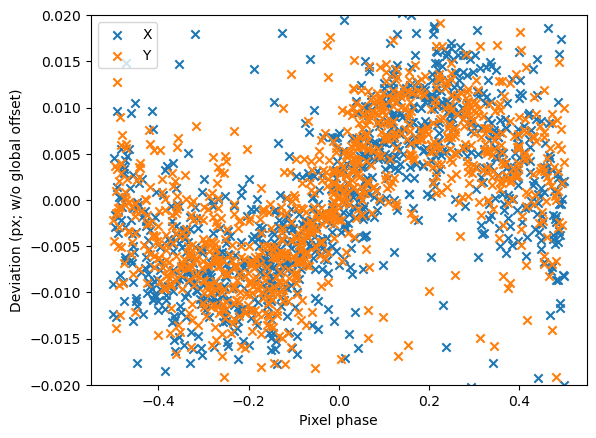

In [47]:
# Making pix-phase error data.
plt.scatter(xc_sel_array[:,0]-(xc_sel_array[:,0]+0.5).astype('int'), dx0_sel, marker='x', label='X')
plt.scatter(xc_sel_array[:,1]-(xc_sel_array[:,1]+0.5).astype('int'), dy0_sel, marker='x', label='Y')
#    plt.xlabel('$\Delta$x (px; w/o global offset)')
#    plt.ylabel('$\Delta$y (px; w/o global offset)')
#    plt.xlim([-0.03-0.98,0.03-0.98])
#    plt.ylim([-0.03-0.98,0.03-0.98])
# plt.xlim([-0.1,0.1])
plt.ylim([-0.02,0.02])
plt.xlabel('Pixel phase')
plt.ylabel('Deviation (px; w/o global offset)')
plt.legend()
plt.show()

Text(0, 0.5, 'Ns')

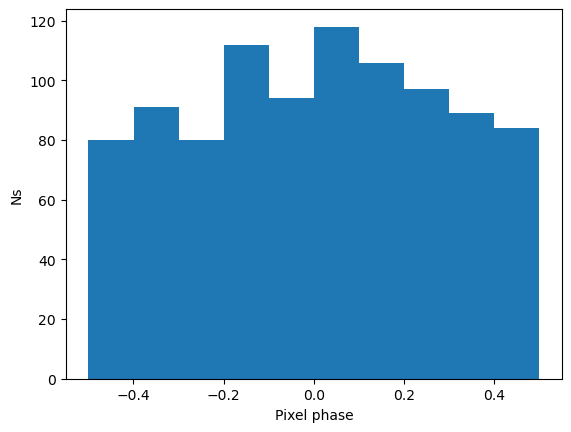

In [48]:
# to make sure avoiding the worst pix-phase error phase stars
plt.hist(xc_sel_array[:,0]-(xc_sel_array[:,0]+0.5).astype('int'), 10)
plt.xlabel('Pixel phase')
plt.ylabel('Ns')

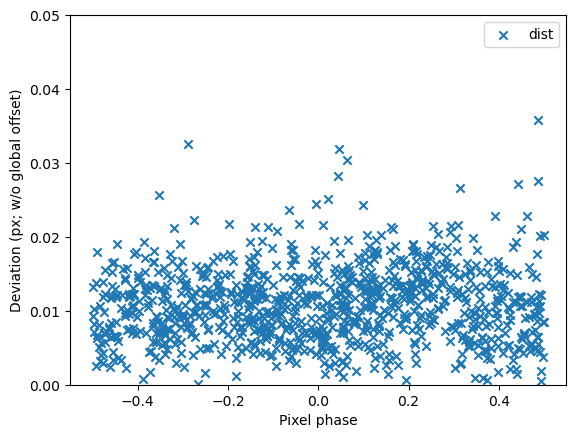

In [49]:
# Making pix-phase error data.
plt.scatter(xc_sel_array[:,0]-(xc_sel_array[:,0]+0.5).astype('int'), dist_sel, marker='x', label='dist')
#    plt.xlabel('$\Delta$x (px; w/o global offset)')
#    plt.ylabel('$\Delta$y (px; w/o global offset)')
#    plt.xlim([-0.03-0.98,0.03-0.98])
#    plt.ylim([-0.03-0.98,0.03-0.98])
# plt.xlim([-0.1,0.1])
plt.ylim([0.0,0.05])
plt.xlabel('Pixel phase')
plt.ylabel('Deviation (px; w/o global offset)')
plt.legend()
plt.show()

### One more iteration to get rid of low quality data.

In [50]:
distlim = 0.02
stars_sel2_tbl = Table()
stars_sel2_tbl['x'] = np.round(xc_sel_array[dist_sel<distlim,2]).astype('int')
stars_sel2_tbl['y'] = np.round(xc_sel_array[dist_sel<distlim,3]).astype('int')
print(stars_sel2_tbl)

 x    y  
---- ----
 322  125
 651  125
 634  128
1720  132
 611  135
1756  137
 325  139
 ...  ...
 549 1804
1221 1806
1128 1808
1259 1808
1821 1810
1141 1813
1738 1814
Length = 916 rows


In [51]:
# Extracting stellar images.
ext_size  = 9
nddata_sel2 = NDData(data=data)
print(nddata_sel2.data.shape)
stars_sel2 = extract_stars(nddata_sel2, stars_sel2_tbl, size=ext_size)

(1968, 1968)


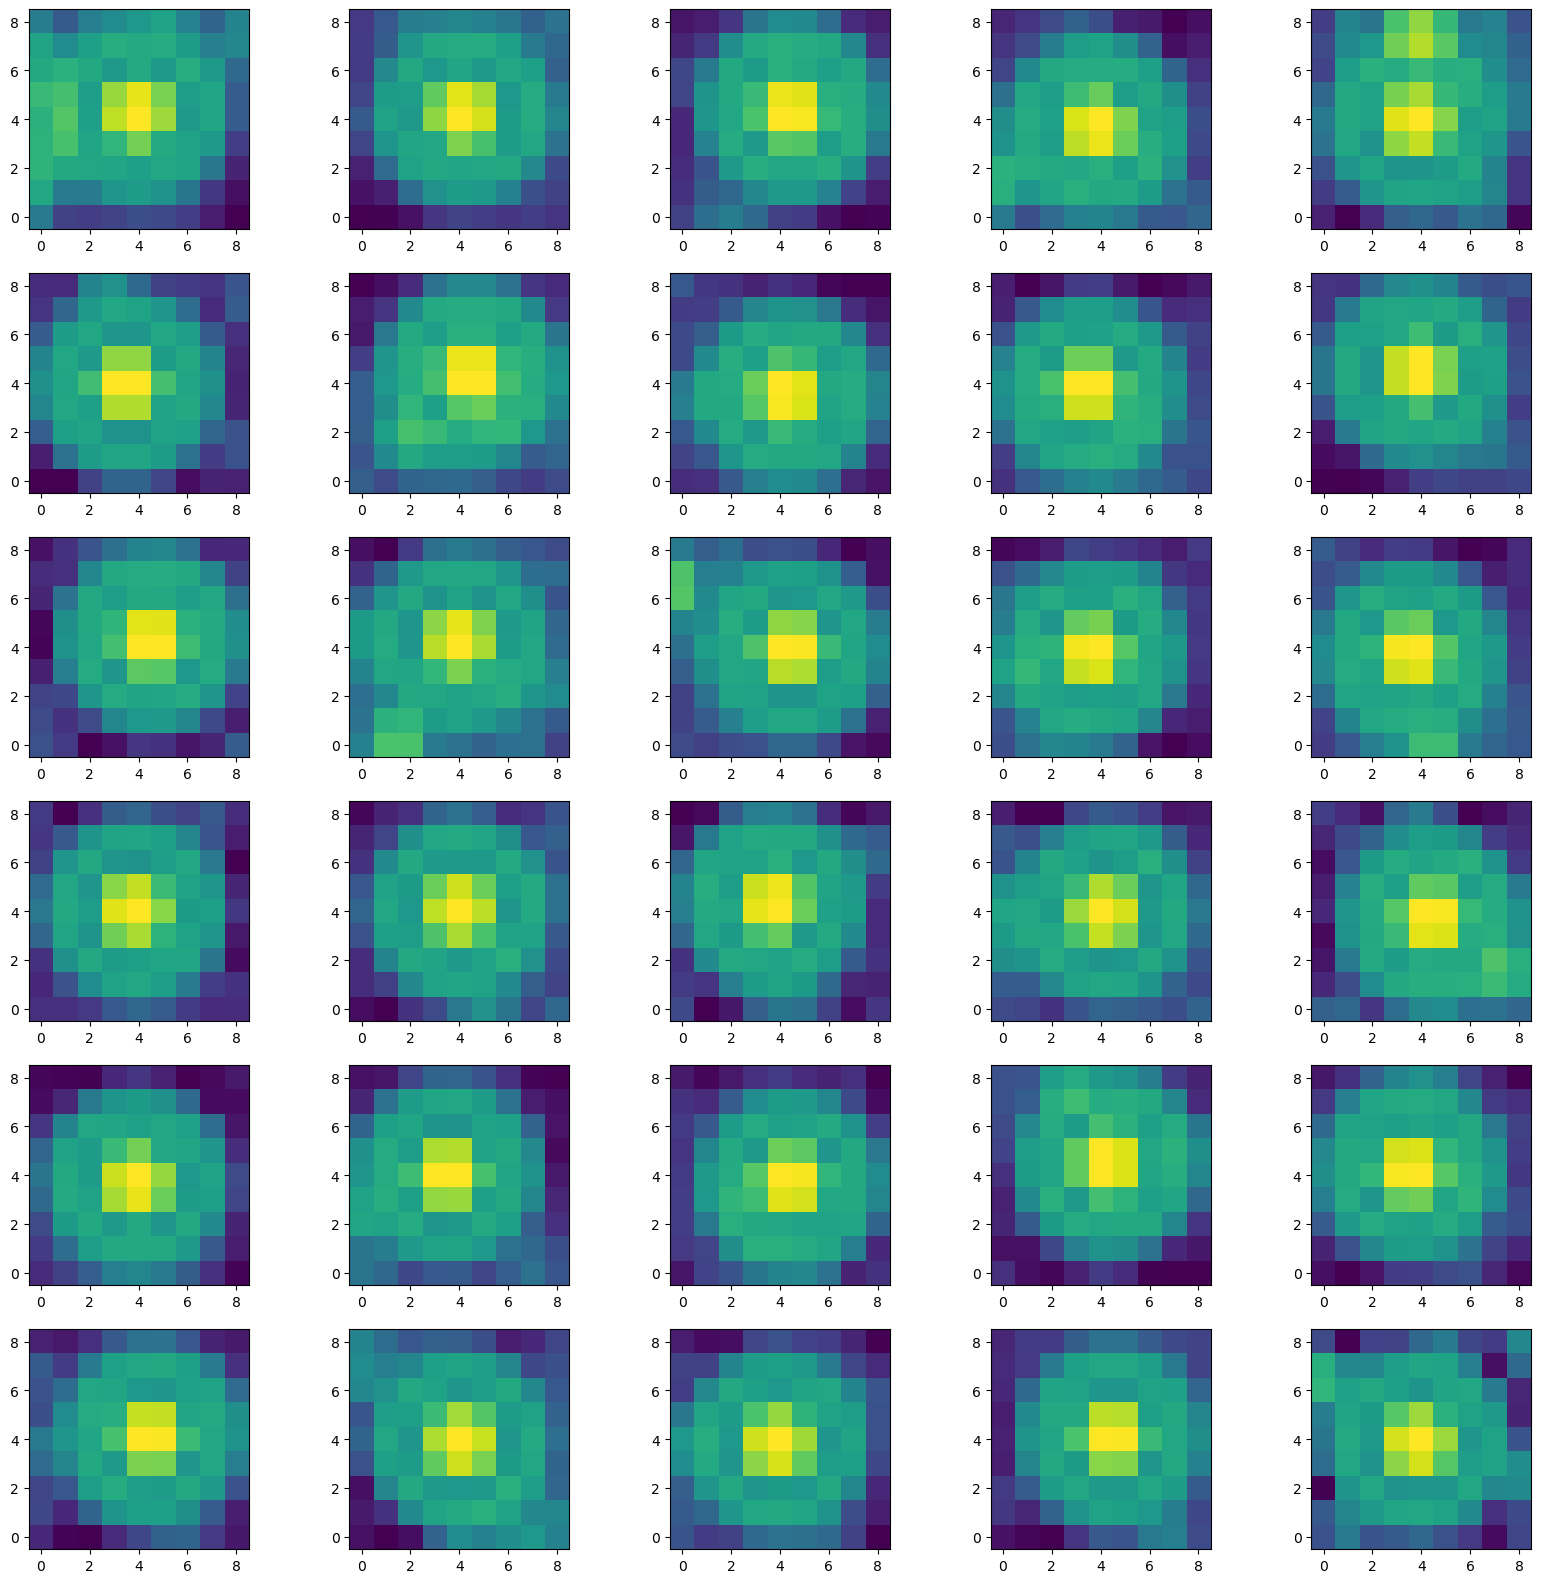

In [52]:
nrows = 6
ncols = 5
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 20), squeeze=True)
ax = ax.ravel()
for i in range(nrows*ncols):
    norm_sel2 = simple_norm(stars_sel2[i], 'log', percent=99.)
    ax[i].imshow(stars_sel2[i], norm=norm_sel2, origin='lower', cmap='viridis')
plt.show()

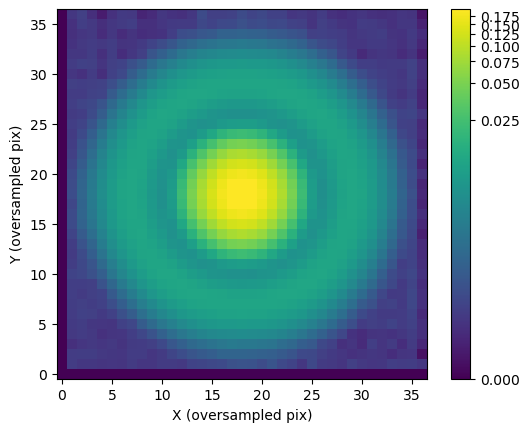

In [53]:
# Making ePSF.
n_oversample = 4 # Number of oversampling for ePSF.
n_maxiter    = 3 # Max. number of iteration for making ePSF.
norm_radius  = 5.5 # Number of undersampled pixels which determines the radius for flux normalization of ePSF.
recentering_boxsize = 5 #  Number of undersampled pixels which determines the box size for ePSF recentering calculation.

epsf_builder_sel2 = EPSFBuilder(oversampling=n_oversample,
                           maxiters=n_maxiter, progress_bar=False,
                           norm_radius=norm_radius, recentering_boxsize=recentering_boxsize,
                           center_accuracy=0.001)
epsf_sel2, fitted_stars_sel2 = epsf_builder_sel(stars_sel2)
norm_sel2 = simple_norm(epsf_sel2.data, 'log', percent=99.)
    
plt.imshow(epsf_sel2.data, norm=norm_sel2, origin='lower', cmap='viridis')
plt.xlabel('X (oversampled pix)')
plt.ylabel('Y (oversampled pix)')
plt.colorbar()
plt.show()

number of stars brighter than  12.5 = 585


(200.0, 400.0)

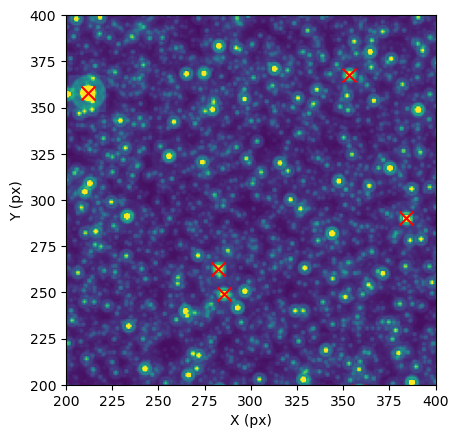

In [54]:
# Subtracting background.
maglimit = 12.5
norm_sel2 = simple_norm(data, 'sqrt', percent=99.)
print('number of stars brighter than ', maglimit, '=', len(original[original[:,6]<maglimit, 2]))
plt.imshow(data, norm=norm_sel2, origin='lower', cmap='viridis')
plt.scatter(original[original[:, 6]<maglimit, 3]-1, original[original[:,6]<maglimit, 2]-1, s=100, c='red', marker='x')
plt.xlabel('X (px)')
plt.ylabel('Y (px)')
plt.xlim(200, 400)
plt.ylim(200, 400)


In [55]:
# Cross-matching the data.
xc_sel2_array = []
maglim_o = maglimit+1.0
# search stars only for brighter stars
stars_sel2_list = original[original[:, 6] < maglim_o]
print(np.shape(stars_sel2_list))

# for loop for fitted stars
nfitted_stars_sel2 = len(fitted_stars_sel2.center_flat[:, 0])
print(' N fitted stars=', np.shape(fitted_stars_sel2.center_flat), nfitted_stars_sel2)
print(' fitted_stars.center_flat', np.shape(fitted_stars_sel2.center_flat[0]))
for i in range(nfitted_stars_sel2):
    xdiff = fitted_stars_sel2.center_flat[i, 0]-stars_sel2_list[:, 3]+1.0
    ydiff = fitted_stars_sel2.center_flat[i, 1]-stars_sel2_list[:, 2]+1.0
    dist2 = xdiff**2+ydiff**2
    # closest
    mindx = np.argmin(dist2)
    # print(' indx, dist, x, y s, f=', mindx, dist2[mindx], o[3]-1.0, o[2]-1.0, fitted_stars.center_flat[mindx])
    # print(dist2[mindx], stars_list[mindx, 3]-1.,stars_list[mindx, 2]-1.,fitted_stars.center_flat[i, 0], fitted_stars.center_flat[i, 1])
    xc_sel2_array.append([stars_sel2_list[mindx, 3]-1.,stars_sel2_list[mindx, 2]-1.,      # 1-origin -> 0-origin
                             fitted_stars_sel2.center_flat[i, 0],
                             fitted_stars_sel2.center_flat[i, 1],  stars_sel2_list[mindx, 6]])
    if dist2[mindx]>0.6: 
        print(' star ', i, ' min dist =', np.sqrt(dist2[mindx]), stars_sel2_list[mindx, 6])
        plt.imshow(data, norm=norm_sel2, origin='lower', cmap='viridis')
        plt.scatter(fitted_stars_sel2.center_flat[i, 0], fitted_stars_sel2.center_flat[i, 1], s=100, c='blue', marker='+')
        plt.scatter(original[original[:, 6]<maglim_o, 3]-1, original[original[:,6]<maglim_o, 2]-1, s=100, c='red', marker='x')
        plt.xlabel('X (px)')
        plt.ylabel('Y (px)')
        plt.xlim(fitted_stars_sel2.center_flat[i, 0]-5.0, fitted_stars_sel2.center_flat[i, 0]+5.0)
        plt.ylim(fitted_stars_sel2.center_flat[i, 1]-5.0, fitted_stars_sel2.center_flat[i, 1]+5.0)
        plt.show()
xc_sel2_array = np.array(xc_sel2_array)
print(' number of stars brighter than ', maglim_o, ' in the list =', len(xc_sel2_array))

(1990, 7)
 N fitted stars= (916, 2) 916
 fitted_stars.center_flat (2,)
 number of stars brighter than  13.5  in the list = 916


In [56]:
print(np.shape(xc_sel2_array))

(916, 5)


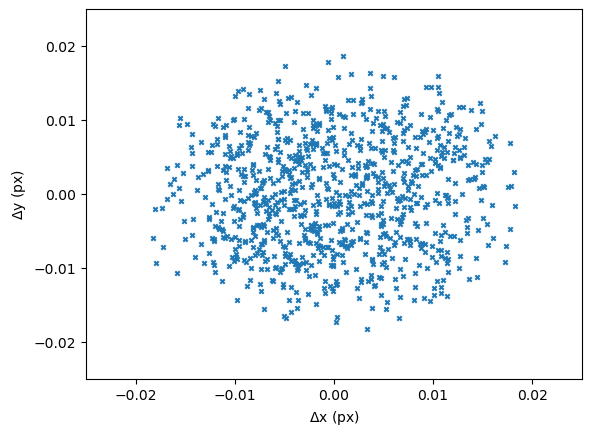

 number of stars fitted = 916
 mean error for dist (pix) = 0.010061742225860853
 std error for dist (pix) = 0.0042103900479678255
 mean error for dist (mas) = 4.749142330606323
 std error for dist (mas) = 1.9873041026408136


In [57]:
# Making dx/dy data.
dx_sel2 = xc_sel2_array[:,2] - xc_sel2_array[:,0]
dy_sel2 = xc_sel2_array[:,3] - xc_sel2_array[:,1]
dx0_sel2 = dx_sel2 - np.mean(dx_sel2)
dy0_sel2 = dy_sel2 - np.mean(dy_sel2)
dx_mean_sel2 = np.mean(dx_sel2)
dy_mean_sel2 = np.mean(dy_sel2)
dist_sel2 = np.sqrt(dx0_sel2**2+dy0_sel2**2)
plt.scatter(dx0_sel2, dy0_sel2, s=10, marker='x')
plt.xlabel('$\Delta$x (px)')
plt.ylabel('$\Delta$y (px)')
plt.xlim([-0.025,0.025])
plt.ylim([-0.025,0.025])
plt.show()
print(' number of stars fitted =', len(dist_sel2))
print(' mean error for dist (pix) =', np.mean(dist_sel2))
print(' std error for dist (pix) =', np.std(dist_sel2))
print(' mean error for dist (mas) =', np.mean(dist_sel2)*pixmas)
print(' std error for dist (mas) =', np.std(dist_sel2)*pixmas)


In [58]:
# 1D error
print(' dx std (pix)=', np.std(dx0_sel2))
print(' dy std (pix)=', np.std(dy0_sel2))
print(' dx std (mas)=', np.std(dx0_sel2)*pixmas)
print(' dy std (mas) =', np.std(dy0_sel2)*pixmas)

 dx std (pix)= 0.007979471838030359
 dy std (pix)= 0.007435998262626092
 dx std (mas)= 3.7663107075503293
 dy std (mas) = 3.5097911799595156


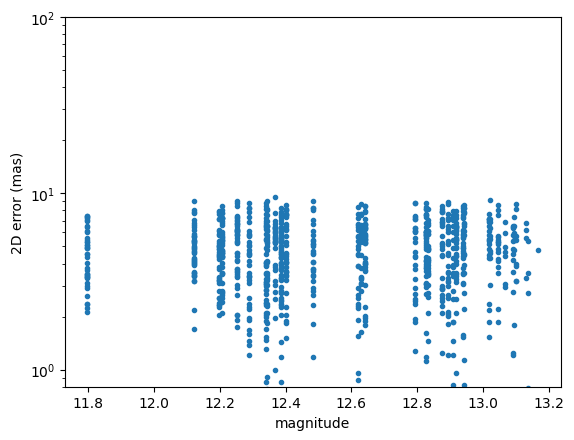

 N star (<4 mas) = 346


In [59]:
plt.scatter(xc_sel2_array[:, 4], dist_sel2*pixmas, marker='.')
plt.ylim([0.8,100.0])
plt.xlabel('magnitude')
plt.ylabel('2D error (mas)')
plt.yscale('log')
plt.show()
distmas_sel2 = dist_sel2*pixmas
print(' N star (<4 mas) =', len(distmas_sel2[distmas_sel2<4.0]))

Text(0, 0.5, 'Ns')

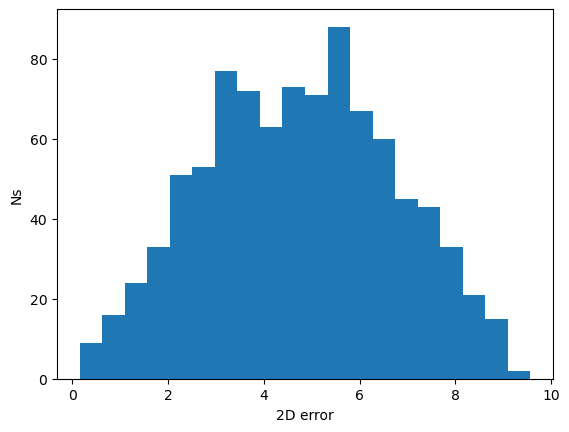

In [60]:
plt.hist(distmas_sel2, 20)
plt.xlabel('2D error')
plt.ylabel('Ns')

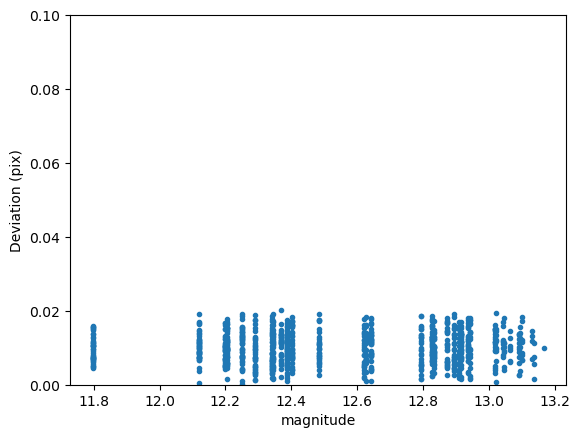

In [61]:
plt.scatter(xc_sel2_array[:, 4], dist_sel2, marker='.')
plt.ylim([0.0,0.1])
plt.xlabel('magnitude')
plt.ylabel('Deviation (pix)')
plt.show()

### 1D error

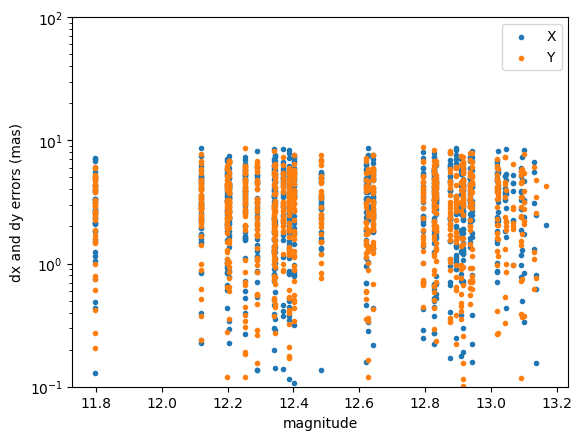

In [62]:
plt.scatter(xc_sel2_array[:, 4], np.fabs(dx0_sel2)*pixmas, marker='.', label='X')
plt.scatter(xc_sel2_array[:, 4], np.fabs(dy0_sel2)*pixmas, marker='.', label='Y')
plt.ylim([0.1,100.0])
plt.xlabel('magnitude')
plt.ylabel('dx and dy errors (mas)')
plt.yscale('log')
plt.legend()
plt.show()

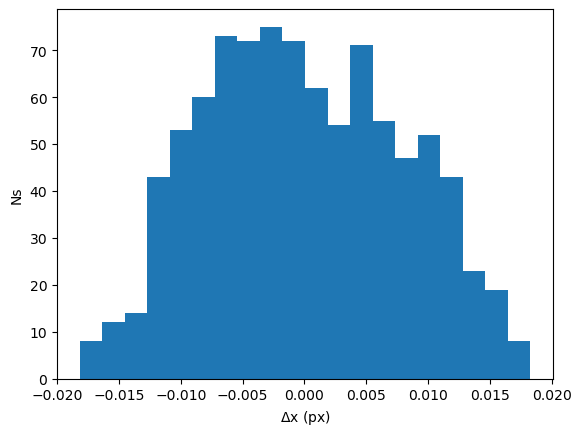

In [63]:
plt.hist(dx0_sel2, 20)
plt.ylabel('Ns')
plt.xlabel('$\Delta$x (px)')
plt.show()

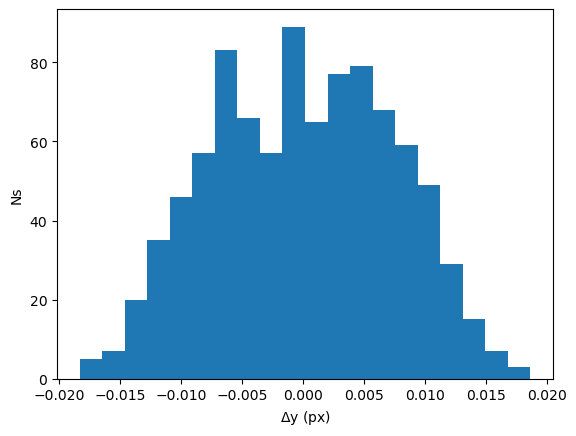

In [64]:
plt.hist(dy0_sel2, 20)
plt.ylabel('Ns')
plt.xlabel('$\Delta$y (px)')
plt.show()

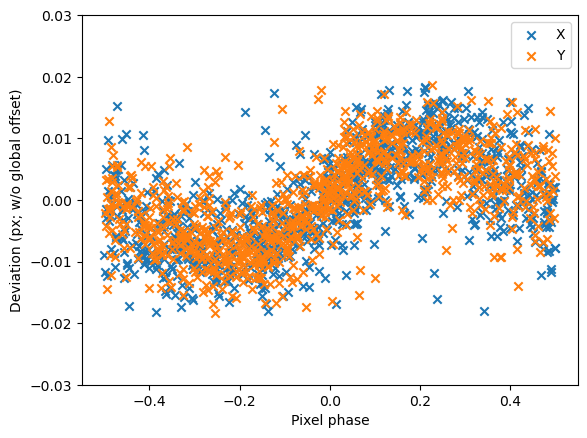

In [65]:
# Making pix-phase error data.
plt.scatter(xc_sel2_array[:,0]-(xc_sel2_array[:,0]+0.5).astype('int'), dx0_sel2, marker='x', label='X')
plt.scatter(xc_sel2_array[:,1]-(xc_sel2_array[:,1]+0.5).astype('int'), dy0_sel2, marker='x', label='Y')
#    plt.xlabel('$\Delta$x (px; w/o global offset)')
#    plt.ylabel('$\Delta$y (px; w/o global offset)')
#    plt.xlim([-0.03-0.98,0.03-0.98])
#    plt.ylim([-0.03-0.98,0.03-0.98])
# plt.xlim([-0.1,0.1])
plt.ylim([-0.03, 0.03])
plt.xlabel('Pixel phase')
plt.ylabel('Deviation (px; w/o global offset)')
plt.legend()
plt.show()

Text(0.5, 0, 'Pixel phase')

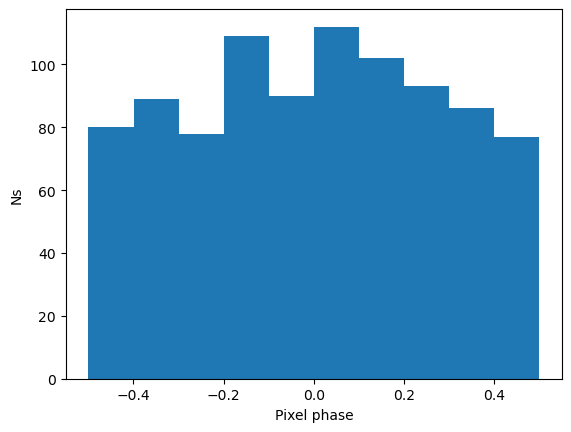

In [66]:
plt.hist(xc_sel2_array[:,0]-(xc_sel2_array[:,0]+0.5).astype('int'))
plt.ylabel('Ns')
plt.xlabel('Pixel phase')